In [3]:
using LinearAlgebra, Random, Statistics, Plots

# Weak random features

Here we'll generate data using the so-called weak random features model:

1. the first `num_informative_features` features are noisy versions of the label `y`
2. the rest of the features are pure noise 

We're interested in understanding the optimal model complexity as a function of the number of features we choose, in each of these models.

## Questions

1. How does the optimal model complexity depend on the noise in the features?
2. When does the error curve exhibit a "double descent" behavior? When is the best model found on the first descent vs the second descent?
3. How does this phenomenon depend on the choice of optimizer / regularizer, for underconstrained problems?

In [4]:
function random_features(n=100,d=100; num_informative_features = 20)
    y = randn(n)
    X = randn(n,min(d,num_informative_features)) .+ y
    if d > num_informative_features
        X = hcat(X, randn(n,d - num_informative_features))
    end
    return X,y
end

random_features (generic function with 3 methods)

  7.340571 seconds (966.29 k allocations: 390.458 MiB, 2.28% gc time)


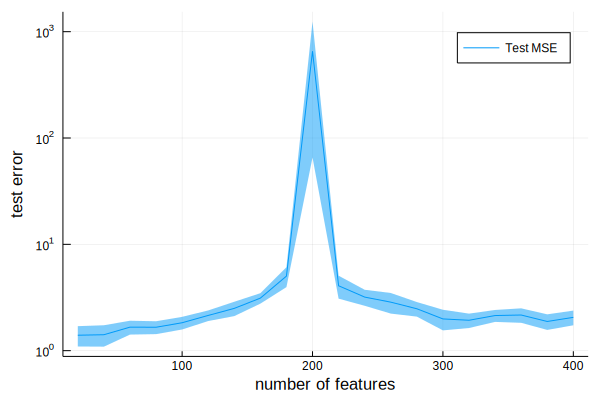

In [32]:
n = 200
ds=20:20:2n
num_informative_features = 10 # try 10, 100, 1000
nreps = 10

mses = zeros(length(ds),nreps)
train_errors = zeros(length(ds),nreps)
@time for rep in 1:nreps
    mse = []
    train_error = []
    for d in ds
        Xtrain,ytrain = random_features(n,d; num_informative_features=num_informative_features)
        w = Xtrain\ytrain
        Xtest,ytest = random_features(Int(n/10),d; num_informative_features=num_informative_features)
        push!(mse, norm(ytest-Xtest*w))
        push!(train_error, norm(ytrain-Xtrain*w))
    end
    mses[:,rep] = mse
    train_errors[:,rep] = train_error
end
mean_mse = mean(mses,dims=2)
std_mse = std(mses,dims=2)
mean_te = mean(train_errors,dims=2)
std_te = std(train_errors,dims=2)

std_mse = min.(std_mse,.9mean_mse) # a hack to ensure we don't try to plot a negative number on a log plot
std_te = min.(std_te,.9mean_te) # a hack to ensure we don't try to plot a negative number on a log plot
plot(ds,mean_mse,ribbon=std_mse,label="Test MSE")
# plot!(ds,mean_te,ribbon=std_te,label="Train MSE")
yaxis!(:log)
ylabel!("test error")
xlabel!("number of features")

## Observations: 

1. The error blows up as $d \to n$.
2. With 10 informative features, the best test error occurs for d as small as possible.
3. With 100 informative features, the best test error occurs around d=100.
4. When all features are informative, the best test error occurs as $d \to \infty$ (or, at least, as large as we tested).

# MNIST

MNIST is a dataset of images with 784 grayscale pixels, representing digits. We will be fitting classifiers to this dataset, and hopefully recovering the double descent curve.

Instead of operating on the pixels direclty, we are going to use a ReLU features: that is, we will take a random matrix, then use it to transform the raw pixels into $d$ features. We will throw away all the nonnegative numbers beceause this makes our initial transformation nonlinear, which actually makes the entire model more expressive (this is common practice in deep nets, although we are not training the first layer at all).

We use a procedure with decaying gradient stepsize, and play with regularizers as well (everything except the regularizers is usable, but the regularizers are a little hacky; we recommend other example code provided in this class).

Let's first load the data, then write up all the utility functions necessary.

In [5]:
# read data 
using MLDatasets, ImageCore

Xtrain, ytrain = MNIST.traindata()
Xtest,  ytest  = MNIST.testdata()

Xtrain = MNIST.convert2features(Xtrain)'
Xtest = MNIST.convert2features(Xtest)'

10000×784 Adjoint{Normed{UInt8,8},Base.ReshapedArray{Normed{UInt8,8},2,Base.ReinterpretArray{Normed{UInt8,8},3,UInt8,Array{UInt8,3}},Tuple{}}}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [6]:
# view training data as images; eg the 5th example:
MNIST.convert2image(MNIST.traintensor(5))

In [7]:
function convert2psi(ys, n = 10)
    psis = -1.0*ones(length(ys), n)
    for i in 1:length(ys)
        psis[i, ys[i] + 1] = 1.0
    end
    return psis
end

psiTrain = convert2psi(ytrain)
psiTest = convert2psi(ytest)

10000×10 Array{Float64,2}:
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0
 -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
  1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0
  ⋮                             ⋮                          
 -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  

In [8]:
ReLU(x) = max(x,0)

struct RandomFeatureMap
    W::AbstractArray
end
RandomFeatureMap(din,dout) = RandomFeatureMap(randn(din,dout))

function featurize(X,M::RandomFeatureMap)
    return ReLU.(X*M.W)
end

featurize (generic function with 1 method)

In [12]:
function hinge(ys, preds)
    return ReLU.((-ys.*preds).+1)
end

function hingeDerivative(ys, preds)
    return sign.(hinge(ys, preds)).*(-ys)
end

function linDerivatives(X, outDers)
    bDer = zeros(size(outDers)[2])
    WDer = zeros(size(outDers)[2]).*transpose(zeros(size(X)[2]))
    for i in 1:(size(X)[1])
        bDer += outDers[i, :]
        WDer += outDers[i, :].*transpose(X[i, :])
    end
    return WDer, bDer
end

linDerivatives (generic function with 1 method)

In [13]:
function predictedClass(preds)
    _, h = findmax(preds, dims=2)
    ypred = [element[2] - 1 for element in h]
    return ypred
end

function accuracy(y, ypred)
    # Unlike the other losses, this one takes the actual class labels as input, not the transformed inputs (psis)
    return sum(y.==ypred)/length(y)
end

accuracy (generic function with 1 method)

In [14]:
function layer1step(Loss, W, b, Wder, bder, eps = 0.01)
    targetChange = eps*Loss
    expectedChange = sum(bder.^2) + sum(Wder.^2) + 1.0
    r = min(abs(targetChange/expectedChange), 1)
    #println(r)
    return min.(max.(W - transpose(Wder).*r, -10), 10), min.(max.(b - bder.*r, -10), 10)
end

function gradDescent(Xs, psis, ys, maxTrain = 100, eps = 0.1, decay = false, l2lambda = 0.0)
    d = size(Xs)[2]
    k = size(psis)[2]
    W = randn(d, k)./(d^0.5) #Useful regularization to make the sum in the ballpark of 1.0
    b = randn(k)
    accsTrain = zeros(maxTrain)
    for i in 1:maxTrain
        preds = Xs*W.+transpose(b)
        Losses = hinge(psis, preds)
        L = sum(Losses)
#        Ls[i] = L
        accTrain = accuracy(ys, predictedClass(preds))
        accsTrain[i] = accTrain
#        accTest = accuracy(ytest, predictedClass(Xtest*W.+transpose(b)))
#        accsTest[i] = accTest
        println("\n\nIteration")
        println(i)
        println("Loss")
        println(L)
        println("Train Accuracy")
        println(accTrain)
#        println("Test Accuracy")
#        println(accTest)
        outDers = hingeDerivative(psis, preds)
        Wder, bder = linDerivatives(Xs, outDers)
        if decay
            correct = floor(i/100)+1
            W, b = layer1step(L, W, b, Wder, bder, eps/(correct))
            println("Magic constant")
            println(2*l2lambda*eps/(correct+1))
            W = W - W.*(2*l2lambda*eps/correct)
            b = b - b.*(2*l2lambda*eps/correct)
        else
            W, b = layer1step(L, W, b, Wder, bder, eps)
            println("Magic constant")
            println(2*l2lambda*eps)
            W -= W.*(2*l2lambda*eps)
            b -= b.*(2*l2lambda*eps)
        end
    end
    return W, b
end

gradDescent (generic function with 5 methods)

We are now ready to try to fit the model using gradient descent, using either more or fewer features than training data. We will fit using either gradient descent on hinge loss, or L2 loss (backslash). Since the error is a derived metric, we will not look at the test loss, but will instead look directly at the test accuracy, since this is what we mostly care about anyway.

\emph{We train to completion} - that is, train accuracy should be close to 1. We will see that this is indeed the case. We use a gradient descent technique with several additions for numerical stabiltiy (eg clipping steps that are too large), as well as a decaying step size.

Interstingly, only backslash recovers the familiar double descent curve (in this case, inverted since higher accuracy is good). Gradient descent, even with an L2 regularizer, does not seem to behave in this way.

This is still a research field, so far from everything is understood. We welcome anyone who can explain this phenomenon, and back it up with results.

In [ ]:
#V4, using enough data to actually train the model

ntrain=5000
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=999:1000:7999
nreps = 20

accs_big = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_big[:,rep] = acc
end
mean_acc_big = mean(accs_big,dims=2)
std_acc_big = std(accs_big,dims=2);

999


Iteration
1
Loss
175498.99512801217
Train Accuracy
0.08


Iteration
2
Loss
2.9724272925866394e11
Train Accuracy
0.1126


Iteration
3
Loss
2.3941133830764954e11
Train Accuracy
0.1126


Iteration
4
Loss
2.0182075690339813e11
Train Accuracy
0.2128


Iteration
5
Loss
1.4238776149444293e11
Train Accuracy
0.2446


Iteration
6
Loss
1.0306900208567189e11
Train Accuracy
0.2908


Iteration
7
Loss
7.01069029017475e10
Train Accuracy
0.3462


Iteration
8
Loss
5.958078897568357e10
Train Accuracy
0.3592


Iteration
9
Loss
3.507110921676189e10
Train Accuracy
0.5938


Iteration
10
Loss
1.9333933140013367e10
Train Accuracy
0.6714


Iteration
11
Loss
1.1939897900887615e10
Train Accuracy
0.7128


Iteration
12
Loss
2.7479194851175327e10
Train Accuracy
0.699


Iteration
13
Loss
2.859884697467212e10
Train Accuracy
0.676


Iteration
14
Loss
3.321499472633871e10
Train Accuracy
0.6626


Iteration
15
Loss
1.955144619379921e10
Train Accuracy
0.7116


Iteration
16
Loss
1.6561143062580097e10
Train Accuracy
0.



Iteration
132
Loss
7.179995572513483e8
Train Accuracy
0.9474


Iteration
133
Loss
7.24794216834444e8
Train Accuracy
0.947


Iteration
134
Loss
7.013938146245522e8
Train Accuracy
0.9488


Iteration
135
Loss
7.191178410792022e8
Train Accuracy
0.9476


Iteration
136
Loss
6.822482839242024e8
Train Accuracy
0.948


Iteration
137
Loss
6.754627655311031e8
Train Accuracy
0.9496


Iteration
138
Loss
6.929887927853004e8
Train Accuracy
0.9478


Iteration
139
Loss
6.569406873304217e8
Train Accuracy
0.9492


Iteration
140
Loss
6.612057012978911e8
Train Accuracy
0.9504


Iteration
141
Loss
6.540707365987568e8
Train Accuracy
0.9502


Iteration
142
Loss
6.497193408854661e8
Train Accuracy
0.9496


Iteration
143
Loss
6.434192166414366e8
Train Accuracy
0.9514


Iteration
144
Loss
6.350734513885115e8
Train Accuracy
0.9516


Iteration
145
Loss
6.408951744303129e8
Train Accuracy
0.9518


Iteration
146
Loss
6.141244377232959e8
Train Accuracy
0.951


Iteration
147
Loss
6.249493241156635e8
Train Accuracy
0.9



Iteration
262
Loss
2.8523883161438024e8
Train Accuracy
0.9662


Iteration
263
Loss
2.747766986317807e8
Train Accuracy
0.9674


Iteration
264
Loss
2.757442028148726e8
Train Accuracy
0.9674


Iteration
265
Loss
2.7145962111778873e8
Train Accuracy
0.969


Iteration
266
Loss
2.765584116852411e8
Train Accuracy
0.967


Iteration
267
Loss
2.6753304474050733e8
Train Accuracy
0.969


Iteration
268
Loss
2.8393155162087655e8
Train Accuracy
0.9666


Iteration
269
Loss
2.720494142321383e8
Train Accuracy
0.9674


Iteration
270
Loss
2.634835184354186e8
Train Accuracy
0.969


Iteration
271
Loss
2.7914048994861495e8
Train Accuracy
0.9674


Iteration
272
Loss
2.6720782432154936e8
Train Accuracy
0.9686


Iteration
273
Loss
2.600727507350454e8
Train Accuracy
0.969


Iteration
274
Loss
2.7157536682009673e8
Train Accuracy
0.9678


Iteration
275
Loss
2.6078619101517874e8
Train Accuracy
0.969


Iteration
276
Loss
2.5781856443620685e8
Train Accuracy
0.969


Iteration
277
Loss
2.6254270757486373e8
Train Accur



Iteration
392
Loss
1.792282033077024e8
Train Accuracy
0.9758


Iteration
393
Loss
1.8394399387247586e8
Train Accuracy
0.9756


Iteration
394
Loss
1.7926283590124866e8
Train Accuracy
0.976


Iteration
395
Loss
1.7955130003295362e8
Train Accuracy
0.975


Iteration
396
Loss
1.7817607752142543e8
Train Accuracy
0.976


Iteration
397
Loss
1.7913274800048357e8
Train Accuracy
0.9762


Iteration
398
Loss
1.7695402787212315e8
Train Accuracy
0.9766


Iteration
399
Loss
1.806230682386954e8
Train Accuracy
0.9752


Iteration
400
Loss
1.7641172401345608e8
Train Accuracy
0.9756


Iteration
401
Loss
1.7873651289434463e8
Train Accuracy
0.976


Iteration
402
Loss
1.7545004383809638e8
Train Accuracy
0.9766


Iteration
403
Loss
1.7666798419628692e8
Train Accuracy
0.9754


Iteration
404
Loss
1.744028583689968e8
Train Accuracy
0.9762


Iteration
405
Loss
1.7821732411795282e8
Train Accuracy
0.9756


Iteration
406
Loss
1.7445324084953994e8
Train Accuracy
0.9766


Iteration
407
Loss
1.7385843499563676e8
Train

Iteration
651
Loss
1.2104158802778617e8
Train Accuracy
0.9816


Iteration
652
Loss
1.2357368141918108e8
Train Accuracy
0.9808


Iteration
653
Loss
1.2176883037495834e8
Train Accuracy
0.981


Iteration
654
Loss
1.2060846155230823e8
Train Accuracy
0.9814


Iteration
655
Loss
1.233511645238519e8
Train Accuracy
0.9798


Iteration
656
Loss
1.215974682983258e8
Train Accuracy
0.9804


Iteration
657
Loss
1.203752407998817e8
Train Accuracy
0.9808


Iteration
658
Loss
1.2150691578646226e8
Train Accuracy
0.9804


Iteration
659
Loss
1.200957188936925e8
Train Accuracy
0.981


Iteration
660
Loss
1.2156370770651154e8
Train Accuracy
0.9806


Iteration
661
Loss
1.1995806927042195e8
Train Accuracy
0.9808


Iteration
662
Loss
1.2070562199111412e8
Train Accuracy
0.9802


Iteration
663
Loss
1.1946012793106976e8
Train Accuracy
0.982


Iteration
664
Loss
1.2278029524280605e8
Train Accuracy
0.9798


Iteration
665
Loss
1.2086899288735294e8
Train Accuracy
0.98


Iteration
666
Loss
1.1926143412176834e8
Train Acc



Iteration
780
Loss
1.0889089887901258e8
Train Accuracy
0.9822


Iteration
781
Loss
1.0783863971671742e8
Train Accuracy
0.9822


Iteration
782
Loss
1.0801401160290945e8
Train Accuracy
0.9826


Iteration
783
Loss
1.0736249262210971e8
Train Accuracy
0.9828


Iteration
784
Loss
1.0929279515797688e8
Train Accuracy
0.9818


Iteration
785
Loss
1.0794162257746819e8
Train Accuracy
0.9824


Iteration
786
Loss
1.0712027669815052e8
Train Accuracy
0.9828


Iteration
787
Loss
1.0837762218294455e8
Train Accuracy
0.9816


Iteration
788
Loss
1.0721632311905245e8
Train Accuracy
0.9822


Iteration
789
Loss
1.0735211696217826e8
Train Accuracy
0.9826


Iteration
790
Loss
1.0693742398814225e8
Train Accuracy
0.983


Iteration
791
Loss
1.0775899580428436e8
Train Accuracy
0.9818


Iteration
792
Loss
1.0667690332745475e8
Train Accuracy
0.9828


Iteration
793
Loss
1.0768863101954252e8
Train Accuracy
0.982


Iteration
794
Loss
1.0666457720736513e8
Train Accuracy
0.9824


Iteration
795
Loss
1.0716172972441429e8


Iteration
909
Loss
1.0014910115692934e8
Train Accuracy
0.9826


Iteration
910
Loss
9.91672325693905e7
Train Accuracy
0.9826


Iteration
911
Loss
9.851178660831738e7
Train Accuracy
0.9834


Iteration
912
Loss
9.936482693981871e7
Train Accuracy
0.9822


Iteration
913
Loss
9.853748906828399e7
Train Accuracy
0.9834


Iteration
914
Loss
9.85768125563181e7
Train Accuracy
0.9836


Iteration
915
Loss
9.843432261920768e7
Train Accuracy
0.984


Iteration
916
Loss
9.840954822874013e7
Train Accuracy
0.9836


Iteration
917
Loss
9.82770964819143e7
Train Accuracy
0.9836


Iteration
918
Loss
9.84518622299435e7
Train Accuracy
0.983


Iteration
919
Loss
9.804500900900298e7
Train Accuracy
0.984


Iteration
920
Loss
9.927792977482021e7
Train Accuracy
0.983


Iteration
921
Loss
9.834105309503143e7
Train Accuracy
0.9838


Iteration
922
Loss
9.781427894279233e7
Train Accuracy
0.9834


Iteration
923
Loss
9.900163659566242e7
Train Accuracy
0.983


Iteration
924
Loss
9.80809331318064e7
Train Accuracy
0.9836


I



Iteration
40
Loss
9.768366411457844e9
Train Accuracy
0.836


Iteration
41
Loss
7.293018619786373e9
Train Accuracy
0.8714


Iteration
42
Loss
1.1003062403118162e10
Train Accuracy
0.7994


Iteration
43
Loss
2.1004394797192364e10
Train Accuracy
0.7876


Iteration
44
Loss
2.5297854670159958e10
Train Accuracy
0.7678


Iteration
45
Loss
7.004285415631251e9
Train Accuracy
0.8678


Iteration
46
Loss
8.192128229525311e9
Train Accuracy
0.863


Iteration
47
Loss
1.6435237504762178e10
Train Accuracy
0.8242


Iteration
48
Loss
5.534471277880211e9
Train Accuracy
0.884


Iteration
49
Loss
5.354450418112356e9
Train Accuracy
0.8952


Iteration
50
Loss
7.228847066279404e9
Train Accuracy
0.8608


Iteration
51
Loss
7.1151635034178505e9
Train Accuracy
0.872


Iteration
52
Loss
1.812387492624402e10
Train Accuracy
0.8076


Iteration
53
Loss
6.047020323395576e9
Train Accuracy
0.8806


Iteration
54
Loss
7.137866018359312e9
Train Accuracy
0.865


Iteration
55
Loss
1.3333114955197304e10
Train Accuracy
0.8056



Iteration
171
Loss
1.1870805762333431e9
Train Accuracy
0.9556


Iteration
172
Loss
1.190234766663946e9
Train Accuracy
0.9546


Iteration
173
Loss
1.210433586021027e9
Train Accuracy
0.9532


Iteration
174
Loss
1.157087355156372e9
Train Accuracy
0.9552


Iteration
175
Loss
1.193625557788467e9
Train Accuracy
0.9548


Iteration
176
Loss
1.133191874787239e9
Train Accuracy
0.9566


Iteration
177
Loss
1.1407315090958955e9
Train Accuracy
0.9562


Iteration
178
Loss
1.1366429475695524e9
Train Accuracy
0.9566


Iteration
179
Loss
1.1433659015257163e9
Train Accuracy
0.9552


Iteration
180
Loss
1.1040006643180666e9
Train Accuracy
0.958


Iteration
181
Loss
1.1697247510073254e9
Train Accuracy
0.9546


Iteration
182
Loss
1.089232980415895e9
Train Accuracy
0.9566


Iteration
183
Loss
1.1666486037782845e9
Train Accuracy
0.9556


Iteration
184
Loss
1.0824056955303617e9
Train Accuracy
0.9582


Iteration
185
Loss
1.1014759621612244e9
Train Accuracy
0.9562


Iteration
186
Loss
1.0502936470768392e9
Train A



Iteration
302
Loss
5.3364337291361815e8
Train Accuracy
0.9696


Iteration
303
Loss
5.2577404901863563e8
Train Accuracy
0.9712


Iteration
304
Loss
5.337396004904758e8
Train Accuracy
0.97


Iteration
305
Loss
5.2159797772862864e8
Train Accuracy
0.9704


Iteration
306
Loss
5.381273856902791e8
Train Accuracy
0.9694


Iteration
307
Loss
5.2339919281684e8
Train Accuracy
0.9702


Iteration
308
Loss
5.1498801824721855e8
Train Accuracy
0.9714


Iteration
309
Loss
5.2463817735755247e8
Train Accuracy
0.9698


Iteration
310
Loss
5.1263303725528044e8
Train Accuracy
0.971


Iteration
311
Loss
5.230584939588628e8
Train Accuracy
0.9712


Iteration
312
Loss
5.097501637395314e8
Train Accuracy
0.9712


Iteration
313
Loss
5.112904552756807e8
Train Accuracy
0.9704


Iteration
314
Loss
5.0600656136506015e8
Train Accuracy
0.9718


Iteration
315
Loss
5.1014702495516205e8
Train Accuracy
0.9706


Iteration
316
Loss
5.014038157543929e8
Train Accuracy
0.971


Iteration
317
Loss
5.224372550244671e8
Train Accura



Iteration
432
Loss
3.889611585116619e8
Train Accuracy
0.9752


Iteration
433
Loss
3.803766859763787e8
Train Accuracy
0.9758


Iteration
434
Loss
3.7374027712422895e8
Train Accuracy
0.9764


Iteration
435
Loss
3.7898380069379896e8
Train Accuracy
0.976


Iteration
436
Loss
3.733752717176795e8
Train Accuracy
0.9766


Iteration
437
Loss
3.770960087231648e8
Train Accuracy
0.976


Iteration
438
Loss
3.710501696959672e8
Train Accuracy
0.9764


Iteration
439
Loss
3.8327353334763634e8
Train Accuracy
0.9754


Iteration
440
Loss
3.753763186930281e8
Train Accuracy
0.976


Iteration
441
Loss
3.701319311345183e8
Train Accuracy
0.9766


Iteration
442
Loss
3.72262747079604e8
Train Accuracy
0.9758


Iteration
443
Loss
3.671007012290991e8
Train Accuracy
0.9768


Iteration
444
Loss
3.8203774896913457e8
Train Accuracy
0.9754


Iteration
445
Loss
3.7343240482723355e8
Train Accuracy
0.9766


Iteration
446
Loss
3.6604824902245075e8
Train Accuracy
0.977


Iteration
447
Loss
3.696296130077115e8
Train Accurac



Iteration
562
Loss
3.0683360558196986e8
Train Accuracy
0.979


Iteration
563
Loss
3.166806623426729e8
Train Accuracy
0.978


Iteration
564
Loss
3.1090054986804056e8
Train Accuracy
0.9782


Iteration
565
Loss
3.061816398886652e8
Train Accuracy
0.9792


Iteration
566
Loss
3.068741251371137e8
Train Accuracy
0.9786


Iteration
567
Loss
3.0505969204422843e8
Train Accuracy
0.9794


Iteration
568
Loss
3.061852469904568e8
Train Accuracy
0.979


Iteration
569
Loss
3.038581177510618e8
Train Accuracy
0.9796


Iteration
570
Loss
3.091431281696107e8
Train Accuracy
0.9786


Iteration
571
Loss
3.039821917942827e8
Train Accuracy
0.9792


Iteration
572
Loss
3.036902261902188e8
Train Accuracy
0.9794


Iteration
573
Loss
3.0442521154664433e8
Train Accuracy
0.9788


Iteration
574
Loss
3.0189063757234085e8
Train Accuracy
0.9794


Iteration
575
Loss
3.1181211925820124e8
Train Accuracy
0.9778


Iteration
576
Loss
3.061108768142152e8
Train Accuracy
0.9784


Iteration
577
Loss
3.012463286275446e8
Train Accur



Iteration
692
Loss
2.6490661334181863e8
Train Accuracy
0.9816


Iteration
693
Loss
2.670932849077543e8
Train Accuracy
0.9804


Iteration
694
Loss
2.643108279966042e8
Train Accuracy
0.9812


Iteration
695
Loss
2.6901309497962e8
Train Accuracy
0.9802


Iteration
696
Loss
2.6530635882982677e8
Train Accuracy
0.9808


Iteration
697
Loss
2.634012190380979e8
Train Accuracy
0.9816


Iteration
698
Loss
2.6566873432571986e8
Train Accuracy
0.9808


Iteration
699
Loss
2.6288557025754854e8
Train Accuracy
0.981


Iteration
700
Loss
2.672871448363166e8
Train Accuracy
0.981


Iteration
701
Loss
2.6414663993148464e8
Train Accuracy
0.9812


Iteration
702
Loss
2.6211520365557653e8
Train Accuracy
0.9818


Iteration
703
Loss
2.6353043274398935e8
Train Accuracy
0.98


Iteration
704
Loss
2.6145723135554734e8
Train Accuracy
0.9814


Iteration
705
Loss
2.658695664232977e8
Train Accuracy
0.98


Iteration
706
Loss
2.6255881159838325e8
Train Accuracy
0.981


Iteration
707
Loss
2.607185303130324e8
Train Accuracy

Iteration
951
Loss
2.1814044168864822e8
Train Accuracy
0.9832


Iteration
952
Loss
2.1612442856930935e8
Train Accuracy
0.9842


Iteration
953
Loss
2.157874774479133e8
Train Accuracy
0.9842


Iteration
954
Loss
2.158943751205839e8
Train Accuracy
0.984


Iteration
955
Loss
2.1568245769682902e8
Train Accuracy
0.9842


Iteration
956
Loss
2.1589396277245253e8
Train Accuracy
0.9838


Iteration
957
Loss
2.1524648113485897e8
Train Accuracy
0.9846


Iteration
958
Loss
2.1653721213851935e8
Train Accuracy
0.983


Iteration
959
Loss
2.15047742784585e8
Train Accuracy
0.9842


Iteration
960
Loss
2.1616622804598695e8
Train Accuracy
0.9844


Iteration
961
Loss
2.1487304833263624e8
Train Accuracy
0.9846


Iteration
962
Loss
2.1579932143329707e8
Train Accuracy
0.9838


Iteration
963
Loss
2.1424889176988772e8
Train Accuracy
0.9846


Iteration
964
Loss
2.163002117756915e8
Train Accuracy
0.9844


Iteration
965
Loss
2.1484161687575927e8
Train Accuracy
0.9844


Iteration
966
Loss
2.1450103847700864e8
Train A



Iteration
81
Loss
5.414959679691841e9
Train Accuracy
0.9204


Iteration
82
Loss
8.484240757913419e9
Train Accuracy
0.8874


Iteration
83
Loss
5.876095316773545e9
Train Accuracy
0.9144


Iteration
84
Loss
1.0736467600458366e10
Train Accuracy
0.8744


Iteration
85
Loss
5.709514862227383e9
Train Accuracy
0.913


Iteration
86
Loss
6.0095450912720995e9
Train Accuracy
0.9076


Iteration
87
Loss
1.056476807381783e10
Train Accuracy
0.8782


Iteration
88
Loss
9.98468318335113e9
Train Accuracy
0.8864


Iteration
89
Loss
3.435536356933206e10
Train Accuracy
0.8498


Iteration
90
Loss
1.342178530771908e10
Train Accuracy
0.8614


Iteration
91
Loss
5.862104204013962e9
Train Accuracy
0.911


Iteration
92
Loss
7.483567517035842e9
Train Accuracy
0.8926


Iteration
93
Loss
6.502593374266101e9
Train Accuracy
0.9008


Iteration
94
Loss
1.0030295164275736e10
Train Accuracy
0.8634


Iteration
95
Loss
1.4802673143415127e10
Train Accuracy
0.8238


Iteration
96
Loss
1.5424096821389692e10
Train Accuracy
0.819


In [12]:
#V5, training until convergence, small dataset

ntrain=50
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=9:10:79
nreps = 20

accs_good = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_good[:,rep] = acc
end
mean_acc_good = mean(accs_good,dims=2)
std_acc_good = std(accs_good,dims=2);

9


Iteration
1
Loss
2861.142027289578
Train Accuracy
0.02


Iteration
2
Loss
24652.725880728038
Train Accuracy
0.08


Iteration
3
Loss
148214.70820715887
Train Accuracy
0.28


Iteration
4
Loss
39153.00940844938
Train Accuracy
0.08


Iteration
5
Loss
148001.1599423282
Train Accuracy
0.26


Iteration
6
Loss
39153.00940844938
Train Accuracy
0.08


Iteration
7
Loss
148001.1599423282
Train Accuracy
0.26


Iteration
8
Loss
39153.00940844938
Train Accuracy
0.08


Iteration
9
Loss
148001.1599423282
Train Accuracy
0.26


Iteration
10
Loss
39153.00940844938
Train Accuracy
0.08


Iteration
11
Loss
148001.1599423282
Train Accuracy
0.26


Iteration
12
Loss
39153.00940844938
Train Accuracy
0.08


Iteration
13
Loss
148001.1599423282
Train Accuracy
0.26


Iteration
14
Loss
39153.00940844938
Train Accuracy
0.08


Iteration
15
Loss
148001.1599423282
Train Accuracy
0.26


Iteration
16
Loss
39153.00940844938
Train Accuracy
0.08


Iteration
17
Loss
148001.1599423282
Train Accuracy
0.26


Iteration
18
Loss

Iteration
154
Loss
1420.9250907610503
Train Accuracy
0.42


Iteration
155
Loss
1416.3943017354234
Train Accuracy
0.4


Iteration
156
Loss
1381.352374453492
Train Accuracy
0.4


Iteration
157
Loss
1343.3244464823285
Train Accuracy
0.38


Iteration
158
Loss
1406.357406410759
Train Accuracy
0.4


Iteration
159
Loss
1299.8000100968757
Train Accuracy
0.4


Iteration
160
Loss
1308.3018640084342
Train Accuracy
0.4


Iteration
161
Loss
1239.3626809689501
Train Accuracy
0.4


Iteration
162
Loss
1288.0948965424532
Train Accuracy
0.38


Iteration
163
Loss
1191.5595446754892
Train Accuracy
0.4


Iteration
164
Loss
1198.4874060937877
Train Accuracy
0.38


Iteration
165
Loss
1154.4759866188024
Train Accuracy
0.42


Iteration
166
Loss
1198.853715110646
Train Accuracy
0.38


Iteration
167
Loss
1114.2809476037737
Train Accuracy
0.44


Iteration
168
Loss
1124.8368139184931
Train Accuracy
0.44


Iteration
169
Loss
1073.4878686429504
Train Accuracy
0.44


Iteration
170
Loss
1114.4622428527407
Train Accura

428.18740666015736
Train Accuracy
0.5


Iteration
408
Loss
431.90367659823494
Train Accuracy
0.52


Iteration
409
Loss
426.37509626803126
Train Accuracy
0.52


Iteration
410
Loss
434.2177697211379
Train Accuracy
0.46


Iteration
411
Loss
427.0323770075795
Train Accuracy
0.5


Iteration
412
Loss
427.86045312166544
Train Accuracy
0.5


Iteration
413
Loss
427.0033712166295
Train Accuracy
0.5


Iteration
414
Loss
425.7694883615861
Train Accuracy
0.5


Iteration
415
Loss
429.9725583379652
Train Accuracy
0.48


Iteration
416
Loss
423.03083653279236
Train Accuracy
0.5


Iteration
417
Loss
433.42891739412494
Train Accuracy
0.46


Iteration
418
Loss
426.15305996000694
Train Accuracy
0.48


Iteration
419
Loss
424.2666340428522
Train Accuracy
0.52


Iteration
420
Loss
421.71516079870173
Train Accuracy
0.52


Iteration
421
Loss
426.8764714025891
Train Accuracy
0.54


Iteration
422
Loss
419.93038510189393
Train Accuracy
0.5


Iteration
423
Loss
426.94611622748846
Train Accuracy
0.54


Iteration
424

Loss
377.7541561051073
Train Accuracy
0.56


Iteration
555
Loss
374.57872701357644
Train Accuracy
0.54


Iteration
556
Loss
377.8772704698002
Train Accuracy
0.56


Iteration
557
Loss
374.49122219035445
Train Accuracy
0.54


Iteration
558
Loss
379.8476934290657
Train Accuracy
0.56


Iteration
559
Loss
375.3523402750404
Train Accuracy
0.56


Iteration
560
Loss
374.85754304911035
Train Accuracy
0.54


Iteration
561
Loss
374.70420711145914
Train Accuracy
0.54


Iteration
562
Loss
374.69623178065166
Train Accuracy
0.58


Iteration
563
Loss
373.31718152404324
Train Accuracy
0.54


Iteration
564
Loss
374.9293879913133
Train Accuracy
0.58


Iteration
565
Loss
372.77728470855425
Train Accuracy
0.54


Iteration
566
Loss
376.71139303478583
Train Accuracy
0.56


Iteration
567
Loss
372.01562331358843
Train Accuracy
0.54


Iteration
568
Loss
378.79677792983887
Train Accuracy
0.58


Iteration
569
Loss
373.7749618602372
Train Accuracy
0.56


Iteration
570
Loss
372.7748326096152
Train Accuracy
0.54


I



Iteration
705
Loss
346.8600650258198
Train Accuracy
0.58


Iteration
706
Loss
347.1543367483437
Train Accuracy
0.58


Iteration
707
Loss
347.0520562064133
Train Accuracy
0.58


Iteration
708
Loss
346.9728766438848
Train Accuracy
0.58


Iteration
709
Loss
346.6176489128639
Train Accuracy
0.58


Iteration
710
Loss
346.59108765257696
Train Accuracy
0.58


Iteration
711
Loss
346.20194002751373
Train Accuracy
0.58


Iteration
712
Loss
347.02942171419704
Train Accuracy
0.58


Iteration
713
Loss
345.7344632064034
Train Accuracy
0.58


Iteration
714
Loss
347.75349615540057
Train Accuracy
0.58


Iteration
715
Loss
345.5577138124804
Train Accuracy
0.58


Iteration
716
Loss
346.6221676710356
Train Accuracy
0.58


Iteration
717
Loss
345.1018171358208
Train Accuracy
0.58


Iteration
718
Loss
346.045121347286
Train Accuracy
0.58


Iteration
719
Loss
345.0473694712656
Train Accuracy
0.58


Iteration
720
Loss
346.8952356294522
Train Accuracy
0.58


Iteration
721
Loss
344.26280069079985
Train Accurac

Train Accuracy
0.58


Iteration
847
Loss
330.0005318408632
Train Accuracy
0.58


Iteration
848
Loss
329.81829069951067
Train Accuracy
0.58


Iteration
849
Loss
330.48641411705154
Train Accuracy
0.58


Iteration
850
Loss
329.05877648306785
Train Accuracy
0.58


Iteration
851
Loss
330.9483382775339
Train Accuracy
0.58


Iteration
852
Loss
328.9418648658543
Train Accuracy
0.58


Iteration
853
Loss
331.34614739902304
Train Accuracy
0.58


Iteration
854
Loss
328.86852084391813
Train Accuracy
0.58


Iteration
855
Loss
330.0705522967657
Train Accuracy
0.58


Iteration
856
Loss
328.65514636690017
Train Accuracy
0.58


Iteration
857
Loss
330.10352881929856
Train Accuracy
0.58


Iteration
858
Loss
328.2211210313717
Train Accuracy
0.58


Iteration
859
Loss
330.9341081289091
Train Accuracy
0.58


Iteration
860
Loss
328.79234595861146
Train Accuracy
0.58


Iteration
861
Loss
329.01393069589784
Train Accuracy
0.58


Iteration
862
Loss
328.70880149315303
Train Accuracy
0.58


Iteration
863
Loss
328.7

Iteration
992
Loss
316.8973776481434
Train Accuracy
0.58


Iteration
993
Loss
315.9546291510651
Train Accuracy
0.58


Iteration
994
Loss
317.9323188368254
Train Accuracy
0.58


Iteration
995
Loss
315.4138417054929
Train Accuracy
0.58


Iteration
996
Loss
316.84164658366393
Train Accuracy
0.58


Iteration
997
Loss
315.8105725503476
Train Accuracy
0.58


Iteration
998
Loss
315.8534160236027
Train Accuracy
0.58


Iteration
999
Loss
315.73641682787337
Train Accuracy
0.58


Iteration
1000
Loss
315.47193667356964
Train Accuracy
0.58
19


Iteration
1
Loss
1202.8828671574126
Train Accuracy
0.04


Iteration
2
Loss
23318.45090367535
Train Accuracy
0.28


Iteration
3
Loss
94763.20945065514
Train Accuracy
0.42


Iteration
4
Loss
25946.220724015133
Train Accuracy
0.2


Iteration
5
Loss
91396.34566009855
Train Accuracy
0.4


Iteration
6
Loss
25867.408986993934
Train Accuracy
0.2


Iteration
7
Loss
91361.81371632463
Train Accuracy
0.4


Iteration
8
Loss
25859.69320485567
Train Accuracy
0.2


Iteratio



Iteration
242
Loss
175.78849810750327
Train Accuracy
0.86


Iteration
243
Loss
180.12807365403418
Train Accuracy
0.88


Iteration
244
Loss
174.7765701228554
Train Accuracy
0.88


Iteration
245
Loss
176.84722047883287
Train Accuracy
0.86


Iteration
246
Loss
171.91662248949137
Train Accuracy
0.86


Iteration
247
Loss
178.18880850803066
Train Accuracy
0.86


Iteration
248
Loss
171.76853303154763
Train Accuracy
0.86


Iteration
249
Loss
171.63285922361314
Train Accuracy
0.86


Iteration
250
Loss
170.13739178762916
Train Accuracy
0.86


Iteration
251
Loss
170.56930764793267
Train Accuracy
0.88


Iteration
252
Loss
168.303397567621
Train Accuracy
0.88


Iteration
253
Loss
171.36117472393215
Train Accuracy
0.86


Iteration
254
Loss
166.79547330588218
Train Accuracy
0.86


Iteration
255
Loss
170.62654005548015
Train Accuracy
0.88


Iteration
256
Loss
165.0063083074359
Train Accuracy
0.88


Iteration
257
Loss
169.5418387458334
Train Accuracy
0.86


Iteration
258
Loss
164.41337493389327
Train

380
Loss
124.91465449369763
Train Accuracy
0.88


Iteration
381
Loss
123.12602833344623
Train Accuracy
0.88


Iteration
382
Loss
125.56639925784687
Train Accuracy
0.88


Iteration
383
Loss
122.93185376134262
Train Accuracy
0.88


Iteration
384
Loss
124.24661822493914
Train Accuracy
0.88


Iteration
385
Loss
122.17944136844596
Train Accuracy
0.88


Iteration
386
Loss
125.4466785707958
Train Accuracy
0.88


Iteration
387
Loss
122.30565387307459
Train Accuracy
0.88


Iteration
388
Loss
122.60133915448915
Train Accuracy
0.88


Iteration
389
Loss
122.08954774577015
Train Accuracy
0.88


Iteration
390
Loss
121.65353618494623
Train Accuracy
0.88


Iteration
391
Loss
123.34755788822154
Train Accuracy
0.88


Iteration
392
Loss
120.31878944117783
Train Accuracy
0.88


Iteration
393
Loss
122.48924869488229
Train Accuracy
0.88


Iteration
394
Loss
121.94586246878654
Train Accuracy
0.88


Iteration
395
Loss
119.9840942372366
Train Accuracy
0.88


Iteration
396
Loss
122.83879324543213
Train Accuracy

Iteration
521
Loss
108.22657706341317
Train Accuracy
0.88


Iteration
522
Loss
106.46927193495156
Train Accuracy
0.88


Iteration
523
Loss
106.21800775887247
Train Accuracy
0.88


Iteration
524
Loss
106.11347536158472
Train Accuracy
0.88


Iteration
525
Loss
105.9663610031935
Train Accuracy
0.88


Iteration
526
Loss
106.06540700658697
Train Accuracy
0.88


Iteration
527
Loss
105.59024907290407
Train Accuracy
0.88


Iteration
528
Loss
107.16360748154305
Train Accuracy
0.88


Iteration
529
Loss
105.7026191473996
Train Accuracy
0.88


Iteration
530
Loss
105.8010283710382
Train Accuracy
0.88


Iteration
531
Loss
105.28894861335203
Train Accuracy
0.88


Iteration
532
Loss
106.92681312743423
Train Accuracy
0.88


Iteration
533
Loss
105.05877232741904
Train Accuracy
0.88


Iteration
534
Loss
106.58584688722935
Train Accuracy
0.88


Iteration
535
Loss
105.22955498598039
Train Accuracy
0.88


Iteration
536
Loss
105.77599785204052
Train Accuracy
0.88


Iteration
537
Loss
104.94495963282861
Train



Iteration
804
Loss
93.38408212462107
Train Accuracy
0.88


Iteration
805
Loss
93.13893303052164
Train Accuracy
0.88


Iteration
806
Loss
94.03368590705168
Train Accuracy
0.88


Iteration
807
Loss
93.14636835329532
Train Accuracy
0.88


Iteration
808
Loss
93.36245560925778
Train Accuracy
0.88


Iteration
809
Loss
92.96449444234794
Train Accuracy
0.88


Iteration
810
Loss
93.54924594777083
Train Accuracy
0.88


Iteration
811
Loss
92.80593470704436
Train Accuracy
0.88


Iteration
812
Loss
94.15884549859156
Train Accuracy
0.88


Iteration
813
Loss
93.10146069676672
Train Accuracy
0.88


Iteration
814
Loss
93.0748974900985
Train Accuracy
0.88


Iteration
815
Loss
93.07391429759107
Train Accuracy
0.88


Iteration
816
Loss
93.07852070630652
Train Accuracy
0.88


Iteration
817
Loss
92.80718763466436
Train Accuracy
0.88


Iteration
818
Loss
93.42138666446263
Train Accuracy
0.88


Iteration
819
Loss
92.63868021637904
Train Accuracy
0.88


Iteration
820
Loss
93.93638320180573
Train Accuracy
0.8



Iteration
2
Loss
91823.62211314468
Train Accuracy
0.16


Iteration
3
Loss
250468.90793154284
Train Accuracy
0.38


Iteration
4
Loss
73988.51055512686
Train Accuracy
0.16


Iteration
5
Loss
243874.95643287
Train Accuracy
0.34


Iteration
6
Loss
73935.17750712676
Train Accuracy
0.16


Iteration
7
Loss
243853.3723585842
Train Accuracy
0.32


Iteration
8
Loss
73935.81898970043
Train Accuracy
0.16


Iteration
9
Loss
243846.86422696966
Train Accuracy
0.32


Iteration
10
Loss
73932.9338797084
Train Accuracy
0.16


Iteration
11
Loss
243843.9509272455
Train Accuracy
0.32


Iteration
12
Loss
73926.7814304653
Train Accuracy
0.16


Iteration
13
Loss
243844.36818956325
Train Accuracy
0.32


Iteration
14
Loss
73920.6289812222
Train Accuracy
0.16


Iteration
15
Loss
243844.785451881
Train Accuracy
0.32


Iteration
16
Loss
73914.4765319791
Train Accuracy
0.16


Iteration
17
Loss
243845.20271419876
Train Accuracy
0.32


Iteration
18
Loss
73908.32408273598
Train Accuracy
0.16


Iteration
19
Loss
24384

Iteration
185
Loss
620.533177136088
Train Accuracy
0.92


Iteration
186
Loss
611.8672151633926
Train Accuracy
0.92


Iteration
187
Loss
608.4712215426714
Train Accuracy
0.92


Iteration
188
Loss
594.6996327687102
Train Accuracy
0.92


Iteration
189
Loss
588.0650810816992
Train Accuracy
0.92


Iteration
190
Loss
598.4307591196216
Train Accuracy
0.92


Iteration
191
Loss
560.1653322554894
Train Accuracy
0.92


Iteration
192
Loss
605.3956556996028
Train Accuracy
0.9


Iteration
193
Loss
555.5553460364141
Train Accuracy
0.92


Iteration
194
Loss
541.2691135673031
Train Accuracy
0.92


Iteration
195
Loss
557.5075074227959
Train Accuracy
0.9


Iteration
196
Loss
524.5905611416053
Train Accuracy
0.92


Iteration
197
Loss
533.1240183586027
Train Accuracy
0.92


Iteration
198
Loss
507.65320431744414
Train Accuracy
0.92


Iteration
199
Loss
518.9057473294828
Train Accuracy
0.9


Iteration
200
Loss
493.1121587248763
Train Accuracy
0.92


Iteration
201
Loss
485.0658683051993
Train Accuracy
0.94




0.94


Iteration
401
Loss
125.84218306029035
Train Accuracy
0.94


Iteration
402
Loss
126.66578009375593
Train Accuracy
0.94


Iteration
403
Loss
125.850512346267
Train Accuracy
0.94


Iteration
404
Loss
125.78285236088554
Train Accuracy
0.94


Iteration
405
Loss
124.93551217669074
Train Accuracy
0.94


Iteration
406
Loss
125.27775008192906
Train Accuracy
0.94


Iteration
407
Loss
124.11974564462618
Train Accuracy
0.94


Iteration
408
Loss
125.0826888836138
Train Accuracy
0.94


Iteration
409
Loss
123.85430523660543
Train Accuracy
0.94


Iteration
410
Loss
124.38017823929164
Train Accuracy
0.94


Iteration
411
Loss
123.25286399940713
Train Accuracy
0.94


Iteration
412
Loss
124.18416594624608
Train Accuracy
0.94


Iteration
413
Loss
122.67505544252515
Train Accuracy
0.94


Iteration
414
Loss
122.33852031879124
Train Accuracy
0.94


Iteration
415
Loss
122.57687376872987
Train Accuracy
0.94


Iteration
416
Loss
121.7150785621607
Train Accuracy
0.94


Iteration
417
Loss
124.68567985818913

590
Loss
90.55274661053677
Train Accuracy
0.94


Iteration
591
Loss
92.78207157163413
Train Accuracy
0.94


Iteration
592
Loss
90.92664340063122
Train Accuracy
0.94


Iteration
593
Loss
90.4507197227139
Train Accuracy
0.94


Iteration
594
Loss
91.0955617158998
Train Accuracy
0.96


Iteration
595
Loss
90.0508423589027
Train Accuracy
0.96


Iteration
596
Loss
89.93703954746626
Train Accuracy
0.94


Iteration
597
Loss
90.21933816321403
Train Accuracy
0.96


Iteration
598
Loss
89.38058731284927
Train Accuracy
0.94


Iteration
599
Loss
90.12335831187126
Train Accuracy
0.96


Iteration
600
Loss
89.72729803158396
Train Accuracy
0.94


Iteration
601
Loss
89.20978563605313
Train Accuracy
0.94


Iteration
602
Loss
89.87056078153783
Train Accuracy
0.94


Iteration
603
Loss
88.72389729621163
Train Accuracy
0.94


Iteration
604
Loss
89.76309429557868
Train Accuracy
0.96


Iteration
605
Loss
89.25573088707277
Train Accuracy
0.94


Iteration
606
Loss
88.58819579014677
Train Accuracy
0.94


Iteration


Train Accuracy
0.96


Iteration
791
Loss
73.96052414690067
Train Accuracy
0.96


Iteration
792
Loss
73.36023540414409
Train Accuracy
0.96


Iteration
793
Loss
74.89302513144462
Train Accuracy
0.96


Iteration
794
Loss
74.00430472174466
Train Accuracy
0.96


Iteration
795
Loss
73.13275984607424
Train Accuracy
0.96


Iteration
796
Loss
73.73618448062302
Train Accuracy
0.98


Iteration
797
Loss
73.13569262143801
Train Accuracy
0.96


Iteration
798
Loss
73.87520461522281
Train Accuracy
0.96


Iteration
799
Loss
73.24461255895655
Train Accuracy
0.96


Iteration
800
Loss
73.1823155484187
Train Accuracy
0.98


Iteration
801
Loss
72.91770166042622
Train Accuracy
0.98


Iteration
802
Loss
73.23904753673855
Train Accuracy
0.98


Iteration
803
Loss
72.75593493118603
Train Accuracy
0.98


Iteration
804
Loss
73.42443931150561
Train Accuracy
0.96


Iteration
805
Loss
72.68594692252195
Train Accuracy
0.98


Iteration
806
Loss
73.0388524437143
Train Accuracy
0.98


Iteration
807
Loss
72.6078552534416


Iteration
973
Loss
65.22115837287848
Train Accuracy
0.98


Iteration
974
Loss
64.81239422415337
Train Accuracy
0.98


Iteration
975
Loss
65.74659749105659
Train Accuracy
0.98


Iteration
976
Loss
65.06555657609758
Train Accuracy
0.98


Iteration
977
Loss
64.73469038342017
Train Accuracy
0.98


Iteration
978
Loss
65.63933052440039
Train Accuracy
0.98


Iteration
979
Loss
64.97792166790194
Train Accuracy
0.98


Iteration
980
Loss
64.65973920847462
Train Accuracy
0.98


Iteration
981
Loss
65.75087024377306
Train Accuracy
0.98


Iteration
982
Loss
65.02274967512052
Train Accuracy
0.98


Iteration
983
Loss
64.5500520369654
Train Accuracy
0.98


Iteration
984
Loss
64.85801094318983
Train Accuracy
0.98


Iteration
985
Loss
64.50744007242047
Train Accuracy
0.98


Iteration
986
Loss
64.69927174345825
Train Accuracy
0.98


Iteration
987
Loss
64.3259636619241
Train Accuracy
0.98


Iteration
988
Loss
64.93897290340567
Train Accuracy
0.98


Iteration
989
Loss
64.47343334719146
Train Accuracy
0.98



115
Loss
17883.0627513696
Train Accuracy
0.34


Iteration
116
Loss
16099.578220547675
Train Accuracy
0.44


Iteration
117
Loss
14502.204691637011
Train Accuracy
0.5


Iteration
118
Loss
13098.07210395668
Train Accuracy
0.52


Iteration
119
Loss
11814.26609621053
Train Accuracy
0.54


Iteration
120
Loss
10655.802492926288
Train Accuracy
0.56


Iteration
121
Loss
9655.669049795359
Train Accuracy
0.6


Iteration
122
Loss
8771.931468280642
Train Accuracy
0.62


Iteration
123
Loss
7938.92080075825
Train Accuracy
0.62


Iteration
124
Loss
7196.250739604595
Train Accuracy
0.66


Iteration
125
Loss
6494.103014827791
Train Accuracy
0.66


Iteration
126
Loss
5864.246742857233
Train Accuracy
0.68


Iteration
127
Loss
5339.741188106241
Train Accuracy
0.68


Iteration
128
Loss
4862.310814456352
Train Accuracy
0.7


Iteration
129
Loss
4503.6445601573605
Train Accuracy
0.72


Iteration
130
Loss
4127.566401829715
Train Accuracy
0.74


Iteration
131
Loss
3767.0443238623902
Train Accuracy
0.76


Iterati

216.30910261618283
Train Accuracy
0.94


Iteration
279
Loss
211.4972672868858
Train Accuracy
0.94


Iteration
280
Loss
215.84943777296775
Train Accuracy
0.94


Iteration
281
Loss
208.6066454054918
Train Accuracy
0.94


Iteration
282
Loss
209.15245166186537
Train Accuracy
0.94


Iteration
283
Loss
205.0400248986839
Train Accuracy
0.94


Iteration
284
Loss
205.08095993390234
Train Accuracy
0.94


Iteration
285
Loss
202.02633813689403
Train Accuracy
0.94


Iteration
286
Loss
203.82898124192735
Train Accuracy
0.94


Iteration
287
Loss
198.35219109484197
Train Accuracy
0.94


Iteration
288
Loss
200.6445954545232
Train Accuracy
0.94


Iteration
289
Loss
196.03172044482346
Train Accuracy
0.94


Iteration
290
Loss
197.08781784694543
Train Accuracy
0.94


Iteration
291
Loss
192.39525759298223
Train Accuracy
0.94


Iteration
292
Loss
198.21761143375667
Train Accuracy
0.94


Iteration
293
Loss
188.86154347693855
Train Accuracy
0.94


Iteration
294
Loss
189.38835382281758
Train Accuracy
0.96


Ite

0.94


Iteration
438
Loss
82.94937724534623
Train Accuracy
0.94


Iteration
439
Loss
81.28892895067528
Train Accuracy
0.94


Iteration
440
Loss
81.68103165518693
Train Accuracy
0.94


Iteration
441
Loss
80.64591564490009
Train Accuracy
0.94


Iteration
442
Loss
81.16662697243756
Train Accuracy
0.94


Iteration
443
Loss
80.05521884107057
Train Accuracy
0.94


Iteration
444
Loss
80.06245467815015
Train Accuracy
0.94


Iteration
445
Loss
80.100382588043
Train Accuracy
0.94


Iteration
446
Loss
79.95880993453648
Train Accuracy
0.94


Iteration
447
Loss
79.22614434763082
Train Accuracy
0.94


Iteration
448
Loss
80.53333052719833
Train Accuracy
0.94


Iteration
449
Loss
78.63833904578158
Train Accuracy
0.94


Iteration
450
Loss
78.57085812136518
Train Accuracy
0.96


Iteration
451
Loss
78.77527010499958
Train Accuracy
0.94


Iteration
452
Loss
77.79638284501799
Train Accuracy
0.94


Iteration
453
Loss
78.98917026308241
Train Accuracy
0.94


Iteration
454
Loss
77.41329250201589
Train Accuracy

Iteration
615
Loss
48.23354346197222
Train Accuracy
0.98


Iteration
616
Loss
47.82745430310577
Train Accuracy
0.98


Iteration
617
Loss
48.46164621098704
Train Accuracy
0.98


Iteration
618
Loss
47.726771875400956
Train Accuracy
0.98


Iteration
619
Loss
47.835899778558385
Train Accuracy
0.98


Iteration
620
Loss
47.59214133377259
Train Accuracy
0.98


Iteration
621
Loss
47.720683922734835
Train Accuracy
0.96


Iteration
622
Loss
47.32013433747926
Train Accuracy
0.98


Iteration
623
Loss
47.620276067038084
Train Accuracy
0.98


Iteration
624
Loss
47.12697926300769
Train Accuracy
0.98


Iteration
625
Loss
47.436138949583885
Train Accuracy
0.96


Iteration
626
Loss
47.095042381687556
Train Accuracy
0.98


Iteration
627
Loss
46.93909843114372
Train Accuracy
0.98


Iteration
628
Loss
47.247306532052285
Train Accuracy
0.98


Iteration
629
Loss
46.6411008788414
Train Accuracy
0.98


Iteration
630
Loss
47.150793900031566
Train Accuracy
0.98


Iteration
631
Loss
46.48508620356331
Train Accura

1.0


Iteration
812
Loss
33.22667517460601
Train Accuracy
1.0


Iteration
813
Loss
32.86678104236865
Train Accuracy
1.0


Iteration
814
Loss
32.793329328584264
Train Accuracy
1.0


Iteration
815
Loss
32.87404976392057
Train Accuracy
1.0


Iteration
816
Loss
32.63394634121972
Train Accuracy
1.0


Iteration
817
Loss
32.85245998290686
Train Accuracy
1.0


Iteration
818
Loss
32.53665394263533
Train Accuracy
1.0


Iteration
819
Loss
32.5980822405477
Train Accuracy
1.0


Iteration
820
Loss
32.45058957030296
Train Accuracy
1.0


Iteration
821
Loss
32.69720665222613
Train Accuracy
1.0


Iteration
822
Loss
32.45589226263348
Train Accuracy
1.0


Iteration
823
Loss
32.35724168754419
Train Accuracy
1.0


Iteration
824
Loss
32.28354772645211
Train Accuracy
1.0


Iteration
825
Loss
32.235792104044684
Train Accuracy
1.0


Iteration
826
Loss
32.182622682609555
Train Accuracy
1.0


Iteration
827
Loss
32.19384950267714
Train Accuracy
1.0


Iteration
828
Loss
32.158576833878115
Train Accuracy
1.0


Itera

Iteration
995
Loss
22.269986265353744
Train Accuracy
1.0


Iteration
996
Loss
22.263777695285356
Train Accuracy
1.0


Iteration
997
Loss
22.360127225376555
Train Accuracy
1.0


Iteration
998
Loss
22.17359752951066
Train Accuracy
1.0


Iteration
999
Loss
22.285975133449803
Train Accuracy
1.0


Iteration
1000
Loss
22.170179340000704
Train Accuracy
1.0
49


Iteration
1
Loss
672.8599127041621
Train Accuracy
0.12


Iteration
2
Loss
50525.752330135416
Train Accuracy
0.2


Iteration
3
Loss
267135.0116094303
Train Accuracy
0.7


Iteration
4
Loss
69621.90918555728
Train Accuracy
0.24


Iteration
5
Loss
244749.56811970883
Train Accuracy
0.7


Iteration
6
Loss
69736.95205943254
Train Accuracy
0.22


Iteration
7
Loss
244270.19228058614
Train Accuracy
0.68


Iteration
8
Loss
69770.105575504
Train Accuracy
0.26


Iteration
9
Loss
244166.70026559525
Train Accuracy
0.68


Iteration
10
Loss
69790.816471398
Train Accuracy
0.26


Iteration
11
Loss
244125.9467246587
Train Accuracy
0.68


Iteration
12
Loss



Iteration
158
Loss
490.3223812871669
Train Accuracy
0.9


Iteration
159
Loss
453.2775858632487
Train Accuracy
0.9


Iteration
160
Loss
418.84672757047935
Train Accuracy
0.9


Iteration
161
Loss
400.20668057818983
Train Accuracy
0.9


Iteration
162
Loss
383.65948961794595
Train Accuracy
0.9


Iteration
163
Loss
356.35724038722236
Train Accuracy
0.9


Iteration
164
Loss
331.5075393664438
Train Accuracy
0.9


Iteration
165
Loss
320.24032815914336
Train Accuracy
0.9


Iteration
166
Loss
305.72402089926953
Train Accuracy
0.94


Iteration
167
Loss
287.60974095620713
Train Accuracy
0.96


Iteration
168
Loss
279.2922290777295
Train Accuracy
0.94


Iteration
169
Loss
270.5548141644322
Train Accuracy
0.96


Iteration
170
Loss
268.1476266172966
Train Accuracy
0.96


Iteration
171
Loss
253.85711508335336
Train Accuracy
0.96


Iteration
172
Loss
241.97859865703907
Train Accuracy
0.98


Iteration
173
Loss
231.8193647842712
Train Accuracy
0.96


Iteration
174
Loss
221.40481656310737
Train Accuracy




Iteration
334
Loss
4.507140256378141
Train Accuracy
1.0


Iteration
335
Loss
4.427268481674897
Train Accuracy
1.0


Iteration
336
Loss
4.37662598671401
Train Accuracy
1.0


Iteration
337
Loss
4.300561694561233
Train Accuracy
1.0


Iteration
338
Loss
4.2498976511651385
Train Accuracy
1.0


Iteration
339
Loss
4.177474245734295
Train Accuracy
1.0


Iteration
340
Loss
4.126845179980548
Train Accuracy
1.0


Iteration
341
Loss
4.057903014642026
Train Accuracy
1.0


Iteration
342
Loss
4.007361712807399
Train Accuracy
1.0


Iteration
343
Loss
3.941747808717081
Train Accuracy
1.0


Iteration
344
Loss
3.891343504763997
Train Accuracy
1.0


Iteration
345
Loss
3.8289112806245935
Train Accuracy
1.0


Iteration
346
Loss
3.778689835274082
Train Accuracy
1.0


Iteration
347
Loss
3.7192988478346427
Train Accuracy
1.0


Iteration
348
Loss
3.669302919581968
Train Accuracy
1.0


Iteration
349
Loss
3.612818614454201
Train Accuracy
1.0


Iteration
350
Loss
3.5630878228681286
Train Accuracy
1.0


Iteration



Iteration
477
Loss
0.6655204873943745
Train Accuracy
1.0


Iteration
478
Loss
0.6642581380798731
Train Accuracy
1.0


Iteration
479
Loss
0.6511016638160925
Train Accuracy
1.0


Iteration
480
Loss
0.6499802876149898
Train Accuracy
1.0


Iteration
481
Loss
0.6369956075216194
Train Accuracy
1.0


Iteration
482
Loss
0.636008937334247
Train Accuracy
1.0


Iteration
483
Loss
0.6231955234562108
Train Accuracy
1.0


Iteration
484
Loss
0.6223375188695233
Train Accuracy
1.0


Iteration
485
Loss
0.6096947644915396
Train Accuracy
1.0


Iteration
486
Loss
0.6089596042941618
Train Accuracy
1.0


Iteration
487
Loss
0.5964868281972571
Train Accuracy
1.0


Iteration
488
Loss
0.5958689031298645
Train Accuracy
1.0


Iteration
489
Loss
0.5836896523363286
Train Accuracy
1.0


Iteration
490
Loss
0.5760797297187921
Train Accuracy
1.0


Iteration
491
Loss
0.5651484819194703
Train Accuracy
1.0


Iteration
492
Loss
0.5632321857838241
Train Accuracy
1.0


Iteration
493
Loss
0.5529014687613554
Train Accuracy
1.



Iteration
647
Loss
0.13541698868750984
Train Accuracy
1.0


Iteration
648
Loss
0.1351869165263011
Train Accuracy
1.0


Iteration
649
Loss
0.13346113143902905
Train Accuracy
1.0


Iteration
650
Loss
0.13325199208256322
Train Accuracy
1.0


Iteration
651
Loss
0.13153356196538368
Train Accuracy
1.0


Iteration
652
Loss
0.131344721071061
Train Accuracy
1.0


Iteration
653
Loss
0.12963387040485763
Train Accuracy
1.0


Iteration
654
Loss
0.12946470905625684
Train Accuracy
1.0


Iteration
655
Loss
0.12776165284817154
Train Accuracy
1.0


Iteration
656
Loss
0.1276115672139717
Train Accuracy
1.0


Iteration
657
Loss
0.12591651125153192
Train Accuracy
1.0


Iteration
658
Loss
0.12578491225150223
Train Accuracy
1.0


Iteration
659
Loss
0.12409805335120616
Train Accuracy
1.0


Iteration
660
Loss
0.123984366329557
Train Accuracy
1.0


Iteration
661
Loss
0.12230589257951152
Train Accuracy
1.0


Iteration
662
Loss
0.12220955698459068
Train Accuracy
1.0


Iteration
663
Loss
0.12053964798163008
Train

806
Loss
0.04465831255100383
Train Accuracy
1.0


Iteration
807
Loss
0.04457898487274736
Train Accuracy
1.0


Iteration
808
Loss
0.04417454948184307
Train Accuracy
1.0


Iteration
809
Loss
0.04410073436944817
Train Accuracy
1.0


Iteration
810
Loss
0.04369995282743133
Train Accuracy
1.0


Iteration
811
Loss
0.04336705821744147
Train Accuracy
1.0


Iteration
812
Loss
0.043005006270572466
Train Accuracy
1.0


Iteration
813
Loss
0.04288435249491407
Train Accuracy
1.0


Iteration
814
Loss
0.04253907937988188
Train Accuracy
1.0


Iteration
815
Loss
0.04242436001198957
Train Accuracy
1.0


Iteration
816
Loss
0.04208353475995885
Train Accuracy
1.0


Iteration
817
Loss
0.041716832136934556
Train Accuracy
1.0


Iteration
818
Loss
0.041413053211684314
Train Accuracy
1.0


Iteration
819
Loss
0.041253973059453664
Train Accuracy
1.0


Iteration
820
Loss
0.04096430287266983
Train Accuracy
1.0


Iteration
821
Loss
0.04081154399736686
Train Accuracy
1.0


Iteration
822
Loss
0.04052750327074417
Train A

Iteration
944
Loss
0.020548024610937077
Train Accuracy
1.0


Iteration
945
Loss
0.020390401906725586
Train Accuracy
1.0


Iteration
946
Loss
0.020345358753640852
Train Accuracy
1.0


Iteration
947
Loss
0.020194051228374477
Train Accuracy
1.0


Iteration
948
Loss
0.020151395012661055
Train Accuracy
1.0


Iteration
949
Loss
0.02000233025271303
Train Accuracy
1.0


Iteration
950
Loss
0.019852129865530976
Train Accuracy
1.0


Iteration
951
Loss
0.019718427987935883
Train Accuracy
1.0


Iteration
952
Loss
0.019656912596625276
Train Accuracy
1.0


Iteration
953
Loss
0.01952852168137653
Train Accuracy
1.0


Iteration
954
Loss
0.01946954028212744
Train Accuracy
1.0


Iteration
955
Loss
0.019343853541531786
Train Accuracy
1.0


Iteration
956
Loss
0.019184303263086733
Train Accuracy
1.0


Iteration
957
Loss
0.01915481911982031
Train Accuracy
1.0


Iteration
958
Loss
0.018999585778207262
Train Accuracy
1.0


Iteration
959
Loss
0.018972185296394883
Train Accuracy
1.0


Iteration
960
Loss
0.0188166

24213.896751548866
Train Accuracy
0.42


Iteration
114
Loss
22034.26530793615
Train Accuracy
0.42


Iteration
115
Loss
20011.3026456971
Train Accuracy
0.44


Iteration
116
Loss
18113.888075911957
Train Accuracy
0.48


Iteration
117
Loss
16456.870228654963
Train Accuracy
0.54


Iteration
118
Loss
14934.252869121323
Train Accuracy
0.6


Iteration
119
Loss
13534.86572208584
Train Accuracy
0.64


Iteration
120
Loss
12233.789581643656
Train Accuracy
0.66


Iteration
121
Loss
11096.136728792391
Train Accuracy
0.66


Iteration
122
Loss
10095.951710695337
Train Accuracy
0.66


Iteration
123
Loss
9197.354592059466
Train Accuracy
0.68


Iteration
124
Loss
8432.244267127398
Train Accuracy
0.7


Iteration
125
Loss
7758.6246711982
Train Accuracy
0.72


Iteration
126
Loss
7136.907015287452
Train Accuracy
0.72


Iteration
127
Loss
6585.651028592959
Train Accuracy
0.72


Iteration
128
Loss
6019.699200269571
Train Accuracy
0.72


Iteration
129
Loss
5480.69708778819
Train Accuracy
0.76


Iteration
130
L



Iteration
270
Loss
69.98067413042463
Train Accuracy
1.0


Iteration
271
Loss
67.27944329939542
Train Accuracy
1.0


Iteration
272
Loss
67.05695739179484
Train Accuracy
1.0


Iteration
273
Loss
64.29823823866843
Train Accuracy
1.0


Iteration
274
Loss
64.25399250178216
Train Accuracy
1.0


Iteration
275
Loss
61.450084660532426
Train Accuracy
1.0


Iteration
276
Loss
61.56687376134374
Train Accuracy
1.0


Iteration
277
Loss
58.728992166694454
Train Accuracy
1.0


Iteration
278
Loss
58.99088997104455
Train Accuracy
1.0


Iteration
279
Loss
56.129242918045406
Train Accuracy
1.0


Iteration
280
Loss
56.52151700725612
Train Accuracy
1.0


Iteration
281
Loss
53.714185473000256
Train Accuracy
1.0


Iteration
282
Loss
55.677500898654664
Train Accuracy
1.0


Iteration
283
Loss
53.09661004453826
Train Accuracy
1.0


Iteration
284
Loss
52.12935726220517
Train Accuracy
1.0


Iteration
285
Loss
50.73938180936802
Train Accuracy
1.0


Iteration
286
Loss
49.955399235730255
Train Accuracy
1.0


Iterat

Iteration
455
Loss
11.146613800110782
Train Accuracy
1.0


Iteration
456
Loss
11.305743753103583
Train Accuracy
1.0


Iteration
457
Loss
11.023757766259065
Train Accuracy
1.0


Iteration
458
Loss
10.986916828908097
Train Accuracy
1.0


Iteration
459
Loss
11.143429919009492
Train Accuracy
1.0


Iteration
460
Loss
10.865492336912636
Train Accuracy
1.0


Iteration
461
Loss
10.856780662316215
Train Accuracy
1.0


Iteration
462
Loss
10.811032458688882
Train Accuracy
1.0


Iteration
463
Loss
10.820706207404228
Train Accuracy
1.0


Iteration
464
Loss
10.69411952784526
Train Accuracy
1.0


Iteration
465
Loss
10.952823016650907
Train Accuracy
1.0


Iteration
466
Loss
10.67949124389154
Train Accuracy
1.0


Iteration
467
Loss
10.542017556594534
Train Accuracy
1.0


Iteration
468
Loss
10.791770272165586
Train Accuracy
1.0


Iteration
469
Loss
10.522603726695316
Train Accuracy
1.0


Iteration
470
Loss
10.39202437452907
Train Accuracy
1.0


Iteration
471
Loss
10.63340840581309
Train Accuracy
1.0


I

1.0


Iteration
629
Loss
6.145592929372691
Train Accuracy
1.0


Iteration
630
Loss
6.227916461014776
Train Accuracy
1.0


Iteration
631
Loss
6.124359354255723
Train Accuracy
1.0


Iteration
632
Loss
6.088134171341858
Train Accuracy
1.0


Iteration
633
Loss
6.10261653231006
Train Accuracy
1.0


Iteration
634
Loss
6.077590299292566
Train Accuracy
1.0


Iteration
635
Loss
6.146616032031273
Train Accuracy
1.0


Iteration
636
Loss
6.044410779822218
Train Accuracy
1.0


Iteration
637
Loss
6.019598340866325
Train Accuracy
1.0


Iteration
638
Loss
6.088045110047909
Train Accuracy
1.0


Iteration
639
Loss
5.98681376865781
Train Accuracy
1.0


Iteration
640
Loss
5.972175776471691
Train Accuracy
1.0


Iteration
641
Loss
5.971711250462614
Train Accuracy
1.0


Iteration
642
Loss
5.959304726463893
Train Accuracy
1.0


Iteration
643
Loss
5.912522312271574
Train Accuracy
1.0


Iteration
644
Loss
6.0187916578055205
Train Accuracy
1.0


Iteration
645
Loss
5.918657414824619
Train Accuracy
1.0


Iteration



Iteration
820
Loss
3.8662161458550335
Train Accuracy
1.0


Iteration
821
Loss
3.8520217177022857
Train Accuracy
1.0


Iteration
822
Loss
3.856007290833105
Train Accuracy
1.0


Iteration
823
Loss
3.8433805458000387
Train Accuracy
1.0


Iteration
824
Loss
3.8769156651088235
Train Accuracy
1.0


Iteration
825
Loss
3.828566971134607
Train Accuracy
1.0


Iteration
826
Loss
3.8158650985990654
Train Accuracy
1.0


Iteration
827
Loss
3.849349797616192
Train Accuracy
1.0


Iteration
828
Loss
3.8013448752910532
Train Accuracy
1.0


Iteration
829
Loss
3.7968686471362147
Train Accuracy
1.0


Iteration
830
Loss
3.7914008505256884
Train Accuracy
1.0


Iteration
831
Loss
3.78408907894568
Train Accuracy
1.0


Iteration
832
Loss
3.812050497391973
Train Accuracy
1.0


Iteration
833
Loss
3.764510731548916
Train Accuracy
1.0


Iteration
834
Loss
3.760852880940642
Train Accuracy
1.0


Iteration
835
Loss
3.7546707087241815
Train Accuracy
1.0


Iteration
836
Loss
3.7525531009061632
Train Accuracy
1.0


Ite

69


Iteration
1
Loss
1173.612336000825
Train Accuracy
0.08


Iteration
2
Loss
152183.83499960278
Train Accuracy
0.16


Iteration
3
Loss
358976.09682376747
Train Accuracy
0.54


Iteration
4
Loss
161196.5510089836
Train Accuracy
0.16


Iteration
5
Loss
348936.2766035873
Train Accuracy
0.52


Iteration
6
Loss
161117.7796140138
Train Accuracy
0.16


Iteration
7
Loss
348507.49749897403
Train Accuracy
0.52


Iteration
8
Loss
161106.20138971356
Train Accuracy
0.16


Iteration
9
Loss
348427.49896237697
Train Accuracy
0.52


Iteration
10
Loss
161091.54645339862
Train Accuracy
0.16


Iteration
11
Loss
348417.22447055497
Train Accuracy
0.52


Iteration
12
Loss
161081.1399920194
Train Accuracy
0.16


Iteration
13
Loss
348405.84500581794
Train Accuracy
0.52


Iteration
14
Loss
161077.91474375292
Train Accuracy
0.16


Iteration
15
Loss
348402.7399697225
Train Accuracy
0.52


Iteration
16
Loss
161077.77214674468
Train Accuracy
0.16


Iteration
17
Loss
348401.96462365595
Train Accuracy
0.52


Iterati

2192.5775255003437
Train Accuracy
0.86


Iteration
146
Loss
2012.304846801404
Train Accuracy
0.86


Iteration
147
Loss
1875.9781374934128
Train Accuracy
0.86


Iteration
148
Loss
1710.5294108233425
Train Accuracy
0.86


Iteration
149
Loss
1557.1728118033664
Train Accuracy
0.88


Iteration
150
Loss
1420.7650965301955
Train Accuracy
0.92


Iteration
151
Loss
1320.852850812448
Train Accuracy
0.94


Iteration
152
Loss
1194.2753500730578
Train Accuracy
0.94


Iteration
153
Loss
1079.3708166614324
Train Accuracy
0.94


Iteration
154
Loss
988.547919891067
Train Accuracy
0.94


Iteration
155
Loss
925.9638806242394
Train Accuracy
0.94


Iteration
156
Loss
842.2827736854788
Train Accuracy
0.94


Iteration
157
Loss
764.2975413625088
Train Accuracy
0.94


Iteration
158
Loss
708.929551868076
Train Accuracy
0.94


Iteration
159
Loss
648.3997988445606
Train Accuracy
0.98


Iteration
160
Loss
604.5115858825621
Train Accuracy
0.98


Iteration
161
Loss
562.8279814674902
Train Accuracy
0.98


Iteration
1

1.0


Iteration
360
Loss
10.34702255681552
Train Accuracy
1.0


Iteration
361
Loss
10.16869663889372
Train Accuracy
1.0


Iteration
362
Loss
10.39165881834237
Train Accuracy
1.0


Iteration
363
Loss
10.056034229613893
Train Accuracy
1.0


Iteration
364
Loss
9.992560479670447
Train Accuracy
1.0


Iteration
365
Loss
10.110578902777274
Train Accuracy
1.0


Iteration
366
Loss
9.784032492298348
Train Accuracy
1.0


Iteration
367
Loss
9.811002314693638
Train Accuracy
1.0


Iteration
368
Loss
9.840345076405614
Train Accuracy
1.0


Iteration
369
Loss
9.581274525729311
Train Accuracy
1.0


Iteration
370
Loss
9.87952487641814
Train Accuracy
1.0


Iteration
371
Loss
9.560440933089586
Train Accuracy
1.0


Iteration
372
Loss
9.416171244181207
Train Accuracy
1.0


Iteration
373
Loss
9.609229753640175
Train Accuracy
1.0


Iteration
374
Loss
9.29887566672862
Train Accuracy
1.0


Iteration
375
Loss
9.245819184607521
Train Accuracy
1.0


Iteration
376
Loss
9.349519547183831
Train Accuracy
1.0


Iteratio



Iteration
517
Loss
3.8555317322830094
Train Accuracy
1.0


Iteration
518
Loss
3.816185023364068
Train Accuracy
1.0


Iteration
519
Loss
3.8661056056976806
Train Accuracy
1.0


Iteration
520
Loss
3.7911862808868175
Train Accuracy
1.0


Iteration
521
Loss
3.7764833206147603
Train Accuracy
1.0


Iteration
522
Loss
3.803705549780294
Train Accuracy
1.0


Iteration
523
Loss
3.7310456320902974
Train Accuracy
1.0


Iteration
524
Loss
3.730559392474416
Train Accuracy
1.0


Iteration
525
Loss
3.70570138720342
Train Accuracy
1.0


Iteration
526
Loss
3.6791461856553287
Train Accuracy
1.0


Iteration
527
Loss
3.7161113568366346
Train Accuracy
1.0


Iteration
528
Loss
3.6533327727739904
Train Accuracy
1.0


Iteration
529
Loss
3.6299388510219313
Train Accuracy
1.0


Iteration
530
Loss
3.624247839940642
Train Accuracy
1.0


Iteration
531
Loss
3.581474270858826
Train Accuracy
1.0


Iteration
532
Loss
3.634060487881677
Train Accuracy
1.0


Iteration
533
Loss
3.5636378492261027
Train Accuracy
1.0


Ite

1.0


Iteration
679
Loss
1.9089052340420762
Train Accuracy
1.0


Iteration
680
Loss
1.878078801742019
Train Accuracy
1.0


Iteration
681
Loss
1.86454388504648
Train Accuracy
1.0


Iteration
682
Loss
1.883130550166424
Train Accuracy
1.0


Iteration
683
Loss
1.852720346777808
Train Accuracy
1.0


Iteration
684
Loss
1.8476783267979142
Train Accuracy
1.0


Iteration
685
Loss
1.8578557670748888
Train Accuracy
1.0


Iteration
686
Loss
1.82989792042091
Train Accuracy
1.0


Iteration
687
Loss
1.8263856723682048
Train Accuracy
1.0


Iteration
688
Loss
1.8197166661697484
Train Accuracy
1.0


Iteration
689
Loss
1.8060573354813476
Train Accuracy
1.0


Iteration
690
Loss
1.8239652710054752
Train Accuracy
1.0


Iteration
691
Loss
1.7945105128846865
Train Accuracy
1.0


Iteration
692
Loss
1.7903868891908798
Train Accuracy
1.0


Iteration
693
Loss
1.7994984756030306
Train Accuracy
1.0


Iteration
694
Loss
1.7724378701824843
Train Accuracy
1.0


Iteration
695
Loss
1.7722433778178193
Train Accuracy
1.0




Iteration
819
Loss
1.176775638268209
Train Accuracy
1.0


Iteration
820
Loss
1.1750636912920225
Train Accuracy
1.0


Iteration
821
Loss
1.1719397802180014
Train Accuracy
1.0


Iteration
822
Loss
1.1649533875716642
Train Accuracy
1.0


Iteration
823
Loss
1.174016748310323
Train Accuracy
1.0


Iteration
824
Loss
1.1600049386480187
Train Accuracy
1.0


Iteration
825
Loss
1.1552108908478127
Train Accuracy
1.0


Iteration
826
Loss
1.1558927514788815
Train Accuracy
1.0


Iteration
827
Loss
1.1455779761539944
Train Accuracy
1.0


Iteration
828
Loss
1.1578943449798569
Train Accuracy
1.0


Iteration
829
Loss
1.143870435751933
Train Accuracy
1.0


Iteration
830
Loss
1.1381358576037854
Train Accuracy
1.0


Iteration
831
Loss
1.146211232080585
Train Accuracy
1.0


Iteration
832
Loss
1.1323288235995461
Train Accuracy
1.0


Iteration
833
Loss
1.1304136314003612
Train Accuracy
1.0


Iteration
834
Loss
1.1346975626606888
Train Accuracy
1.0


Iteration
835
Loss
1.1214683458945194
Train Accuracy
1.0





Iteration
980
Loss
0.752422444095691
Train Accuracy
1.0


Iteration
981
Loss
0.7487547844265903
Train Accuracy
1.0


Iteration
982
Loss
0.7536177237942274
Train Accuracy
1.0


Iteration
983
Loss
0.7455825001822376
Train Accuracy
1.0


Iteration
984
Loss
0.7431872035925355
Train Accuracy
1.0


Iteration
985
Loss
0.7432816156854098
Train Accuracy
1.0


Iteration
986
Loss
0.7376782765720389
Train Accuracy
1.0


Iteration
987
Loss
0.7444382463236252
Train Accuracy
1.0


Iteration
988
Loss
0.7364237485221938
Train Accuracy
1.0


Iteration
989
Loss
0.7334164009351483
Train Accuracy
1.0


Iteration
990
Loss
0.7377714168019791
Train Accuracy
1.0


Iteration
991
Loss
0.7298286929735651
Train Accuracy
1.0


Iteration
992
Loss
0.7289924441925963
Train Accuracy
1.0


Iteration
993
Loss
0.7311904177604891
Train Accuracy
1.0


Iteration
994
Loss
0.7235440821227339
Train Accuracy
1.0


Iteration
995
Loss
0.7233903244321596
Train Accuracy
1.0


Iteration
996
Loss
0.7211878754519496
Train Accuracy
1.

Loss
1718.0274771803354
Train Accuracy
0.96


Iteration
147
Loss
1578.8424032953399
Train Accuracy
0.96


Iteration
148
Loss
1473.0667905588125
Train Accuracy
0.98


Iteration
149
Loss
1353.4943090188124
Train Accuracy
0.98


Iteration
150
Loss
1243.1231002269014
Train Accuracy
0.98


Iteration
151
Loss
1142.0446308152298
Train Accuracy
0.98


Iteration
152
Loss
1053.4556700631117
Train Accuracy
0.98


Iteration
153
Loss
974.9015028533825
Train Accuracy
0.98


Iteration
154
Loss
895.3807780318077
Train Accuracy
0.98


Iteration
155
Loss
821.4309438080139
Train Accuracy
0.98


Iteration
156
Loss
764.798223980658
Train Accuracy
0.98


Iteration
157
Loss
715.3464691272634
Train Accuracy
0.98


Iteration
158
Loss
668.4086615804013
Train Accuracy
0.98


Iteration
159
Loss
629.9980207832624
Train Accuracy
0.98


Iteration
160
Loss
587.2186642487765
Train Accuracy
0.98


Iteration
161
Loss
563.3718805375723
Train Accuracy
0.98


Iteration
162
Loss
539.1099736219567
Train Accuracy
0.98


Itera

1.0


Iteration
292
Loss
8.614265601783945
Train Accuracy
1.0


Iteration
293
Loss
8.25026799540937
Train Accuracy
1.0


Iteration
294
Loss
8.223562925745293
Train Accuracy
1.0


Iteration
295
Loss
7.93497737984896
Train Accuracy
1.0


Iteration
296
Loss
7.900781421404531
Train Accuracy
1.0


Iteration
297
Loss
7.820966606552116
Train Accuracy
1.0


Iteration
298
Loss
7.591839632129588
Train Accuracy
1.0


Iteration
299
Loss
7.7018341744601235
Train Accuracy
1.0


Iteration
300
Loss
7.366043817602531
Train Accuracy
1.0


Iteration
301
Loss
7.294109073944345
Train Accuracy
1.0


Iteration
302
Loss
7.1412299315052445
Train Accuracy
1.0


Iteration
303
Loss
7.103649967480944
Train Accuracy
1.0


Iteration
304
Loss
7.072668940762736
Train Accuracy
1.0


Iteration
305
Loss
6.93571006510002
Train Accuracy
1.0


Iteration
306
Loss
6.916769577515085
Train Accuracy
1.0


Iteration
307
Loss
6.718290129877956
Train Accuracy
1.0


Iteration
308
Loss
6.707602940849055
Train Accuracy
1.0


Iteration



Iteration
513
Loss
0.7453348172319867
Train Accuracy
1.0


Iteration
514
Loss
0.7441066547074442
Train Accuracy
1.0


Iteration
515
Loss
0.7336919189332862
Train Accuracy
1.0


Iteration
516
Loss
0.7397303551808028
Train Accuracy
1.0


Iteration
517
Loss
0.7267212463206025
Train Accuracy
1.0


Iteration
518
Loss
0.722131122559694
Train Accuracy
1.0


Iteration
519
Loss
0.7143905015913052
Train Accuracy
1.0


Iteration
520
Loss
0.7108351590874955
Train Accuracy
1.0


Iteration
521
Loss
0.7102781246290579
Train Accuracy
1.0


Iteration
522
Loss
0.7010591253623328
Train Accuracy
1.0


Iteration
523
Loss
0.6996198125352562
Train Accuracy
1.0


Iteration
524
Loss
0.6878729585561345
Train Accuracy
1.0


Iteration
525
Loss
0.6869243563208185
Train Accuracy
1.0


Iteration
526
Loss
0.6756715396673281
Train Accuracy
1.0


Iteration
527
Loss
0.6761698943527881
Train Accuracy
1.0


Iteration
528
Loss
0.6718354695512243
Train Accuracy
1.0


Iteration
529
Loss
0.6655997887249816
Train Accuracy
1.



Iteration
694
Loss
0.22768909404188165
Train Accuracy
1.0


Iteration
695
Loss
0.22655070173108616
Train Accuracy
1.0


Iteration
696
Loss
0.22472363749249613
Train Accuracy
1.0


Iteration
697
Loss
0.2254558560153983
Train Accuracy
1.0


Iteration
698
Loss
0.22259108747073864
Train Accuracy
1.0


Iteration
699
Loss
0.22177061777777585
Train Accuracy
1.0


Iteration
700
Loss
0.21910225401570482
Train Accuracy
1.0


Iteration
701
Loss
0.21842109168982926
Train Accuracy
1.0


Iteration
702
Loss
0.21667308012815312
Train Accuracy
1.0


Iteration
703
Loss
0.21598162480468464
Train Accuracy
1.0


Iteration
704
Loss
0.21578599291599776
Train Accuracy
1.0


Iteration
705
Loss
0.2135719993050893
Train Accuracy
1.0


Iteration
706
Loss
0.21488746227566313
Train Accuracy
1.0


Iteration
707
Loss
0.212245260132236
Train Accuracy
1.0


Iteration
708
Loss
0.21116741406231476
Train Accuracy
1.0


Iteration
709
Loss
0.2096199652411519
Train Accuracy
1.0


Iteration
710
Loss
0.2088092022430903
Train



Iteration
857
Loss
0.10273890935053309
Train Accuracy
1.0


Iteration
858
Loss
0.10215642637599665
Train Accuracy
1.0


Iteration
859
Loss
0.10173524228376785
Train Accuracy
1.0


Iteration
860
Loss
0.10178964205016694
Train Accuracy
1.0


Iteration
861
Loss
0.10089203875777031
Train Accuracy
1.0


Iteration
862
Loss
0.10073216728528678
Train Accuracy
1.0


Iteration
863
Loss
0.09970598667131636
Train Accuracy
1.0


Iteration
864
Loss
0.09958965773293116
Train Accuracy
1.0


Iteration
865
Loss
0.09867610452394704
Train Accuracy
1.0


Iteration
866
Loss
0.09861623899813754
Train Accuracy
1.0


Iteration
867
Loss
0.09832481648222835
Train Accuracy
1.0


Iteration
868
Loss
0.09765324338155601
Train Accuracy
1.0


Iteration
869
Loss
0.09796948735074729
Train Accuracy
1.0


Iteration
870
Loss
0.09697348951907436
Train Accuracy
1.0


Iteration
871
Loss
0.0966907937034609
Train Accuracy
1.0


Iteration
872
Loss
0.09586802884307755
Train Accuracy
1.0


Iteration
873
Loss
0.09574580444799707


9


Iteration
1
Loss
1047.0717685423479
Train Accuracy
0.14


Iteration
2
Loss
11590.394469788429
Train Accuracy
0.18


Iteration
3
Loss
53467.727461154085
Train Accuracy
0.28


Iteration
4
Loss
15345.469751804125
Train Accuracy
0.1


Iteration
5
Loss
53427.90952939591
Train Accuracy
0.38


Iteration
6
Loss
15304.786556202042
Train Accuracy
0.1


Iteration
7
Loss
53235.92224724054
Train Accuracy
0.38


Iteration
8
Loss
15263.01228704452
Train Accuracy
0.1


Iteration
9
Loss
53427.90952939591
Train Accuracy
0.38


Iteration
10
Loss
15304.786556202042
Train Accuracy
0.1


Iteration
11
Loss
53235.92224724054
Train Accuracy
0.38


Iteration
12
Loss
15263.01228704452
Train Accuracy
0.1


Iteration
13
Loss
53427.90952939591
Train Accuracy
0.38


Iteration
14
Loss
15304.786556202042
Train Accuracy
0.1


Iteration
15
Loss
53235.92224724054
Train Accuracy
0.38


Iteration
16
Loss
15263.01228704452
Train Accuracy
0.1


Iteration
17
Loss
53427.90952939591
Train Accuracy
0.38


Iteration
18
Loss
1

241
Loss
222.67039393785845
Train Accuracy
0.78


Iteration
242
Loss
232.68137490875068
Train Accuracy
0.78


Iteration
243
Loss
224.33803645069662
Train Accuracy
0.76


Iteration
244
Loss
222.478589560361
Train Accuracy
0.8


Iteration
245
Loss
221.30355765726384
Train Accuracy
0.78


Iteration
246
Loss
217.8765835838778
Train Accuracy
0.78


Iteration
247
Loss
224.344474926915
Train Accuracy
0.78


Iteration
248
Loss
217.1491381794275
Train Accuracy
0.78


Iteration
249
Loss
223.66732573582448
Train Accuracy
0.78


Iteration
250
Loss
216.34200743916017
Train Accuracy
0.76


Iteration
251
Loss
216.5512011164973
Train Accuracy
0.82


Iteration
252
Loss
213.58477750658028
Train Accuracy
0.78


Iteration
253
Loss
212.40163879077318
Train Accuracy
0.78


Iteration
254
Loss
215.32996027249484
Train Accuracy
0.78


Iteration
255
Loss
209.9463091023434
Train Accuracy
0.78


Iteration
256
Loss
214.47775637144335
Train Accuracy
0.82


Iteration
257
Loss
208.52079789242433
Train Accuracy
0.78



Train Accuracy
0.78


Iteration
390
Loss
143.12987022631623
Train Accuracy
0.76


Iteration
391
Loss
140.08522290818175
Train Accuracy
0.78


Iteration
392
Loss
138.78682996985322
Train Accuracy
0.78


Iteration
393
Loss
139.53703142145338
Train Accuracy
0.8


Iteration
394
Loss
138.74638965407948
Train Accuracy
0.78


Iteration
395
Loss
139.82868835109568
Train Accuracy
0.8


Iteration
396
Loss
137.9542410145115
Train Accuracy
0.78


Iteration
397
Loss
142.8870632814241
Train Accuracy
0.74


Iteration
398
Loss
139.13594551575375
Train Accuracy
0.76


Iteration
399
Loss
137.48611762440203
Train Accuracy
0.8


Iteration
400
Loss
138.36717556382402
Train Accuracy
0.78


Iteration
401
Loss
136.85116060963307
Train Accuracy
0.8


Iteration
402
Loss
137.73589316924426
Train Accuracy
0.8


Iteration
403
Loss
136.7470003605765
Train Accuracy
0.78


Iteration
404
Loss
137.75996716410566
Train Accuracy
0.8


Iteration
405
Loss
136.17007248264534
Train Accuracy
0.8


Iteration
406
Loss
136.95799

Train Accuracy
0.8


Iteration
654
Loss
106.42642936321876
Train Accuracy
0.8


Iteration
655
Loss
105.77013434381911
Train Accuracy
0.8


Iteration
656
Loss
106.72732812449657
Train Accuracy
0.8


Iteration
657
Loss
105.75569618533048
Train Accuracy
0.8


Iteration
658
Loss
105.86232068458065
Train Accuracy
0.8


Iteration
659
Loss
105.50702225147768
Train Accuracy
0.8


Iteration
660
Loss
105.3413659017338
Train Accuracy
0.8


Iteration
661
Loss
106.67068631243042
Train Accuracy
0.8


Iteration
662
Loss
105.2787150224684
Train Accuracy
0.8


Iteration
663
Loss
105.14771082324242
Train Accuracy
0.8


Iteration
664
Loss
105.7323950064715
Train Accuracy
0.82


Iteration
665
Loss
104.83484489374881
Train Accuracy
0.8


Iteration
666
Loss
105.57133908063754
Train Accuracy
0.8


Iteration
667
Loss
104.89852333161068
Train Accuracy
0.82


Iteration
668
Loss
104.93718302481514
Train Accuracy
0.82


Iteration
669
Loss
104.7484219824074
Train Accuracy
0.8


Iteration
670
Loss
105.1484959890154

Excessive output truncated after 524288 bytes.


0.88


Iteration
891
Loss
94.08316330754815
Train Accuracy
0.88


Iteration
892
Loss
94.89859218584941
Train Accuracy
0.9


Iteration
893
Loss
94.24429716137999
Train Accuracy
0.88


Iteration
894
Loss
94.18123042665867
Train Accuracy
0.9


Iteration
895
Loss
94.29465073556018
Train Accuracy
0.88


Iteration
896
Loss
93.98294973166095

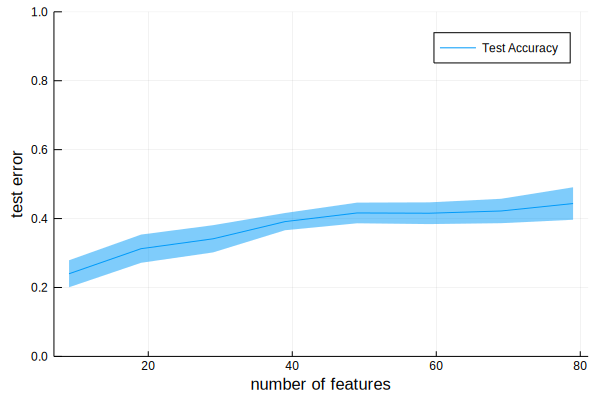

In [13]:
plot(ds,mean_acc_good,ribbon=std_acc_good,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

In [28]:
#V6, backslash

ntrain=500
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=100:100:800
nreps = 4

accs_back = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        #W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true)
        w0 = phiXtrain\psiTrain_samp[:, 1]
        w1 = phiXtrain\psiTrain_samp[:, 2]
        w2 = phiXtrain\psiTrain_samp[:, 3]
        w3 = phiXtrain\psiTrain_samp[:, 4]
        w4 = phiXtrain\psiTrain_samp[:, 5]
        w5 = phiXtrain\psiTrain_samp[:, 6]
        w6 = phiXtrain\psiTrain_samp[:, 7]
        w7 = phiXtrain\psiTrain_samp[:, 8]
        w8 = phiXtrain\psiTrain_samp[:, 9]
        w9 = phiXtrain\psiTrain_samp[:, 10]
        
        W = hcat(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W))
        println(acc_new)
        push!(acc, acc_new)
    end
    accs_back[:,rep] = acc
end
mean_acc_back = mean(accs_back,dims=2)
std_acc_back = std(accs_back,dims=2);

100
0.654
200
0.678
300
0.682
400
0.572
500
0.168
600
0.586
700
0.672
800
0.716
100
0.652
200
0.696
300
0.69
400
0.582
500
0.1
600
0.538
700
0.636
800
0.724
100
0.682
200
0.702
300
0.648
400
0.53
500
0.092
600
0.54
700
0.662
800
0.734
100
0.664
200
0.71
300
0.664
400
0.558
500
0.13
600
0.594
700
0.652
800
0.744
 86.274750 seconds (822.06 k allocations: 1.695 GiB, 1.41% gc time)


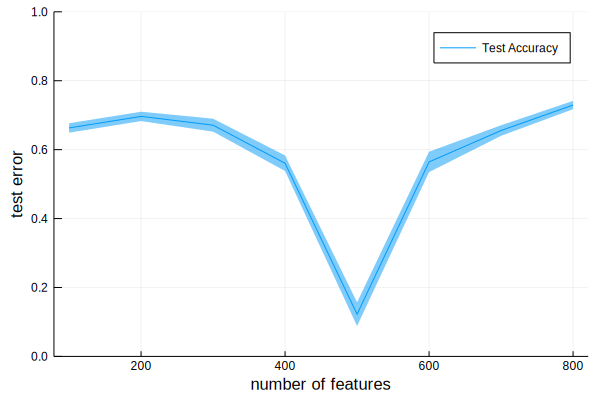

In [29]:
plot(ds,mean_acc_back,ribbon=std_acc_back,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

In [13]:
#V7, training until convergence, with regularizer

ntrain=50
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=9:10:79
nreps = 20

accs_reg = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true, 0.1)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_reg[:,rep] = acc
end
mean_acc_reg = mean(accs_reg,dims=2)
std_acc_reg = std(accs_reg,dims=2);

9


Iteration
1
Loss
872.1002979080275
Train Accuracy
0.1
Magic constant
0.010000000000000002


Iteration
2
Loss
776.9898359780889
Train Accuracy
0.1
Magic constant
0.010000000000000002


Iteration
3
Loss
693.9336246395186
Train Accuracy
0.12
Magic constant
0.010000000000000002


Iteration
4
Loss
623.5540216965496
Train Accuracy
0.12
Magic constant
0.010000000000000002


Iteration
5
Loss
557.4267135763163
Train Accuracy
0.12
Magic constant
0.010000000000000002


Iteration
6
Loss
504.45308996178903
Train Accuracy
0.14
Magic constant
0.010000000000000002


Iteration
7
Loss
454.7156764716784
Train Accuracy
0.12
Magic constant
0.010000000000000002


Iteration
8
Loss
408.1721073388369
Train Accuracy
0.14
Magic constant
0.010000000000000002


Iteration
9
Loss
365.9969451245771
Train Accuracy
0.14
Magic constant
0.010000000000000002


Iteration
10
Loss
329.20227569556545
Train Accuracy
0.14
Magic constant
0.010000000000000002


Iteration
11
Loss
297.4754823048149
Train Accuracy
0.16
Magic con

162
Loss
104.702901765178
Train Accuracy
0.62
Magic constant
0.006666666666666668


Iteration
163
Loss
112.50624073499854
Train Accuracy
0.56
Magic constant
0.006666666666666668


Iteration
164
Loss
108.10133417823236
Train Accuracy
0.58
Magic constant
0.006666666666666668


Iteration
165
Loss
104.81262633225688
Train Accuracy
0.58
Magic constant
0.006666666666666668


Iteration
166
Loss
107.84975610632773
Train Accuracy
0.54
Magic constant
0.006666666666666668


Iteration
167
Loss
104.56964801258198
Train Accuracy
0.6
Magic constant
0.006666666666666668


Iteration
168
Loss
107.86475055612644
Train Accuracy
0.58
Magic constant
0.006666666666666668


Iteration
169
Loss
104.70931224685718
Train Accuracy
0.62
Magic constant
0.006666666666666668


Iteration
170
Loss
108.51285571202546
Train Accuracy
0.54
Magic constant
0.006666666666666668


Iteration
171
Loss
104.89329244533734
Train Accuracy
0.56
Magic constant
0.006666666666666668


Iteration
172
Loss
104.83674577696756
Train Accuracy


Magic constant
0.004000000000000001


Iteration
313
Loss
100.40537877699913
Train Accuracy
0.6
Magic constant
0.004000000000000001


Iteration
314
Loss
101.62171189190195
Train Accuracy
0.62
Magic constant
0.004000000000000001


Iteration
315
Loss
100.35115516350719
Train Accuracy
0.62
Magic constant
0.004000000000000001


Iteration
316
Loss
102.38261461653748
Train Accuracy
0.58
Magic constant
0.004000000000000001


Iteration
317
Loss
100.47189696617356
Train Accuracy
0.6
Magic constant
0.004000000000000001


Iteration
318
Loss
101.33539721518757
Train Accuracy
0.62
Magic constant
0.004000000000000001


Iteration
319
Loss
100.16581227193724
Train Accuracy
0.62
Magic constant
0.004000000000000001


Iteration
320
Loss
102.58571476911978
Train Accuracy
0.58
Magic constant
0.004000000000000001


Iteration
321
Loss
100.88362475801031
Train Accuracy
0.58
Magic constant
0.004000000000000001


Iteration
322
Loss
100.15264967543318
Train Accuracy
0.6
Magic constant
0.004000000000000001


Itera

Iteration
495
Loss
98.42499481503027
Train Accuracy
0.56
Magic constant
0.003333333333333334


Iteration
496
Loss
97.36362493591686
Train Accuracy
0.6
Magic constant
0.003333333333333334


Iteration
497
Loss
98.4413144839574
Train Accuracy
0.6
Magic constant
0.003333333333333334


Iteration
498
Loss
97.41062601967296
Train Accuracy
0.6
Magic constant
0.003333333333333334


Iteration
499
Loss
98.28935879746093
Train Accuracy
0.6
Magic constant
0.003333333333333334


Iteration
500
Loss
97.2732711006097
Train Accuracy
0.62
Magic constant
0.0028571428571428576


Iteration
501
Loss
97.73744474131898
Train Accuracy
0.6
Magic constant
0.0028571428571428576


Iteration
502
Loss
97.3910307834022
Train Accuracy
0.6
Magic constant
0.0028571428571428576


Iteration
503
Loss
98.12701444405394
Train Accuracy
0.6
Magic constant
0.0028571428571428576


Iteration
504
Loss
97.25035619094385
Train Accuracy
0.64
Magic constant
0.0028571428571428576


Iteration
505
Loss
97.92603091092138
Train Accuracy
0.5

Magic constant
0.0025000000000000005


Iteration
603
Loss
97.6049456809934
Train Accuracy
0.58
Magic constant
0.0025000000000000005


Iteration
604
Loss
96.7327125598165
Train Accuracy
0.58
Magic constant
0.0025000000000000005


Iteration
605
Loss
97.06109008312585
Train Accuracy
0.58
Magic constant
0.0025000000000000005


Iteration
606
Loss
96.59287871112342
Train Accuracy
0.6
Magic constant
0.0025000000000000005


Iteration
607
Loss
97.40256232069902
Train Accuracy
0.6
Magic constant
0.0025000000000000005


Iteration
608
Loss
96.66752968447595
Train Accuracy
0.6
Magic constant
0.0025000000000000005


Iteration
609
Loss
96.92075413249835
Train Accuracy
0.6
Magic constant
0.0025000000000000005


Iteration
610
Loss
96.66611792766551
Train Accuracy
0.6
Magic constant
0.0025000000000000005


Iteration
611
Loss
96.8132194496882
Train Accuracy
0.6
Magic constant
0.0025000000000000005


Iteration
612
Loss
97.15527733793466
Train Accuracy
0.58
Magic constant
0.0025000000000000005


Iteration


0.0022222222222222227


Iteration
720
Loss
95.7861223513409
Train Accuracy
0.62
Magic constant
0.0022222222222222227


Iteration
721
Loss
96.18152806753663
Train Accuracy
0.64
Magic constant
0.0022222222222222227


Iteration
722
Loss
95.81441666257079
Train Accuracy
0.6
Magic constant
0.0022222222222222227


Iteration
723
Loss
96.42396969744176
Train Accuracy
0.6
Magic constant
0.0022222222222222227


Iteration
724
Loss
95.74873822557923
Train Accuracy
0.6
Magic constant
0.0022222222222222227


Iteration
725
Loss
96.30525791631577
Train Accuracy
0.58
Magic constant
0.0022222222222222227


Iteration
726
Loss
95.81771132972662
Train Accuracy
0.62
Magic constant
0.0022222222222222227


Iteration
727
Loss
96.02159355924167
Train Accuracy
0.58
Magic constant
0.0022222222222222227


Iteration
728
Loss
95.71554427330551
Train Accuracy
0.6
Magic constant
0.0022222222222222227


Iteration
729
Loss
96.79351642085655
Train Accuracy
0.58
Magic constant
0.0022222222222222227


Iteration
730
Loss
95

Iteration
841
Loss
95.35767076140895
Train Accuracy
0.62
Magic constant
0.0020000000000000005


Iteration
842
Loss
95.25379285493838
Train Accuracy
0.6
Magic constant
0.0020000000000000005


Iteration
843
Loss
95.19338985155893
Train Accuracy
0.62
Magic constant
0.0020000000000000005


Iteration
844
Loss
95.37158788520979
Train Accuracy
0.6
Magic constant
0.0020000000000000005


Iteration
845
Loss
95.06532991136292
Train Accuracy
0.62
Magic constant
0.0020000000000000005


Iteration
846
Loss
96.08956490411018
Train Accuracy
0.6
Magic constant
0.0020000000000000005


Iteration
847
Loss
95.22108869143622
Train Accuracy
0.6
Magic constant
0.0020000000000000005


Iteration
848
Loss
95.09712800968539
Train Accuracy
0.62
Magic constant
0.0020000000000000005


Iteration
849
Loss
95.46788326341694
Train Accuracy
0.6
Magic constant
0.0020000000000000005


Iteration
850
Loss
95.04956487539907
Train Accuracy
0.62
Magic constant
0.0020000000000000005


Iteration
851
Loss
96.32644907982258
Train Ac

0.0018181818181818186


Iteration
954
Loss
94.47853993227366
Train Accuracy
0.62
Magic constant
0.0018181818181818186


Iteration
955
Loss
94.84759152628574
Train Accuracy
0.6
Magic constant
0.0018181818181818186


Iteration
956
Loss
94.49234380516009
Train Accuracy
0.62
Magic constant
0.0018181818181818186


Iteration
957
Loss
94.97886953137744
Train Accuracy
0.58
Magic constant
0.0018181818181818186


Iteration
958
Loss
94.51671446565139
Train Accuracy
0.62
Magic constant
0.0018181818181818186


Iteration
959
Loss
94.91690019707782
Train Accuracy
0.6
Magic constant
0.0018181818181818186


Iteration
960
Loss
94.42487203164845
Train Accuracy
0.62
Magic constant
0.0018181818181818186


Iteration
961
Loss
94.80394701338834
Train Accuracy
0.62
Magic constant
0.0018181818181818186


Iteration
962
Loss
94.52979615431164
Train Accuracy
0.62
Magic constant
0.0018181818181818186


Iteration
963
Loss
94.87608879809112
Train Accuracy
0.6
Magic constant
0.0018181818181818186


Iteration
964
Loss


100
Loss
66.57927726589578
Train Accuracy
0.78
Magic constant
0.006666666666666668


Iteration
101
Loss
67.28310884596942
Train Accuracy
0.8
Magic constant
0.006666666666666668


Iteration
102
Loss
65.90424255628271
Train Accuracy
0.8
Magic constant
0.006666666666666668


Iteration
103
Loss
66.89519560512161
Train Accuracy
0.78
Magic constant
0.006666666666666668


Iteration
104
Loss
65.12157881673866
Train Accuracy
0.8
Magic constant
0.006666666666666668


Iteration
105
Loss
67.17680011362216
Train Accuracy
0.78
Magic constant
0.006666666666666668


Iteration
106
Loss
65.44480686044837
Train Accuracy
0.8
Magic constant
0.006666666666666668


Iteration
107
Loss
65.40584397208697
Train Accuracy
0.78
Magic constant
0.006666666666666668


Iteration
108
Loss
66.2491225565359
Train Accuracy
0.8
Magic constant
0.006666666666666668


Iteration
109
Loss
65.02136687790524
Train Accuracy
0.8
Magic constant
0.006666666666666668


Iteration
110
Loss
67.47831964683405
Train Accuracy
0.78
Magic cons

0.8
Magic constant
0.005000000000000001


Iteration
257
Loss
64.76981500449634
Train Accuracy
0.82
Magic constant
0.005000000000000001


Iteration
258
Loss
64.4524220636601
Train Accuracy
0.78
Magic constant
0.005000000000000001


Iteration
259
Loss
65.55496012961349
Train Accuracy
0.82
Magic constant
0.005000000000000001


Iteration
260
Loss
64.55142080694611
Train Accuracy
0.8
Magic constant
0.005000000000000001


Iteration
261
Loss
65.08640173904256
Train Accuracy
0.82
Magic constant
0.005000000000000001


Iteration
262
Loss
64.65519678234911
Train Accuracy
0.8
Magic constant
0.005000000000000001


Iteration
263
Loss
65.19915152201638
Train Accuracy
0.8
Magic constant
0.005000000000000001


Iteration
264
Loss
64.4806206829841
Train Accuracy
0.8
Magic constant
0.005000000000000001


Iteration
265
Loss
65.30346477283952
Train Accuracy
0.82
Magic constant
0.005000000000000001


Iteration
266
Loss
64.6139153524302
Train Accuracy
0.84
Magic constant
0.005000000000000001


Iteration
267
L

Magic constant
0.004000000000000001


Iteration
345
Loss
64.4208795980332
Train Accuracy
0.8
Magic constant
0.004000000000000001


Iteration
346
Loss
64.6352411733901
Train Accuracy
0.78
Magic constant
0.004000000000000001


Iteration
347
Loss
64.32135096524132
Train Accuracy
0.8
Magic constant
0.004000000000000001


Iteration
348
Loss
64.86853525417203
Train Accuracy
0.82
Magic constant
0.004000000000000001


Iteration
349
Loss
64.44701799239239
Train Accuracy
0.8
Magic constant
0.004000000000000001


Iteration
350
Loss
65.10266419787355
Train Accuracy
0.82
Magic constant
0.004000000000000001


Iteration
351
Loss
64.25419125410326
Train Accuracy
0.8
Magic constant
0.004000000000000001


Iteration
352
Loss
64.8111272818659
Train Accuracy
0.8
Magic constant
0.004000000000000001


Iteration
353
Loss
64.26600913303915
Train Accuracy
0.8
Magic constant
0.004000000000000001


Iteration
354
Loss
64.68654517174389
Train Accuracy
0.8
Magic constant
0.004000000000000001


Iteration
355
Loss
64.

64.33421001885766
Train Accuracy
0.8
Magic constant
0.0028571428571428576


Iteration
506
Loss
64.71810505686238
Train Accuracy
0.8
Magic constant
0.0028571428571428576


Iteration
507
Loss
64.22596318520603
Train Accuracy
0.8
Magic constant
0.0028571428571428576


Iteration
508
Loss
64.55469928632175
Train Accuracy
0.8
Magic constant
0.0028571428571428576


Iteration
509
Loss
64.2822363755093
Train Accuracy
0.8
Magic constant
0.0028571428571428576


Iteration
510
Loss
64.36587353755768
Train Accuracy
0.8
Magic constant
0.0028571428571428576


Iteration
511
Loss
64.23595381507693
Train Accuracy
0.8
Magic constant
0.0028571428571428576


Iteration
512
Loss
64.4406273283014
Train Accuracy
0.8
Magic constant
0.0028571428571428576


Iteration
513
Loss
64.22504593478142
Train Accuracy
0.8
Magic constant
0.0028571428571428576


Iteration
514
Loss
64.9573428885994
Train Accuracy
0.8
Magic constant
0.0028571428571428576


Iteration
515
Loss
64.32923052380099
Train Accuracy
0.8
Magic constant
0

Magic constant
0.0025000000000000005


Iteration
670
Loss
64.12935832687134
Train Accuracy
0.8
Magic constant
0.0025000000000000005


Iteration
671
Loss
64.37032461484195
Train Accuracy
0.8
Magic constant
0.0025000000000000005


Iteration
672
Loss
64.0676305676935
Train Accuracy
0.8
Magic constant
0.0025000000000000005


Iteration
673
Loss
64.63039655182726
Train Accuracy
0.8
Magic constant
0.0025000000000000005


Iteration
674
Loss
64.09748333607259
Train Accuracy
0.8
Magic constant
0.0025000000000000005


Iteration
675
Loss
64.12742678330821
Train Accuracy
0.8
Magic constant
0.0025000000000000005


Iteration
676
Loss
64.21221801024355
Train Accuracy
0.8
Magic constant
0.0025000000000000005


Iteration
677
Loss
64.05662838398736
Train Accuracy
0.8
Magic constant
0.0025000000000000005


Iteration
678
Loss
64.51223786826607
Train Accuracy
0.8
Magic constant
0.0025000000000000005


Iteration
679
Loss
64.0879402341421
Train Accuracy
0.8
Magic constant
0.0025000000000000005


Iteration
680



Iteration
760
Loss
64.11365010393732
Train Accuracy
0.8
Magic constant
0.0022222222222222227


Iteration
761
Loss
63.91138435906015
Train Accuracy
0.8
Magic constant
0.0022222222222222227


Iteration
762
Loss
64.40704755113074
Train Accuracy
0.8
Magic constant
0.0022222222222222227


Iteration
763
Loss
63.979453590198865
Train Accuracy
0.8
Magic constant
0.0022222222222222227


Iteration
764
Loss
63.85070773802154
Train Accuracy
0.8
Magic constant
0.0022222222222222227


Iteration
765
Loss
64.0534318874009
Train Accuracy
0.8
Magic constant
0.0022222222222222227


Iteration
766
Loss
63.86617586175096
Train Accuracy
0.8
Magic constant
0.0022222222222222227


Iteration
767
Loss
64.59143587328629
Train Accuracy
0.8
Magic constant
0.0022222222222222227


Iteration
768
Loss
64.07545175672996
Train Accuracy
0.8
Magic constant
0.0022222222222222227


Iteration
769
Loss
63.88351461082809
Train Accuracy
0.8
Magic constant
0.0022222222222222227


Iteration
770
Loss
64.36488301504609
Train Accur

0.0020000000000000005


Iteration
855
Loss
63.740247695799404
Train Accuracy
0.8
Magic constant
0.0020000000000000005


Iteration
856
Loss
63.99293685497009
Train Accuracy
0.8
Magic constant
0.0020000000000000005


Iteration
857
Loss
63.700773376736734
Train Accuracy
0.8
Magic constant
0.0020000000000000005


Iteration
858
Loss
64.04635364533037
Train Accuracy
0.8
Magic constant
0.0020000000000000005


Iteration
859
Loss
63.759604049314994
Train Accuracy
0.8
Magic constant
0.0020000000000000005


Iteration
860
Loss
63.96170444061265
Train Accuracy
0.8
Magic constant
0.0020000000000000005


Iteration
861
Loss
63.737158476422586
Train Accuracy
0.8
Magic constant
0.0020000000000000005


Iteration
862
Loss
64.1499831879049
Train Accuracy
0.8
Magic constant
0.0020000000000000005


Iteration
863
Loss
63.76107415845875
Train Accuracy
0.8
Magic constant
0.0020000000000000005


Iteration
864
Loss
63.919977805183144
Train Accuracy
0.8
Magic constant
0.0020000000000000005


Iteration
865
Loss
63.

29


Iteration
1
Loss
2164.0556585421905
Train Accuracy
0.16
Magic constant
0.010000000000000002


Iteration
2
Loss
1917.464746520007
Train Accuracy
0.18
Magic constant
0.010000000000000002


Iteration
3
Loss
1700.6660955106731
Train Accuracy
0.2
Magic constant
0.010000000000000002


Iteration
4
Loss
1506.6269279636608
Train Accuracy
0.2
Magic constant
0.010000000000000002


Iteration
5
Loss
1337.041295407583
Train Accuracy
0.18
Magic constant
0.010000000000000002


Iteration
6
Loss
1185.8822010862148
Train Accuracy
0.18
Magic constant
0.010000000000000002


Iteration
7
Loss
1053.2979156643635
Train Accuracy
0.2
Magic constant
0.010000000000000002


Iteration
8
Loss
936.1855154756103
Train Accuracy
0.2
Magic constant
0.010000000000000002


Iteration
9
Loss
832.943039210995
Train Accuracy
0.24
Magic constant
0.010000000000000002


Iteration
10
Loss
741.4115147170764
Train Accuracy
0.24
Magic constant
0.010000000000000002


Iteration
11
Loss
659.5496580691231
Train Accuracy
0.22
Magic co

Magic constant
0.006666666666666668


Iteration
116
Loss
67.30388392532743
Train Accuracy
0.82
Magic constant
0.006666666666666668


Iteration
117
Loss
66.25679214040734
Train Accuracy
0.86
Magic constant
0.006666666666666668


Iteration
118
Loss
69.36136815784135
Train Accuracy
0.86
Magic constant
0.006666666666666668


Iteration
119
Loss
67.37267074075818
Train Accuracy
0.86
Magic constant
0.006666666666666668


Iteration
120
Loss
66.08370849522233
Train Accuracy
0.86
Magic constant
0.006666666666666668


Iteration
121
Loss
68.6496564375146
Train Accuracy
0.86
Magic constant
0.006666666666666668


Iteration
122
Loss
66.56181141600085
Train Accuracy
0.88
Magic constant
0.006666666666666668


Iteration
123
Loss
67.10195363195037
Train Accuracy
0.8
Magic constant
0.006666666666666668


Iteration
124
Loss
66.12234295504437
Train Accuracy
0.86
Magic constant
0.006666666666666668


Iteration
125
Loss
67.93671304756907
Train Accuracy
0.78
Magic constant
0.006666666666666668


Iteration
126


262
Loss
70.1674429873815
Train Accuracy
0.9
Magic constant
0.005000000000000001


Iteration
263
Loss
70.20348420819928
Train Accuracy
0.9
Magic constant
0.005000000000000001


Iteration
264
Loss
69.77482160084355
Train Accuracy
0.9
Magic constant
0.005000000000000001


Iteration
265
Loss
71.46497947489631
Train Accuracy
0.86
Magic constant
0.005000000000000001


Iteration
266
Loss
70.12042166517483
Train Accuracy
0.88
Magic constant
0.005000000000000001


Iteration
267
Loss
70.2621264516185
Train Accuracy
0.88
Magic constant
0.005000000000000001


Iteration
268
Loss
70.14004782994829
Train Accuracy
0.9
Magic constant
0.005000000000000001


Iteration
269
Loss
70.4654764843229
Train Accuracy
0.9
Magic constant
0.005000000000000001


Iteration
270
Loss
70.16007726932165
Train Accuracy
0.9
Magic constant
0.005000000000000001


Iteration
271
Loss
70.54688087089318
Train Accuracy
0.84
Magic constant
0.005000000000000001


Iteration
272
Loss
70.06294727044384
Train Accuracy
0.92
Magic consta

Iteration
420
Loss
70.3578044422814
Train Accuracy
0.9
Magic constant
0.003333333333333334


Iteration
421
Loss
70.42232847263485
Train Accuracy
0.9
Magic constant
0.003333333333333334


Iteration
422
Loss
70.18710559336006
Train Accuracy
0.9
Magic constant
0.003333333333333334


Iteration
423
Loss
70.93225040511882
Train Accuracy
0.9
Magic constant
0.003333333333333334


Iteration
424
Loss
70.28265420274496
Train Accuracy
0.9
Magic constant
0.003333333333333334


Iteration
425
Loss
70.45203433808435
Train Accuracy
0.86
Magic constant
0.003333333333333334


Iteration
426
Loss
70.361190212189
Train Accuracy
0.88
Magic constant
0.003333333333333334


Iteration
427
Loss
70.58242190272503
Train Accuracy
0.88
Magic constant
0.003333333333333334


Iteration
428
Loss
70.1351274579298
Train Accuracy
0.9
Magic constant
0.003333333333333334


Iteration
429
Loss
71.18584715320685
Train Accuracy
0.88
Magic constant
0.003333333333333334


Iteration
430
Loss
70.24609457922975
Train Accuracy
0.88
Mag

0.0028571428571428576


Iteration
554
Loss
69.83976009529708
Train Accuracy
0.9
Magic constant
0.0028571428571428576


Iteration
555
Loss
70.76022729369166
Train Accuracy
0.88
Magic constant
0.0028571428571428576


Iteration
556
Loss
70.06594403101975
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
557
Loss
69.98623237451261
Train Accuracy
0.88
Magic constant
0.0028571428571428576


Iteration
558
Loss
70.19180624309888
Train Accuracy
0.9
Magic constant
0.0028571428571428576


Iteration
559
Loss
69.86742157948584
Train Accuracy
0.88
Magic constant
0.0028571428571428576


Iteration
560
Loss
70.4348363135655
Train Accuracy
0.88
Magic constant
0.0028571428571428576


Iteration
561
Loss
69.92198120134877
Train Accuracy
0.9
Magic constant
0.0028571428571428576


Iteration
562
Loss
70.7018228860767
Train Accuracy
0.86
Magic constant
0.0028571428571428576


Iteration
563
Loss
70.10508142416228
Train Accuracy
0.86
Magic constant
0.0028571428571428576


Iteration
564
Loss
70

Loss
70.52629407199294
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
675
Loss
69.87644089155242
Train Accuracy
0.86
Magic constant
0.0025000000000000005


Iteration
676
Loss
69.81849719572696
Train Accuracy
0.9
Magic constant
0.0025000000000000005


Iteration
677
Loss
70.20653993537249
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
678
Loss
69.78197740525412
Train Accuracy
0.9
Magic constant
0.0025000000000000005


Iteration
679
Loss
70.14171949217744
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
680
Loss
69.80940523569721
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
681
Loss
70.15757070611475
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
682
Loss
69.74933986205417
Train Accuracy
0.9
Magic constant
0.0025000000000000005


Iteration
683
Loss
70.71607805133237
Train Accuracy
0.9
Magic constant
0.0025000000000000005


Iteration
684
Loss
70.03475216742962
Train Accuracy
0.9
Ma

Magic constant
0.0020000000000000005


Iteration
809
Loss
69.58299543133205
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
810
Loss
70.19955754879811
Train Accuracy
0.88
Magic constant
0.0020000000000000005


Iteration
811
Loss
69.74257703129763
Train Accuracy
0.88
Magic constant
0.0020000000000000005


Iteration
812
Loss
69.55609885262211
Train Accuracy
0.9
Magic constant
0.0020000000000000005


Iteration
813
Loss
70.07404472439484
Train Accuracy
0.88
Magic constant
0.0020000000000000005


Iteration
814
Loss
69.64729423726334
Train Accuracy
0.88
Magic constant
0.0020000000000000005


Iteration
815
Loss
69.69183739611331
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
816
Loss
69.6262318357036
Train Accuracy
0.9
Magic constant
0.0020000000000000005


Iteration
817
Loss
69.65068028221052
Train Accuracy
0.88
Magic constant
0.0020000000000000005


Iteration
818
Loss
69.67497762274498
Train Accuracy
0.88
Magic constant
0.0020000000000000005


Iter

Iteration
929
Loss
69.54968535052852
Train Accuracy
0.88
Magic constant
0.0018181818181818186


Iteration
930
Loss
69.43808034352014
Train Accuracy
0.9
Magic constant
0.0018181818181818186


Iteration
931
Loss
69.54873201445234
Train Accuracy
0.88
Magic constant
0.0018181818181818186


Iteration
932
Loss
69.48391737092861
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
933
Loss
69.63072083293345
Train Accuracy
0.88
Magic constant
0.0018181818181818186


Iteration
934
Loss
69.42952810906056
Train Accuracy
0.88
Magic constant
0.0018181818181818186


Iteration
935
Loss
69.71051239015429
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
936
Loss
69.42594228117738
Train Accuracy
0.9
Magic constant
0.0018181818181818186


Iteration
937
Loss
69.93445793506788
Train Accuracy
0.9
Magic constant
0.0018181818181818186


Iteration
938
Loss
69.51478929798326
Train Accuracy
0.9
Magic constant
0.0018181818181818186


Iteration
939
Loss
69.41539848235983
Train A

79
Loss
47.66013393255192
Train Accuracy
0.92
Magic constant
0.010000000000000002


Iteration
80
Loss
46.984275920758186
Train Accuracy
0.96
Magic constant
0.010000000000000002


Iteration
81
Loss
47.618845088902226
Train Accuracy
0.9
Magic constant
0.010000000000000002


Iteration
82
Loss
46.91100937780578
Train Accuracy
0.94
Magic constant
0.010000000000000002


Iteration
83
Loss
47.799374845662726
Train Accuracy
0.94
Magic constant
0.010000000000000002


Iteration
84
Loss
46.9426660727627
Train Accuracy
0.94
Magic constant
0.010000000000000002


Iteration
85
Loss
48.446466062514055
Train Accuracy
0.9
Magic constant
0.010000000000000002


Iteration
86
Loss
47.55136857639332
Train Accuracy
0.96
Magic constant
0.010000000000000002


Iteration
87
Loss
48.91478170298685
Train Accuracy
0.94
Magic constant
0.010000000000000002


Iteration
88
Loss
47.66018921011804
Train Accuracy
0.96
Magic constant
0.010000000000000002


Iteration
89
Loss
48.63184275583526
Train Accuracy
0.94
Magic constan

Iteration
219
Loss
49.727963560524046
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
220
Loss
49.131181046762045
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
221
Loss
49.49359427808851
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
222
Loss
49.20232112468338
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
223
Loss
49.24814409977928
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
224
Loss
49.93065414965522
Train Accuracy
0.94
Magic constant
0.005000000000000001


Iteration
225
Loss
49.37345933637101
Train Accuracy
0.94
Magic constant
0.005000000000000001


Iteration
226
Loss
49.60413829844284
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
227
Loss
49.437862110747
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
228
Loss
49.71321337648961
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
229
Loss
49.461088721844845
Train Accura

Magic constant
0.004000000000000001


Iteration
370
Loss
51.49236285304626
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
371
Loss
51.25761514448854
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
372
Loss
51.63388400863275
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
373
Loss
51.107351033140304
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
374
Loss
51.33018391298795
Train Accuracy
0.96
Magic constant
0.004000000000000001


Iteration
375
Loss
51.219522247635524
Train Accuracy
0.96
Magic constant
0.004000000000000001


Iteration
376
Loss
51.16528957606663
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
377
Loss
51.705202495258426
Train Accuracy
0.96
Magic constant
0.004000000000000001


Iteration
378
Loss
51.21178133664133
Train Accuracy
0.96
Magic constant
0.004000000000000001


Iteration
379
Loss
51.31769542534034
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration

Magic constant
0.0028571428571428576


Iteration
529
Loss
51.42479191500508
Train Accuracy
0.98
Magic constant
0.0028571428571428576


Iteration
530
Loss
51.1681541388936
Train Accuracy
0.98
Magic constant
0.0028571428571428576


Iteration
531
Loss
51.48369198009564
Train Accuracy
0.98
Magic constant
0.0028571428571428576


Iteration
532
Loss
51.15875599636129
Train Accuracy
0.98
Magic constant
0.0028571428571428576


Iteration
533
Loss
51.322971735036546
Train Accuracy
0.98
Magic constant
0.0028571428571428576


Iteration
534
Loss
51.2204730862645
Train Accuracy
0.98
Magic constant
0.0028571428571428576


Iteration
535
Loss
51.446541944778325
Train Accuracy
0.98
Magic constant
0.0028571428571428576


Iteration
536
Loss
51.14260335560602
Train Accuracy
0.98
Magic constant
0.0028571428571428576


Iteration
537
Loss
51.363311499418074
Train Accuracy
0.98
Magic constant
0.0028571428571428576


Iteration
538
Loss
51.12828995656321
Train Accuracy
0.98
Magic constant
0.0028571428571428576




Magic constant
0.0025000000000000005


Iteration
689
Loss
51.302586216439394
Train Accuracy
0.96
Magic constant
0.0025000000000000005


Iteration
690
Loss
51.22921841615711
Train Accuracy
0.98
Magic constant
0.0025000000000000005


Iteration
691
Loss
51.26907816705215
Train Accuracy
0.98
Magic constant
0.0025000000000000005


Iteration
692
Loss
51.17122609618469
Train Accuracy
0.98
Magic constant
0.0025000000000000005


Iteration
693
Loss
51.48713702552352
Train Accuracy
0.98
Magic constant
0.0025000000000000005


Iteration
694
Loss
51.19693026854242
Train Accuracy
0.98
Magic constant
0.0025000000000000005


Iteration
695
Loss
51.21032771783866
Train Accuracy
0.98
Magic constant
0.0025000000000000005


Iteration
696
Loss
51.305980370197894
Train Accuracy
0.98
Magic constant
0.0025000000000000005


Iteration
697
Loss
51.19315799501294
Train Accuracy
0.98
Magic constant
0.0025000000000000005


Iteration
698
Loss
51.498059079686826
Train Accuracy
0.98
Magic constant
0.0025000000000000005


Magic constant
0.0020000000000000005


Iteration
840
Loss
51.02386515026032
Train Accuracy
0.98
Magic constant
0.0020000000000000005


Iteration
841
Loss
50.825636887557096
Train Accuracy
0.98
Magic constant
0.0020000000000000005


Iteration
842
Loss
50.90366684946634
Train Accuracy
0.98
Magic constant
0.0020000000000000005


Iteration
843
Loss
50.778968973357756
Train Accuracy
0.98
Magic constant
0.0020000000000000005


Iteration
844
Loss
50.97421946324863
Train Accuracy
0.98
Magic constant
0.0020000000000000005


Iteration
845
Loss
50.803958685496745
Train Accuracy
0.98
Magic constant
0.0020000000000000005


Iteration
846
Loss
51.06380360709174
Train Accuracy
0.98
Magic constant
0.0020000000000000005


Iteration
847
Loss
50.85951780421235
Train Accuracy
0.98
Magic constant
0.0020000000000000005


Iteration
848
Loss
50.968656194586714
Train Accuracy
0.98
Magic constant
0.0020000000000000005


Iteration
849
Loss
50.82618253302801
Train Accuracy
0.98
Magic constant
0.0020000000000000005

Magic constant
0.0018181818181818186


Iteration
928
Loss
50.74235422383783
Train Accuracy
0.98
Magic constant
0.0018181818181818186


Iteration
929
Loss
50.64037006305385
Train Accuracy
0.98
Magic constant
0.0018181818181818186


Iteration
930
Loss
50.94774270147543
Train Accuracy
0.98
Magic constant
0.0018181818181818186


Iteration
931
Loss
50.72297359999874
Train Accuracy
0.98
Magic constant
0.0018181818181818186


Iteration
932
Loss
50.68319884100033
Train Accuracy
0.98
Magic constant
0.0018181818181818186


Iteration
933
Loss
50.88806640584595
Train Accuracy
0.98
Magic constant
0.0018181818181818186


Iteration
934
Loss
50.70318702376726
Train Accuracy
0.98
Magic constant
0.0018181818181818186


Iteration
935
Loss
50.754203942383164
Train Accuracy
0.98
Magic constant
0.0018181818181818186


Iteration
936
Loss
50.657809125119655
Train Accuracy
0.98
Magic constant
0.0018181818181818186


Iteration
937
Loss
50.778799598544
Train Accuracy
0.98
Magic constant
0.0018181818181818186


I

Magic constant
0.010000000000000002


Iteration
75
Loss
52.95462145323477
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
76
Loss
54.09422775740504
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
77
Loss
52.06006081257421
Train Accuracy
0.92
Magic constant
0.010000000000000002


Iteration
78
Loss
53.55281002811742
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
79
Loss
51.406314622003194
Train Accuracy
0.92
Magic constant
0.010000000000000002


Iteration
80
Loss
52.255612838751745
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
81
Loss
52.73410906075065
Train Accuracy
0.92
Magic constant
0.010000000000000002


Iteration
82
Loss
51.15055421211938
Train Accuracy
0.9
Magic constant
0.010000000000000002


Iteration
83
Loss
53.9285788908696
Train Accuracy
0.9
Magic constant
0.010000000000000002


Iteration
84
Loss
51.21086078206747
Train Accuracy
0.92
Magic constant
0.010000000000000002


Iteration
85
Loss
51.66

Magic constant
0.005000000000000001


Iteration
219
Loss
54.3464016174813
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
220
Loss
54.12741237970139
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
221
Loss
55.034671721804855
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
222
Loss
54.13280159205801
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
223
Loss
54.18783334324052
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
224
Loss
55.16520183902682
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
225
Loss
54.38082719559335
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
226
Loss
54.21303062453733
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
227
Loss
55.60938967878594
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
228
Loss
54.75316186786333
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
22

Magic constant
0.004000000000000001


Iteration
366
Loss
57.20283110826003
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
367
Loss
56.90099649987786
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
368
Loss
56.90522071656271
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
369
Loss
57.43988384991902
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
370
Loss
56.96209256364073
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
371
Loss
57.63090363841018
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
372
Loss
56.96290898937944
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
373
Loss
56.992007234087424
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
374
Loss
57.149966550063866
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
375
Loss
57.0473590598219
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
3

Magic constant
0.0028571428571428576


Iteration
507
Loss
57.66484402345573
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
508
Loss
57.56667726452145
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
509
Loss
58.34003313509278
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
510
Loss
57.909083539717024
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
511
Loss
57.5701934849294
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
512
Loss
57.98136180725531
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
513
Loss
57.5881531206044
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
514
Loss
58.281397009350584
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
515
Loss
57.773746187606534
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
516
Loss
57.69305234165952
Train Accuracy
0.92
Magic constant
0.0028571428571428576




Magic constant
0.0025000000000000005


Iteration
616
Loss
58.33658426139291
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
617
Loss
57.915617889430095
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
618
Loss
57.905026223915335
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
619
Loss
58.17479944442661
Train Accuracy
0.9
Magic constant
0.0025000000000000005


Iteration
620
Loss
57.8310207833595
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
621
Loss
58.06783093096689
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
622
Loss
57.765481828235835
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
623
Loss
57.92418295401218
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
624
Loss
57.845770600386224
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
625
Loss
58.09851274900687
Train Accuracy
0.92
Magic constant
0.0025000000000000005



Magic constant
0.0022222222222222227


Iteration
716
Loss
57.83823871817283
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
717
Loss
58.227291338927635
Train Accuracy
0.9
Magic constant
0.0022222222222222227


Iteration
718
Loss
57.92846674151787
Train Accuracy
0.9
Magic constant
0.0022222222222222227


Iteration
719
Loss
58.00202255820193
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
720
Loss
57.998023578688574
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
721
Loss
57.914634172147586
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
722
Loss
58.040218539705265
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
723
Loss
57.94639503176266
Train Accuracy
0.9
Magic constant
0.0022222222222222227


Iteration
724
Loss
58.45251649860308
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
725
Loss
58.11932290194981
Train Accuracy
0.92
Magic constant
0.0022222222222222227




Magic constant
0.0020000000000000005


Iteration
836
Loss
58.15994108490056
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
837
Loss
57.82118243942902
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
838
Loss
57.977316003108776
Train Accuracy
0.9
Magic constant
0.0020000000000000005


Iteration
839
Loss
57.84444308850059
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
840
Loss
58.28333502913269
Train Accuracy
0.9
Magic constant
0.0020000000000000005


Iteration
841
Loss
57.979095999287715
Train Accuracy
0.9
Magic constant
0.0020000000000000005


Iteration
842
Loss
57.832077573446114
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
843
Loss
58.16658364424189
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
844
Loss
57.94332718867946
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
845
Loss
58.03074670109913
Train Accuracy
0.9
Magic constant
0.0020000000000000005


It



Iteration
972
Loss
58.149692064221746
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
973
Loss
57.959583086523
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
974
Loss
58.24933342213738
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
975
Loss
57.97217853265698
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
976
Loss
58.000497250885445
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
977
Loss
58.217965310338116
Train Accuracy
0.9
Magic constant
0.0018181818181818186


Iteration
978
Loss
57.97970242372705
Train Accuracy
0.9
Magic constant
0.0018181818181818186


Iteration
979
Loss
58.11187806021362
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
980
Loss
58.036101069814315
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
981
Loss
58.12585900757731
Train Accuracy
0.9
Magic constant
0.0018181818181818186


Iteration
982
Loss
58.0036345609934
Tra

Magic constant
0.010000000000000002


Iteration
68
Loss
46.358672829886935
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
69
Loss
46.772557764987354
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
70
Loss
46.41727450050431
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
71
Loss
46.80037727798859
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
72
Loss
46.4378211588737
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
73
Loss
46.694506370970494
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
74
Loss
46.09506228206885
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
75
Loss
46.81732032779726
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
76
Loss
45.48805404580352
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
77
Loss
46.15537801451885
Train Accuracy
0.88
Magic constant
0.010000000000000002


Iteration
78
Loss
45

Magic constant
0.005000000000000001


Iteration
214
Loss
47.99009308493399
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
215
Loss
48.49242004945313
Train Accuracy
0.98
Magic constant
0.005000000000000001


Iteration
216
Loss
48.1043254846248
Train Accuracy
0.98
Magic constant
0.005000000000000001


Iteration
217
Loss
48.33455890340275
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
218
Loss
48.06509298873213
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
219
Loss
48.46931994218769
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
220
Loss
48.115905250354814
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
221
Loss
48.858955533932765
Train Accuracy
0.98
Magic constant
0.005000000000000001


Iteration
222
Loss
48.25324498469187
Train Accuracy
0.98
Magic constant
0.005000000000000001


Iteration
223
Loss
48.13070059315459
Train Accuracy
0.96
Magic constant
0.005000000000000001


Iteration
2

Magic constant
0.004000000000000001


Iteration
334
Loss
49.612077762141325
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
335
Loss
49.76334092306046
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
336
Loss
49.5900692967859
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
337
Loss
49.83081439703565
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
338
Loss
49.59706669968292
Train Accuracy
0.96
Magic constant
0.004000000000000001


Iteration
339
Loss
49.86029972152869
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
340
Loss
49.7248211476834
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
341
Loss
49.94871507697468
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
342
Loss
49.63974726221129
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
343
Loss
49.917183624026904
Train Accuracy
0.98
Magic constant
0.004000000000000001


Iteration
34

Excessive output truncated after 524293 bytes.



Iteration
450
Loss
50.089715424808105
Train Accuracy
0.98
Magic constant
0.003333333333333334


Iteration
451
Loss
50.09217886431799
Train Accuracy
0.98
Magic constant
0.003333333333333334


Iteration
452
Loss
50.115228501920974
Train Accuracy
0.98
Magic constant
0.003333333333333334


Iteration
453
Loss
50.00666554703512
Train Accuracy
0.96
Magic constant
0.003333333333333334


Iteration
454
Loss
50.193735421103995
Train Accuracy
0.98
Magic constant
0.003333333333333334


Iteration
455
Loss
49.99685284255443
Train Accuracy
0.96
Magic constant
0.003333333333333334


Iteration
456
Loss
50.315351614453206
Train Accuracy
0.98
Magic constant
0.003333333333333334


Iteration
457
Loss
50.00702904184786
Train Accuracy
0.98
Magic constant
0.003333333333333334


Iteration
458
Loss
50.00118967690085
Train Accuracy
0.98
Magic constant
0.003333333333333334


Iteration
459
Loss
49.81548006481181
Train Accuracy
0.98
Magic constant
0.003333333333333334


Iteration
460
Loss
49.970683656181514
Train 

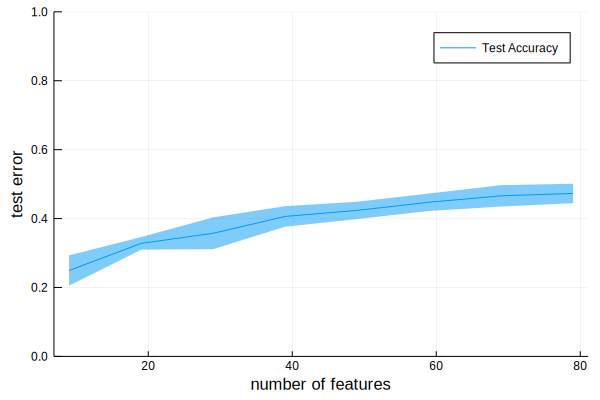

In [14]:
plot(ds,mean_acc_reg,ribbon=std_acc_reg,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

In [15]:
#V7, training until convergence, with bigger regularizer

ntrain=50
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=9:10:79
nreps = 20

accs_reg = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true, 0.5)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_reg[:,rep] = acc
end
mean_acc_reg = mean(accs_reg,dims=2)
std_acc_reg = std(accs_reg,dims=2);

9


Iteration
1
Loss
1686.9815359566933
Train Accuracy
0.08
Magic constant
0.05


Iteration
2
Loss
1400.480400985757
Train Accuracy
0.08
Magic constant
0.05


Iteration
3
Loss
1166.9242513047886
Train Accuracy
0.08
Magic constant
0.05


Iteration
4
Loss
976.7119605873675
Train Accuracy
0.08
Magic constant
0.05


Iteration
5
Loss
822.1780589685893
Train Accuracy
0.08
Magic constant
0.05


Iteration
6
Loss
696.1179059314032
Train Accuracy
0.08
Magic constant
0.05


Iteration
7
Loss
591.851738540814
Train Accuracy
0.08
Magic constant
0.05


Iteration
8
Loss
507.3186969392023
Train Accuracy
0.1
Magic constant
0.05


Iteration
9
Loss
437.48125829152406
Train Accuracy
0.12
Magic constant
0.05


Iteration
10
Loss
381.7057848203427
Train Accuracy
0.08
Magic constant
0.05


Iteration
11
Loss
334.2822630413152
Train Accuracy
0.08
Magic constant
0.05


Iteration
12
Loss
297.17533889300853
Train Accuracy
0.08
Magic constant
0.05


Iteration
13
Loss
264.71540917575885
Train Accuracy
0.06
Magic cons

0.52
Magic constant
0.025


Iteration
212
Loss
118.87569277386768
Train Accuracy
0.52
Magic constant
0.025


Iteration
213
Loss
118.83279776388264
Train Accuracy
0.52
Magic constant
0.025


Iteration
214
Loss
119.28276427120194
Train Accuracy
0.54
Magic constant
0.025


Iteration
215
Loss
118.75578276978973
Train Accuracy
0.52
Magic constant
0.025


Iteration
216
Loss
118.8544534439109
Train Accuracy
0.54
Magic constant
0.025


Iteration
217
Loss
118.30573751042616
Train Accuracy
0.52
Magic constant
0.025


Iteration
218
Loss
118.62162408612491
Train Accuracy
0.5
Magic constant
0.025


Iteration
219
Loss
118.07580207125258
Train Accuracy
0.52
Magic constant
0.025


Iteration
220
Loss
118.26921853208569
Train Accuracy
0.52
Magic constant
0.025


Iteration
221
Loss
117.96260768397366
Train Accuracy
0.52
Magic constant
0.025


Iteration
222
Loss
118.15420133594444
Train Accuracy
0.52
Magic constant
0.025


Iteration
223
Loss
117.94109483930112
Train Accuracy
0.52
Magic constant
0.025


It

Train Accuracy
0.54
Magic constant
0.016666666666666666


Iteration
425
Loss
114.86166363318758
Train Accuracy
0.56
Magic constant
0.016666666666666666


Iteration
426
Loss
114.85644220163479
Train Accuracy
0.54
Magic constant
0.016666666666666666


Iteration
427
Loss
114.79761140907927
Train Accuracy
0.52
Magic constant
0.016666666666666666


Iteration
428
Loss
114.6232011484331
Train Accuracy
0.56
Magic constant
0.016666666666666666


Iteration
429
Loss
114.72448322150979
Train Accuracy
0.5
Magic constant
0.016666666666666666


Iteration
430
Loss
114.60699876138669
Train Accuracy
0.54
Magic constant
0.016666666666666666


Iteration
431
Loss
114.83372627307418
Train Accuracy
0.56
Magic constant
0.016666666666666666


Iteration
432
Loss
114.60845191057957
Train Accuracy
0.52
Magic constant
0.016666666666666666


Iteration
433
Loss
114.5332751626187
Train Accuracy
0.54
Magic constant
0.016666666666666666


Iteration
434
Loss
114.87371076223319
Train Accuracy
0.56
Magic constant
0.016666

0.58
Magic constant
0.014285714285714287


Iteration
532
Loss
113.122724228405
Train Accuracy
0.58
Magic constant
0.014285714285714287


Iteration
533
Loss
112.77380946525881
Train Accuracy
0.58
Magic constant
0.014285714285714287


Iteration
534
Loss
113.04118765986252
Train Accuracy
0.56
Magic constant
0.014285714285714287


Iteration
535
Loss
112.80799965513822
Train Accuracy
0.54
Magic constant
0.014285714285714287


Iteration
536
Loss
112.75560190578828
Train Accuracy
0.56
Magic constant
0.014285714285714287


Iteration
537
Loss
113.01145573855955
Train Accuracy
0.52
Magic constant
0.014285714285714287


Iteration
538
Loss
112.68552386930575
Train Accuracy
0.56
Magic constant
0.014285714285714287


Iteration
539
Loss
113.48538115087628
Train Accuracy
0.56
Magic constant
0.014285714285714287


Iteration
540
Loss
112.96809498345714
Train Accuracy
0.6
Magic constant
0.014285714285714287


Iteration
541
Loss
112.79987097938482
Train Accuracy
0.58
Magic constant
0.014285714285714287




Magic constant
0.0125


Iteration
621
Loss
112.6143360136687
Train Accuracy
0.62
Magic constant
0.0125


Iteration
622
Loss
112.58526008513913
Train Accuracy
0.58
Magic constant
0.0125


Iteration
623
Loss
112.46907059887484
Train Accuracy
0.56
Magic constant
0.0125


Iteration
624
Loss
112.52179156356665
Train Accuracy
0.58
Magic constant
0.0125


Iteration
625
Loss
112.33844557217185
Train Accuracy
0.56
Magic constant
0.0125


Iteration
626
Loss
112.53229241379863
Train Accuracy
0.56
Magic constant
0.0125


Iteration
627
Loss
112.48439383679546
Train Accuracy
0.56
Magic constant
0.0125


Iteration
628
Loss
112.46188220693354
Train Accuracy
0.54
Magic constant
0.0125


Iteration
629
Loss
112.59285513952555
Train Accuracy
0.56
Magic constant
0.0125


Iteration
630
Loss
112.41567572495818
Train Accuracy
0.54
Magic constant
0.0125


Iteration
631
Loss
112.38656419162464
Train Accuracy
0.58
Magic constant
0.0125


Iteration
632
Loss
112.46152516010198
Train Accuracy
0.54
Magic constant
0.

813
Loss
110.42503310305855
Train Accuracy
0.6
Magic constant
0.01


Iteration
814
Loss
110.40288851309512
Train Accuracy
0.56
Magic constant
0.01


Iteration
815
Loss
110.38889933117406
Train Accuracy
0.58
Magic constant
0.01


Iteration
816
Loss
110.3441836370336
Train Accuracy
0.56
Magic constant
0.01


Iteration
817
Loss
110.40376021093326
Train Accuracy
0.6
Magic constant
0.01


Iteration
818
Loss
110.27390260695225
Train Accuracy
0.58
Magic constant
0.01


Iteration
819
Loss
110.5225947172455
Train Accuracy
0.6
Magic constant
0.01


Iteration
820
Loss
110.17256214503168
Train Accuracy
0.58
Magic constant
0.01


Iteration
821
Loss
110.35000350886065
Train Accuracy
0.6
Magic constant
0.01


Iteration
822
Loss
110.26466458726956
Train Accuracy
0.58
Magic constant
0.01


Iteration
823
Loss
110.42419732030034
Train Accuracy
0.58
Magic constant
0.01


Iteration
824
Loss
110.31255582595799
Train Accuracy
0.58
Magic constant
0.01


Iteration
825
Loss
110.28885618890052
Train Accuracy
0.5

0.009090909090909092


Iteration
935
Loss
108.99753136897851
Train Accuracy
0.58
Magic constant
0.009090909090909092


Iteration
936
Loss
108.87314271863382
Train Accuracy
0.58
Magic constant
0.009090909090909092


Iteration
937
Loss
109.0627246650406
Train Accuracy
0.58
Magic constant
0.009090909090909092


Iteration
938
Loss
108.80340315879309
Train Accuracy
0.58
Magic constant
0.009090909090909092


Iteration
939
Loss
109.01584311292704
Train Accuracy
0.56
Magic constant
0.009090909090909092


Iteration
940
Loss
108.76582803748605
Train Accuracy
0.58
Magic constant
0.009090909090909092


Iteration
941
Loss
108.68598990281657
Train Accuracy
0.58
Magic constant
0.009090909090909092


Iteration
942
Loss
108.88535903795409
Train Accuracy
0.6
Magic constant
0.009090909090909092


Iteration
943
Loss
108.65407128193546
Train Accuracy
0.58
Magic constant
0.009090909090909092


Iteration
944
Loss
108.88785815517896
Train Accuracy
0.58
Magic constant
0.009090909090909092


Iteration
945
Loss


Loss
101.49890897370273
Train Accuracy
0.7
Magic constant
0.03333333333333333


Iteration
119
Loss
101.29129250437032
Train Accuracy
0.6
Magic constant
0.03333333333333333


Iteration
120
Loss
100.98971358451053
Train Accuracy
0.64
Magic constant
0.03333333333333333


Iteration
121
Loss
100.64396456255939
Train Accuracy
0.6
Magic constant
0.03333333333333333


Iteration
122
Loss
100.53527708503178
Train Accuracy
0.7
Magic constant
0.03333333333333333


Iteration
123
Loss
101.01084030215713
Train Accuracy
0.66
Magic constant
0.03333333333333333


Iteration
124
Loss
100.89514396100532
Train Accuracy
0.68
Magic constant
0.03333333333333333


Iteration
125
Loss
101.02280549583857
Train Accuracy
0.62
Magic constant
0.03333333333333333


Iteration
126
Loss
100.83450800064166
Train Accuracy
0.68
Magic constant
0.03333333333333333


Iteration
127
Loss
100.72479940242896
Train Accuracy
0.64
Magic constant
0.03333333333333333


Iteration
128
Loss
100.87264377314757
Train Accuracy
0.66
Magic cons

0.7
Magic constant
0.025


Iteration
232
Loss
97.89930735153922
Train Accuracy
0.7
Magic constant
0.025


Iteration
233
Loss
97.55098153073848
Train Accuracy
0.68
Magic constant
0.025


Iteration
234
Loss
97.14095412925032
Train Accuracy
0.64
Magic constant
0.025


Iteration
235
Loss
97.4489246592364
Train Accuracy
0.7
Magic constant
0.025


Iteration
236
Loss
97.42789130046917
Train Accuracy
0.68
Magic constant
0.025


Iteration
237
Loss
97.43324080953127
Train Accuracy
0.66
Magic constant
0.025


Iteration
238
Loss
97.53176937795433
Train Accuracy
0.66
Magic constant
0.025


Iteration
239
Loss
96.97920283582795
Train Accuracy
0.68
Magic constant
0.025


Iteration
240
Loss
97.44288890454035
Train Accuracy
0.68
Magic constant
0.025


Iteration
241
Loss
97.4213973444011
Train Accuracy
0.68
Magic constant
0.025


Iteration
242
Loss
97.34535968527462
Train Accuracy
0.66
Magic constant
0.025


Iteration
243
Loss
97.70875051898949
Train Accuracy
0.66
Magic constant
0.025


Iteration
244
Los

0.016666666666666666


Iteration
445
Loss
94.46644241989476
Train Accuracy
0.66
Magic constant
0.016666666666666666


Iteration
446
Loss
94.42076432445332
Train Accuracy
0.68
Magic constant
0.016666666666666666


Iteration
447
Loss
94.32950696832371
Train Accuracy
0.66
Magic constant
0.016666666666666666


Iteration
448
Loss
94.23954276753103
Train Accuracy
0.68
Magic constant
0.016666666666666666


Iteration
449
Loss
94.4129003162692
Train Accuracy
0.68
Magic constant
0.016666666666666666


Iteration
450
Loss
94.49648237114646
Train Accuracy
0.68
Magic constant
0.016666666666666666


Iteration
451
Loss
94.46864355168057
Train Accuracy
0.68
Magic constant
0.016666666666666666


Iteration
452
Loss
94.34537220393534
Train Accuracy
0.7
Magic constant
0.016666666666666666


Iteration
453
Loss
94.46001424268869
Train Accuracy
0.66
Magic constant
0.016666666666666666


Iteration
454
Loss
94.52033133959988
Train Accuracy
0.7
Magic constant
0.016666666666666666


Iteration
455
Loss
94.47614333



Iteration
543
Loss
93.52320998731905
Train Accuracy
0.68
Magic constant
0.014285714285714287


Iteration
544
Loss
93.48891213799719
Train Accuracy
0.68
Magic constant
0.014285714285714287


Iteration
545
Loss
93.54879216695238
Train Accuracy
0.68
Magic constant
0.014285714285714287


Iteration
546
Loss
93.50194362509976
Train Accuracy
0.66
Magic constant
0.014285714285714287


Iteration
547
Loss
93.57085639218907
Train Accuracy
0.72
Magic constant
0.014285714285714287


Iteration
548
Loss
93.58102082361873
Train Accuracy
0.68
Magic constant
0.014285714285714287


Iteration
549
Loss
93.51421006496128
Train Accuracy
0.68
Magic constant
0.014285714285714287


Iteration
550
Loss
93.62262158189412
Train Accuracy
0.66
Magic constant
0.014285714285714287


Iteration
551
Loss
93.62977310042477
Train Accuracy
0.7
Magic constant
0.014285714285714287


Iteration
552
Loss
93.58335033752863
Train Accuracy
0.66
Magic constant
0.014285714285714287


Iteration
553
Loss
93.57616252146582
Train Accura

Train Accuracy
0.7
Magic constant
0.0125


Iteration
693
Loss
92.71175401855196
Train Accuracy
0.7
Magic constant
0.0125


Iteration
694
Loss
92.70590422084052
Train Accuracy
0.68
Magic constant
0.0125


Iteration
695
Loss
92.79473205773128
Train Accuracy
0.68
Magic constant
0.0125


Iteration
696
Loss
92.8647894023647
Train Accuracy
0.68
Magic constant
0.0125


Iteration
697
Loss
92.74458548995928
Train Accuracy
0.68
Magic constant
0.0125


Iteration
698
Loss
92.78718163142082
Train Accuracy
0.68
Magic constant
0.0125


Iteration
699
Loss
92.71968882103974
Train Accuracy
0.68
Magic constant
0.0125


Iteration
700
Loss
92.80713727834511
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
701
Loss
92.7345629419696
Train Accuracy
0.66
Magic constant
0.011111111111111112


Iteration
702
Loss
92.68493354735598
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
703
Loss
92.49992408573955
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
704

92.39174373320645
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
791
Loss
92.48696288692314
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
792
Loss
92.4574887597197
Train Accuracy
0.66
Magic constant
0.011111111111111112


Iteration
793
Loss
92.59283690440013
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
794
Loss
92.57230005832436
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
795
Loss
92.60925996290902
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
796
Loss
92.49381094806452
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
797
Loss
92.45331781526889
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
798
Loss
92.54787089323204
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
799
Loss
92.580340162934
Train Accuracy
0.68
Magic constant
0.011111111111111112


Iteration
800
Loss
92.53534314019024
Train Accuracy
0.68
Magic constant


Magic constant
0.009090909090909092


Iteration
969
Loss
92.01325458586287
Train Accuracy
0.7
Magic constant
0.009090909090909092


Iteration
970
Loss
91.99068558813914
Train Accuracy
0.68
Magic constant
0.009090909090909092


Iteration
971
Loss
92.00425012238564
Train Accuracy
0.68
Magic constant
0.009090909090909092


Iteration
972
Loss
92.04084884151924
Train Accuracy
0.68
Magic constant
0.009090909090909092


Iteration
973
Loss
92.09640084347927
Train Accuracy
0.68
Magic constant
0.009090909090909092


Iteration
974
Loss
91.99607278572796
Train Accuracy
0.68
Magic constant
0.009090909090909092


Iteration
975
Loss
92.11466301569662
Train Accuracy
0.68
Magic constant
0.009090909090909092


Iteration
976
Loss
92.10679433663857
Train Accuracy
0.68
Magic constant
0.009090909090909092


Iteration
977
Loss
92.08838620591666
Train Accuracy
0.7
Magic constant
0.009090909090909092


Iteration
978
Loss
92.10562314373043
Train Accuracy
0.68
Magic constant
0.009090909090909092


Iteration
979


92
Loss
112.23437262114561
Train Accuracy
0.8
Magic constant
0.05


Iteration
93
Loss
112.30981505025431
Train Accuracy
0.72
Magic constant
0.05


Iteration
94
Loss
113.46859800166362
Train Accuracy
0.84
Magic constant
0.05


Iteration
95
Loss
114.01562227343177
Train Accuracy
0.8
Magic constant
0.05


Iteration
96
Loss
114.56116065234455
Train Accuracy
0.8
Magic constant
0.05


Iteration
97
Loss
113.7090453899568
Train Accuracy
0.76
Magic constant
0.05


Iteration
98
Loss
113.35291911175317
Train Accuracy
0.76
Magic constant
0.05


Iteration
99
Loss
114.28367522353791
Train Accuracy
0.82
Magic constant
0.05


Iteration
100
Loss
114.67650441094816
Train Accuracy
0.8
Magic constant
0.03333333333333333


Iteration
101
Loss
113.79636200707469
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
102
Loss
112.17249108492942
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
103
Loss
110.5979291542004
Train Accuracy
0.8
Magic constant
0.03333333333333333


Itera

Magic constant
0.03333333333333333


Iteration
188
Loss
103.61980645697994
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
189
Loss
103.46098104022698
Train Accuracy
0.8
Magic constant
0.03333333333333333


Iteration
190
Loss
103.11513601631502
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
191
Loss
102.54416195289039
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
192
Loss
101.95955805981332
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
193
Loss
103.26235579328383
Train Accuracy
0.8
Magic constant
0.03333333333333333


Iteration
194
Loss
103.92249805172314
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
195
Loss
103.7558215820599
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
196
Loss
103.49446461953593
Train Accuracy
0.84
Magic constant
0.03333333333333333


Iteration
197
Loss
102.57583080166859
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
198
Lo

Magic constant
0.02


Iteration
316
Loss
98.44847458718715
Train Accuracy
0.82
Magic constant
0.02


Iteration
317
Loss
98.33417163512374
Train Accuracy
0.8
Magic constant
0.02


Iteration
318
Loss
98.01713112797324
Train Accuracy
0.84
Magic constant
0.02


Iteration
319
Loss
98.11133942315851
Train Accuracy
0.82
Magic constant
0.02


Iteration
320
Loss
98.34274652184332
Train Accuracy
0.84
Magic constant
0.02


Iteration
321
Loss
98.31251068314272
Train Accuracy
0.84
Magic constant
0.02


Iteration
322
Loss
98.07527785273307
Train Accuracy
0.82
Magic constant
0.02


Iteration
323
Loss
98.22039638122365
Train Accuracy
0.8
Magic constant
0.02


Iteration
324
Loss
97.94979999089308
Train Accuracy
0.84
Magic constant
0.02


Iteration
325
Loss
97.72249901011189
Train Accuracy
0.82
Magic constant
0.02


Iteration
326
Loss
97.80453443337997
Train Accuracy
0.84
Magic constant
0.02


Iteration
327
Loss
97.97992734315335
Train Accuracy
0.82
Magic constant
0.02


Iteration
328
Loss
97.8466238753

97.25431560756131
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
456
Loss
97.20106244380948
Train Accuracy
0.8
Magic constant
0.016666666666666666


Iteration
457
Loss
96.97958950720583
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
458
Loss
96.93832999734101
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
459
Loss
96.92770186815014
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
460
Loss
96.90955391645441
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
461
Loss
96.91108537083977
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
462
Loss
96.78406683039331
Train Accuracy
0.84
Magic constant
0.016666666666666666


Iteration
463
Loss
96.89636827453171
Train Accuracy
0.8
Magic constant
0.016666666666666666


Iteration
464
Loss
96.77911901293167
Train Accuracy
0.84
Magic constant
0.016666666666666666


Iteration
465
Loss
96.86486271989072
Train Accuracy
0.8
Magic constant


Magic constant
0.0125


Iteration
617
Loss
95.27523811613175
Train Accuracy
0.82
Magic constant
0.0125


Iteration
618
Loss
95.31248914672604
Train Accuracy
0.8
Magic constant
0.0125


Iteration
619
Loss
95.42078375208719
Train Accuracy
0.84
Magic constant
0.0125


Iteration
620
Loss
95.45082015622692
Train Accuracy
0.8
Magic constant
0.0125


Iteration
621
Loss
95.31079375446592
Train Accuracy
0.84
Magic constant
0.0125


Iteration
622
Loss
95.34406951837025
Train Accuracy
0.82
Magic constant
0.0125


Iteration
623
Loss
95.43798488534914
Train Accuracy
0.84
Magic constant
0.0125


Iteration
624
Loss
95.5549254158348
Train Accuracy
0.82
Magic constant
0.0125


Iteration
625
Loss
95.73686466514405
Train Accuracy
0.84
Magic constant
0.0125


Iteration
626
Loss
95.63884900926476
Train Accuracy
0.84
Magic constant
0.0125


Iteration
627
Loss
95.51737655754863
Train Accuracy
0.8
Magic constant
0.0125


Iteration
628
Loss
95.53692970528671
Train Accuracy
0.82
Magic constant
0.0125


Iteratio



Iteration
780
Loss
95.5157301998431
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
781
Loss
95.55303509457688
Train Accuracy
0.8
Magic constant
0.011111111111111112


Iteration
782
Loss
95.49058240409448
Train Accuracy
0.84
Magic constant
0.011111111111111112


Iteration
783
Loss
95.52046603960363
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
784
Loss
95.6083721151557
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
785
Loss
95.50268050202659
Train Accuracy
0.84
Magic constant
0.011111111111111112


Iteration
786
Loss
95.45242089442831
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
787
Loss
95.5162687653693
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
788
Loss
95.46228485311667
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
789
Loss
95.5573130005119
Train Accuracy
0.84
Magic constant
0.011111111111111112


Iteration
790
Loss
95.50674428341844
Train Accuracy
0

Magic constant
0.009090909090909092


Iteration
938
Loss
95.10093713001808
Train Accuracy
0.84
Magic constant
0.009090909090909092


Iteration
939
Loss
95.15437500488224
Train Accuracy
0.82
Magic constant
0.009090909090909092


Iteration
940
Loss
95.20389176479651
Train Accuracy
0.84
Magic constant
0.009090909090909092


Iteration
941
Loss
95.1886891818177
Train Accuracy
0.84
Magic constant
0.009090909090909092


Iteration
942
Loss
95.22561592102461
Train Accuracy
0.84
Magic constant
0.009090909090909092


Iteration
943
Loss
95.2667700755903
Train Accuracy
0.84
Magic constant
0.009090909090909092


Iteration
944
Loss
95.21597422757627
Train Accuracy
0.82
Magic constant
0.009090909090909092


Iteration
945
Loss
95.13583140966294
Train Accuracy
0.84
Magic constant
0.009090909090909092


Iteration
946
Loss
95.15205226136727
Train Accuracy
0.8
Magic constant
0.009090909090909092


Iteration
947
Loss
94.97448458866656
Train Accuracy
0.84
Magic constant
0.009090909090909092


Iteration
948
L

108.35900762250962
Train Accuracy
0.74
Magic constant
0.05


Iteration
59
Loss
108.31927844762252
Train Accuracy
0.72
Magic constant
0.05


Iteration
60
Loss
107.48433266315568
Train Accuracy
0.7
Magic constant
0.05


Iteration
61
Loss
106.58132696164655
Train Accuracy
0.7
Magic constant
0.05


Iteration
62
Loss
106.59210095648018
Train Accuracy
0.74
Magic constant
0.05


Iteration
63
Loss
106.07536534830248
Train Accuracy
0.76
Magic constant
0.05


Iteration
64
Loss
104.28471650355021
Train Accuracy
0.72
Magic constant
0.05


Iteration
65
Loss
104.33891837657768
Train Accuracy
0.72
Magic constant
0.05


Iteration
66
Loss
105.51661500920781
Train Accuracy
0.74
Magic constant
0.05


Iteration
67
Loss
106.71357253530374
Train Accuracy
0.76
Magic constant
0.05


Iteration
68
Loss
108.18363211175685
Train Accuracy
0.76
Magic constant
0.05


Iteration
69
Loss
108.58904911450196
Train Accuracy
0.72
Magic constant
0.05


Iteration
70
Loss
108.98192824290948
Train Accuracy
0.74
Magic constant


Magic constant
0.03333333333333333


Iteration
165
Loss
99.49833929262819
Train Accuracy
0.8
Magic constant
0.03333333333333333


Iteration
166
Loss
99.50411688566982
Train Accuracy
0.74
Magic constant
0.03333333333333333


Iteration
167
Loss
99.68795747215367
Train Accuracy
0.78
Magic constant
0.03333333333333333


Iteration
168
Loss
99.07623721043167
Train Accuracy
0.78
Magic constant
0.03333333333333333


Iteration
169
Loss
99.2537137001209
Train Accuracy
0.8
Magic constant
0.03333333333333333


Iteration
170
Loss
98.97397057204225
Train Accuracy
0.78
Magic constant
0.03333333333333333


Iteration
171
Loss
99.01703324203267
Train Accuracy
0.78
Magic constant
0.03333333333333333


Iteration
172
Loss
98.99036585070785
Train Accuracy
0.78
Magic constant
0.03333333333333333


Iteration
173
Loss
99.27094566344394
Train Accuracy
0.78
Magic constant
0.03333333333333333


Iteration
174
Loss
98.93508102130828
Train Accuracy
0.78
Magic constant
0.03333333333333333


Iteration
175
Loss
99.4653

Magic constant
0.025


Iteration
284
Loss
96.65980894275232
Train Accuracy
0.8
Magic constant
0.025


Iteration
285
Loss
96.52195813014892
Train Accuracy
0.8
Magic constant
0.025


Iteration
286
Loss
96.37526095646115
Train Accuracy
0.78
Magic constant
0.025


Iteration
287
Loss
96.80085751879993
Train Accuracy
0.78
Magic constant
0.025


Iteration
288
Loss
96.79042005945331
Train Accuracy
0.78
Magic constant
0.025


Iteration
289
Loss
96.742691081489
Train Accuracy
0.82
Magic constant
0.025


Iteration
290
Loss
96.64082450224082
Train Accuracy
0.78
Magic constant
0.025


Iteration
291
Loss
96.3509068824004
Train Accuracy
0.8
Magic constant
0.025


Iteration
292
Loss
96.40690655615147
Train Accuracy
0.78
Magic constant
0.025


Iteration
293
Loss
96.79198051029474
Train Accuracy
0.78
Magic constant
0.025


Iteration
294
Loss
96.69289428208407
Train Accuracy
0.8
Magic constant
0.025


Iteration
295
Loss
96.64768373083153
Train Accuracy
0.8
Magic constant
0.025


Iteration
296
Loss
96.191

Magic constant
0.016666666666666666


Iteration
410
Loss
93.25251309474815
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
411
Loss
93.11375771122317
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
412
Loss
93.12292964751879
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
413
Loss
92.89660854170934
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
414
Loss
93.44762404257588
Train Accuracy
0.8
Magic constant
0.016666666666666666


Iteration
415
Loss
93.49776979433072
Train Accuracy
0.78
Magic constant
0.016666666666666666


Iteration
416
Loss
93.45623881521634
Train Accuracy
0.8
Magic constant
0.016666666666666666


Iteration
417
Loss
93.33531601838408
Train Accuracy
0.8
Magic constant
0.016666666666666666


Iteration
418
Loss
93.16986104427262
Train Accuracy
0.8
Magic constant
0.016666666666666666


Iteration
419
Loss
93.07054408541289
Train Accuracy
0.82
Magic constant
0.016666666666666666


Iteration
420
Lo

Magic constant
0.014285714285714287


Iteration
569
Loss
92.01539850190065
Train Accuracy
0.86
Magic constant
0.014285714285714287


Iteration
570
Loss
91.94891597089406
Train Accuracy
0.82
Magic constant
0.014285714285714287


Iteration
571
Loss
91.81068672375457
Train Accuracy
0.86
Magic constant
0.014285714285714287


Iteration
572
Loss
91.79246118761563
Train Accuracy
0.78
Magic constant
0.014285714285714287


Iteration
573
Loss
91.77378626882263
Train Accuracy
0.86
Magic constant
0.014285714285714287


Iteration
574
Loss
91.80703738247246
Train Accuracy
0.8
Magic constant
0.014285714285714287


Iteration
575
Loss
91.73783220065451
Train Accuracy
0.86
Magic constant
0.014285714285714287


Iteration
576
Loss
91.66613075102677
Train Accuracy
0.78
Magic constant
0.014285714285714287


Iteration
577
Loss
91.80083018777219
Train Accuracy
0.86
Magic constant
0.014285714285714287


Iteration
578
Loss
91.64319816830353
Train Accuracy
0.82
Magic constant
0.014285714285714287


Iteration
579

90.86002882832231
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
715
Loss
90.87395837280077
Train Accuracy
0.86
Magic constant
0.011111111111111112


Iteration
716
Loss
90.94213065122536
Train Accuracy
0.8
Magic constant
0.011111111111111112


Iteration
717
Loss
90.86872027609562
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
718
Loss
90.71610935968471
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
719
Loss
90.93434652501757
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
720
Loss
90.9293058097419
Train Accuracy
0.8
Magic constant
0.011111111111111112


Iteration
721
Loss
90.96560655522978
Train Accuracy
0.8
Magic constant
0.011111111111111112


Iteration
722
Loss
90.93831319608591
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
723
Loss
90.74492266910856
Train Accuracy
0.82
Magic constant
0.011111111111111112


Iteration
724
Loss
90.69700274368317
Train Accuracy
0.84
Magic constant
0

0.82
Magic constant
0.01


Iteration
850
Loss
90.39726552248325
Train Accuracy
0.84
Magic constant
0.01


Iteration
851
Loss
90.33018530609952
Train Accuracy
0.8
Magic constant
0.01


Iteration
852
Loss
90.63220185116191
Train Accuracy
0.82
Magic constant
0.01


Iteration
853
Loss
90.65026395172393
Train Accuracy
0.82
Magic constant
0.01


Iteration
854
Loss
90.63438104034539
Train Accuracy
0.86
Magic constant
0.01


Iteration
855
Loss
90.56215374890286
Train Accuracy
0.82
Magic constant
0.01


Iteration
856
Loss
90.40693528851028
Train Accuracy
0.82
Magic constant
0.01


Iteration
857
Loss
90.35460118809983
Train Accuracy
0.82
Magic constant
0.01


Iteration
858
Loss
90.54452323457319
Train Accuracy
0.84
Magic constant
0.01


Iteration
859
Loss
90.45633849415633
Train Accuracy
0.82
Magic constant
0.01


Iteration
860
Loss
90.46629775410528
Train Accuracy
0.82
Magic constant
0.01


Iteration
861
Loss
90.32982224486797
Train Accuracy
0.82
Magic constant
0.01


Iteration
862
Loss
90.5650

49


Iteration
1
Loss
1758.5697251839924
Train Accuracy
0.04
Magic constant
0.05


Iteration
2
Loss
1458.0393568959798
Train Accuracy
0.04
Magic constant
0.05


Iteration
3
Loss
1213.3589913936962
Train Accuracy
0.08
Magic constant
0.05


Iteration
4
Loss
1014.9108130149108
Train Accuracy
0.1
Magic constant
0.05


Iteration
5
Loss
852.8987704980959
Train Accuracy
0.08
Magic constant
0.05


Iteration
6
Loss
721.1301383902231
Train Accuracy
0.12
Magic constant
0.05


Iteration
7
Loss
613.6677343072438
Train Accuracy
0.1
Magic constant
0.05


Iteration
8
Loss
526.4646191224824
Train Accuracy
0.1
Magic constant
0.05


Iteration
9
Loss
454.37806363406634
Train Accuracy
0.12
Magic constant
0.05


Iteration
10
Loss
395.1432894049427
Train Accuracy
0.12
Magic constant
0.05


Iteration
11
Loss
345.9555004479843
Train Accuracy
0.14
Magic constant
0.05


Iteration
12
Loss
304.6569382745547
Train Accuracy
0.14
Magic constant
0.05


Iteration
13
Loss
271.3248183567335
Train Accuracy
0.18
Magic cons

Iteration
152
Loss
98.98023558755013
Train Accuracy
0.8
Magic constant
0.03333333333333333


Iteration
153
Loss
98.82600497226224
Train Accuracy
0.74
Magic constant
0.03333333333333333


Iteration
154
Loss
99.13811681872276
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
155
Loss
99.15352139889244
Train Accuracy
0.74
Magic constant
0.03333333333333333


Iteration
156
Loss
99.89964634687912
Train Accuracy
0.84
Magic constant
0.03333333333333333


Iteration
157
Loss
99.80391607310467
Train Accuracy
0.76
Magic constant
0.03333333333333333


Iteration
158
Loss
99.59817064618171
Train Accuracy
0.84
Magic constant
0.03333333333333333


Iteration
159
Loss
99.1540508744295
Train Accuracy
0.72
Magic constant
0.03333333333333333


Iteration
160
Loss
99.46580783259913
Train Accuracy
0.82
Magic constant
0.03333333333333333


Iteration
161
Loss
99.4301594113643
Train Accuracy
0.78
Magic constant
0.03333333333333333


Iteration
162
Loss
99.7703999187606
Train Accuracy
0.74
Magic c

Magic constant
0.025


Iteration
275
Loss
96.67094599743324
Train Accuracy
0.78
Magic constant
0.025


Iteration
276
Loss
96.67948891384927
Train Accuracy
0.84
Magic constant
0.025


Iteration
277
Loss
96.66207209933972
Train Accuracy
0.78
Magic constant
0.025


Iteration
278
Loss
96.73101167525502
Train Accuracy
0.84
Magic constant
0.025


Iteration
279
Loss
96.80370262149296
Train Accuracy
0.8
Magic constant
0.025


Iteration
280
Loss
96.531625135213
Train Accuracy
0.82
Magic constant
0.025


Iteration
281
Loss
96.59512070305587
Train Accuracy
0.76
Magic constant
0.025


Iteration
282
Loss
96.50212183267821
Train Accuracy
0.86
Magic constant
0.025


Iteration
283
Loss
96.36614935435094
Train Accuracy
0.78
Magic constant
0.025


Iteration
284
Loss
96.72126841149218
Train Accuracy
0.84
Magic constant
0.025


Iteration
285
Loss
97.03201283101082
Train Accuracy
0.8
Magic constant
0.025


Iteration
286
Loss
96.70686545681482
Train Accuracy
0.76
Magic constant
0.025


Iteration
287
Loss
96

Magic constant
0.02


Iteration
386
Loss
95.3448897151225
Train Accuracy
0.86
Magic constant
0.02


Iteration
387
Loss
95.33400336930588
Train Accuracy
0.8
Magic constant
0.02


Iteration
388
Loss
95.1628165414067
Train Accuracy
0.8
Magic constant
0.02


Iteration
389
Loss
95.12921419485761
Train Accuracy
0.78
Magic constant
0.02


Iteration
390
Loss
95.21809420345615
Train Accuracy
0.82
Magic constant
0.02


Iteration
391
Loss
95.31742062607377
Train Accuracy
0.78
Magic constant
0.02


Iteration
392
Loss
95.2767638066855
Train Accuracy
0.86
Magic constant
0.02


Iteration
393
Loss
95.26999360681987
Train Accuracy
0.78
Magic constant
0.02


Iteration
394
Loss
95.3165868565044
Train Accuracy
0.84
Magic constant
0.02


Iteration
395
Loss
95.10070622977217
Train Accuracy
0.8
Magic constant
0.02


Iteration
396
Loss
95.34840243644204
Train Accuracy
0.8
Magic constant
0.02


Iteration
397
Loss
95.2181321746578
Train Accuracy
0.8
Magic constant
0.02


Iteration
398
Loss
95.04924956595653
Tra

Magic constant
0.014285714285714287


Iteration
528
Loss
93.76765474340975
Train Accuracy
0.78
Magic constant
0.014285714285714287


Iteration
529
Loss
93.73161680462955
Train Accuracy
0.8
Magic constant
0.014285714285714287


Iteration
530
Loss
93.65019436382053
Train Accuracy
0.8
Magic constant
0.014285714285714287


Iteration
531
Loss
93.74120441083332
Train Accuracy
0.82
Magic constant
0.014285714285714287


Iteration
532
Loss
93.78720213310169
Train Accuracy
0.8
Magic constant
0.014285714285714287


Iteration
533
Loss
93.76541131873596
Train Accuracy
0.82
Magic constant
0.014285714285714287


Iteration
534
Loss
93.61545898700264
Train Accuracy
0.8
Magic constant
0.014285714285714287


Iteration
535
Loss
93.82282012929404
Train Accuracy
0.82
Magic constant
0.014285714285714287


Iteration
536
Loss
93.61308204913682
Train Accuracy
0.8
Magic constant
0.014285714285714287


Iteration
537
Loss
93.58383337161975
Train Accuracy
0.8
Magic constant
0.014285714285714287


Iteration
538
Loss

0.0125


Iteration
675
Loss
93.0577307413457
Train Accuracy
0.8
Magic constant
0.0125


Iteration
676
Loss
93.34454027557017
Train Accuracy
0.78
Magic constant
0.0125


Iteration
677
Loss
93.21735043983816
Train Accuracy
0.8
Magic constant
0.0125


Iteration
678
Loss
93.20977196137635
Train Accuracy
0.8
Magic constant
0.0125


Iteration
679
Loss
93.14048172212424
Train Accuracy
0.8
Magic constant
0.0125


Iteration
680
Loss
93.22039361471656
Train Accuracy
0.82
Magic constant
0.0125


Iteration
681
Loss
93.28470685741432
Train Accuracy
0.8
Magic constant
0.0125


Iteration
682
Loss
93.26333150153063
Train Accuracy
0.82
Magic constant
0.0125


Iteration
683
Loss
93.28084021110823
Train Accuracy
0.8
Magic constant
0.0125


Iteration
684
Loss
93.33261197493624
Train Accuracy
0.84
Magic constant
0.0125


Iteration
685
Loss
93.29839047073447
Train Accuracy
0.8
Magic constant
0.0125


Iteration
686
Loss
93.37341163367265
Train Accuracy
0.8
Magic constant
0.0125


Iteration
687
Loss
93.288335

Magic constant
0.01


Iteration
815
Loss
92.70875781887133
Train Accuracy
0.82
Magic constant
0.01


Iteration
816
Loss
92.73243193433912
Train Accuracy
0.8
Magic constant
0.01


Iteration
817
Loss
92.8425987600785
Train Accuracy
0.84
Magic constant
0.01


Iteration
818
Loss
92.80307983653151
Train Accuracy
0.8
Magic constant
0.01


Iteration
819
Loss
92.79975596377027
Train Accuracy
0.82
Magic constant
0.01


Iteration
820
Loss
92.8266526166082
Train Accuracy
0.8
Magic constant
0.01


Iteration
821
Loss
92.7161583308951
Train Accuracy
0.82
Magic constant
0.01


Iteration
822
Loss
92.74148042727563
Train Accuracy
0.8
Magic constant
0.01


Iteration
823
Loss
92.74891953986004
Train Accuracy
0.8
Magic constant
0.01


Iteration
824
Loss
92.76336896809613
Train Accuracy
0.78
Magic constant
0.01


Iteration
825
Loss
92.76419067569516
Train Accuracy
0.82
Magic constant
0.01


Iteration
826
Loss
92.7081212525624
Train Accuracy
0.8
Magic constant
0.01


Iteration
827
Loss
92.77516151900575
Tra

Magic constant
0.009090909090909092


Iteration
949
Loss
92.67919517094708
Train Accuracy
0.8
Magic constant
0.009090909090909092


Iteration
950
Loss
92.71144507820132
Train Accuracy
0.82
Magic constant
0.009090909090909092


Iteration
951
Loss
92.72477971037053
Train Accuracy
0.78
Magic constant
0.009090909090909092


Iteration
952
Loss
92.7340452015976
Train Accuracy
0.8
Magic constant
0.009090909090909092


Iteration
953
Loss
92.67378146880603
Train Accuracy
0.8
Magic constant
0.009090909090909092


Iteration
954
Loss
92.68274722438224
Train Accuracy
0.82
Magic constant
0.009090909090909092


Iteration
955
Loss
92.69014051051045
Train Accuracy
0.78
Magic constant
0.009090909090909092


Iteration
956
Loss
92.66825160459096
Train Accuracy
0.8
Magic constant
0.009090909090909092


Iteration
957
Loss
92.65793033590197
Train Accuracy
0.8
Magic constant
0.009090909090909092


Iteration
958
Loss
92.68873606382752
Train Accuracy
0.82
Magic constant
0.009090909090909092


Iteration
959
Loss

Iteration
56
Loss
219.38907984941272
Train Accuracy
0.68
Magic constant
0.05


Iteration
57
Loss
225.9698964997256
Train Accuracy
0.68
Magic constant
0.05


Iteration
58
Loss
231.79669039565263
Train Accuracy
0.7
Magic constant
0.05


Iteration
59
Loss
236.77298925267854
Train Accuracy
0.7
Magic constant
0.05


Iteration
60
Loss
240.88612238017072
Train Accuracy
0.6
Magic constant
0.05


Iteration
61
Loss
244.21776023229626
Train Accuracy
0.58
Magic constant
0.05


Iteration
62
Loss
246.91638690779214
Train Accuracy
0.5
Magic constant
0.05


Iteration
63
Loss
249.1022745273158
Train Accuracy
0.48
Magic constant
0.05


Iteration
64
Loss
250.8728435091513
Train Accuracy
0.46
Magic constant
0.05


Iteration
65
Loss
252.30700439255537
Train Accuracy
0.44
Magic constant
0.05


Iteration
66
Loss
253.46867471468767
Train Accuracy
0.4
Magic constant
0.05


Iteration
67
Loss
254.40962768094053
Train Accuracy
0.4
Magic constant
0.05


Iteration
68
Loss
255.17381764082464
Train Accuracy
0.36
Magi

Magic constant
0.025


Iteration
209
Loss
250.82031808676638
Train Accuracy
0.32
Magic constant
0.025


Iteration
210
Loss
250.7443198683272
Train Accuracy
0.32
Magic constant
0.025


Iteration
211
Loss
250.67330375519433
Train Accuracy
0.32
Magic constant
0.025


Iteration
212
Loss
250.6069431426947
Train Accuracy
0.32
Magic constant
0.025


Iteration
213
Loss
250.54493283690553
Train Accuracy
0.32
Magic constant
0.025


Iteration
214
Loss
250.4869876510608
Train Accuracy
0.32
Magic constant
0.025


Iteration
215
Loss
250.4328410939708
Train Accuracy
0.32
Magic constant
0.025


Iteration
216
Loss
250.38224414442334
Train Accuracy
0.32
Magic constant
0.025


Iteration
217
Loss
250.33496410592986
Train Accuracy
0.32
Magic constant
0.025


Iteration
218
Loss
250.2907835365489
Train Accuracy
0.32
Magic constant
0.025


Iteration
219
Loss
250.2494992488659
Train Accuracy
0.32
Magic constant
0.025


Iteration
220
Loss
250.21092137552995
Train Accuracy
0.32
Magic constant
0.025


Iteration
2

Magic constant
0.02


Iteration
339
Loss
248.75414270994926
Train Accuracy
0.32
Magic constant
0.02


Iteration
340
Loss
248.7469072225118
Train Accuracy
0.32
Magic constant
0.02


Iteration
341
Loss
248.74002898725763
Train Accuracy
0.32
Magic constant
0.02


Iteration
342
Loss
248.73349036486053
Train Accuracy
0.32
Magic constant
0.02


Iteration
343
Loss
248.72727458693626
Train Accuracy
0.32
Magic constant
0.02


Iteration
344
Loss
248.72136571303923
Train Accuracy
0.32
Magic constant
0.02


Iteration
345
Loss
248.71574858978354
Train Accuracy
0.32
Magic constant
0.02


Iteration
346
Loss
248.71040881198158
Train Accuracy
0.32
Magic constant
0.02


Iteration
347
Loss
248.70533268570202
Train Accuracy
0.32
Magic constant
0.02


Iteration
348
Loss
248.7005071931512
Train Accuracy
0.32
Magic constant
0.02


Iteration
349
Loss
248.69591995928909
Train Accuracy
0.32
Magic constant
0.02


Iteration
350
Loss
248.6915592200932
Train Accuracy
0.32
Magic constant
0.02


Iteration
351
Loss
24

Magic constant
0.016666666666666666


Iteration
464
Loss
248.0275957595819
Train Accuracy
0.32
Magic constant
0.016666666666666666


Iteration
465
Loss
248.02570321513724
Train Accuracy
0.32
Magic constant
0.016666666666666666


Iteration
466
Loss
248.02388561545072
Train Accuracy
0.32
Magic constant
0.016666666666666666


Iteration
467
Loss
248.02213999271
Train Accuracy
0.32
Magic constant
0.016666666666666666


Iteration
468
Loss
248.020463496628
Train Accuracy
0.32
Magic constant
0.016666666666666666


Iteration
469
Loss
248.01885338978923
Train Accuracy
0.32
Magic constant
0.016666666666666666


Iteration
470
Loss
248.01730704317967
Train Accuracy
0.32
Magic constant
0.016666666666666666


Iteration
471
Loss
248.01582193189427
Train Accuracy
0.32
Magic constant
0.016666666666666666


Iteration
472
Loss
248.0143956310143
Train Accuracy
0.32
Magic constant
0.016666666666666666


Iteration
473
Loss
248.01302581164776
Train Accuracy
0.32
Magic constant
0.016666666666666666


Iteration

605
Loss
247.5361047527162
Train Accuracy
0.32
Magic constant
0.0125


Iteration
606
Loss
247.52844808116933
Train Accuracy
0.32
Magic constant
0.0125


Iteration
607
Loss
247.5210086090752
Train Accuracy
0.32
Magic constant
0.0125


Iteration
608
Loss
247.5137801750616
Train Accuracy
0.32
Magic constant
0.0125


Iteration
609
Loss
247.5067567925384
Train Accuracy
0.32
Magic constant
0.0125


Iteration
610
Loss
247.4999326447388
Train Accuracy
0.32
Magic constant
0.0125


Iteration
611
Loss
247.49330207990252
Train Accuracy
0.32
Magic constant
0.0125


Iteration
612
Loss
247.48685960659458
Train Accuracy
0.32
Magic constant
0.0125


Iteration
613
Loss
247.48059988915753
Train Accuracy
0.32
Magic constant
0.0125


Iteration
614
Loss
247.4745177432922
Train Accuracy
0.32
Magic constant
0.0125


Iteration
615
Loss
247.46860813176448
Train Accuracy
0.32
Magic constant
0.0125


Iteration
616
Loss
247.46286616023298
Train Accuracy
0.32
Magic constant
0.0125


Iteration
617
Loss
247.457287073

Magic constant
0.011111111111111112


Iteration
710
Loss
247.23041411288293
Train Accuracy
0.32
Magic constant
0.011111111111111112


Iteration
711
Loss
247.22578366772095
Train Accuracy
0.32
Magic constant
0.011111111111111112


Iteration
712
Loss
247.22126826017808
Train Accuracy
0.32
Magic constant
0.011111111111111112


Iteration
713
Loss
247.2168650322885
Train Accuracy
0.32
Magic constant
0.011111111111111112


Iteration
714
Loss
247.21257119708903
Train Accuracy
0.32
Magic constant
0.011111111111111112


Iteration
715
Loss
247.2083840368551
Train Accuracy
0.32
Magic constant
0.011111111111111112


Iteration
716
Loss
247.2043009013806
Train Accuracy
0.32
Magic constant
0.011111111111111112


Iteration
717
Loss
247.20031920630046
Train Accuracy
0.32
Magic constant
0.011111111111111112


Iteration
718
Loss
247.19643643145503
Train Accuracy
0.32
Magic constant
0.011111111111111112


Iteration
719
Loss
247.19265011929465
Train Accuracy
0.32
Magic constant
0.011111111111111112


Itera

Magic constant
0.01


Iteration
833
Loss
246.9475088191962
Train Accuracy
0.32
Magic constant
0.01


Iteration
834
Loss
246.9458294415334
Train Accuracy
0.32
Magic constant
0.01


Iteration
835
Loss
246.94418717604267
Train Accuracy
0.32
Magic constant
0.01


Iteration
836
Loss
246.94258120259093
Train Accuracy
0.32
Magic constant
0.01


Iteration
837
Loss
246.94101071916884
Train Accuracy
0.32
Magic constant
0.01


Iteration
838
Loss
246.9394749414907
Train Accuracy
0.32
Magic constant
0.01


Iteration
839
Loss
246.93797310260229
Train Accuracy
0.32
Magic constant
0.01


Iteration
840
Loss
246.93651501119453
Train Accuracy
0.32
Magic constant
0.01


Iteration
841
Loss
246.92437636715786
Train Accuracy
0.32
Magic constant
0.01


Iteration
842
Loss
246.92320818811356
Train Accuracy
0.32
Magic constant
0.01


Iteration
843
Loss
246.92206582438328
Train Accuracy
0.32
Magic constant
0.01


Iteration
844
Loss
246.92094870548055
Train Accuracy
0.32
Magic constant
0.01


Iteration
845
Loss
24

0.009090909090909092


Iteration
954
Loss
246.76323322396973
Train Accuracy
0.32
Magic constant
0.009090909090909092


Iteration
955
Loss
246.76264500725603
Train Accuracy
0.32
Magic constant
0.009090909090909092


Iteration
956
Loss
246.76206849605455
Train Accuracy
0.32
Magic constant
0.009090909090909092


Iteration
957
Loss
246.76150345742568
Train Accuracy
0.32
Magic constant
0.009090909090909092


Iteration
958
Loss
246.76094966306528
Train Accuracy
0.32
Magic constant
0.009090909090909092


Iteration
959
Loss
246.7604068892123
Train Accuracy
0.32
Magic constant
0.009090909090909092


Iteration
960
Loss
246.7598749165588
Train Accuracy
0.32
Magic constant
0.009090909090909092


Iteration
961
Loss
246.75937110248998
Train Accuracy
0.32
Magic constant
0.009090909090909092


Iteration
962
Loss
246.7492158470437
Train Accuracy
0.32
Magic constant
0.009090909090909092


Iteration
963
Loss
246.74890657612366
Train Accuracy
0.32
Magic constant
0.009090909090909092


Iteration
964
Loss
2

Excessive output truncated after 524302 bytes.




Iteration
1
Loss
1240.3081645884367
Train Accuracy
0.08
Magic constant
0.05


Iteration
2
Loss
1036.5792977456904
Train Accuracy
0.08
Magic constant
0.05


Iteration
3
Loss
870.0532601812893
Train Accuracy
0.08
Magic constant
0.05


Iteration
4
Loss
732.8206287470434
Train Accuracy
0.08
Magic constant
0.05


Iteration
5
Loss
623.276242745829
Train Accuracy
0.08
Magic constant
0.05


Iteration
6
Loss
532.357207213384
Train Accuracy
0.08
Magic constant
0.05


Iteration
7
Loss
458.65440017289865
Train Accuracy
0.08
Magic constant
0.05


Iteration
8
Loss
398.58400131063775
Train Accuracy
0.08
Magic constant
0.05


Iteration
9
Loss
348.88977719664126
Train Accuracy
0.1
Magic constant
0.05


Iteration
10
Loss
307.42206770701677
Train Accuracy
0.1
Magic constant
0.05


Iteration
11
Loss
273.11752168199143
Train Accuracy
0.12
Magic constant
0.05


Iteration
12
Loss
245.4688007603317
Train Accuracy
0.12
Magic constant
0.05


Iteration
13
Loss
221.57639658541518
Train Accuracy
0.14
Magic cons

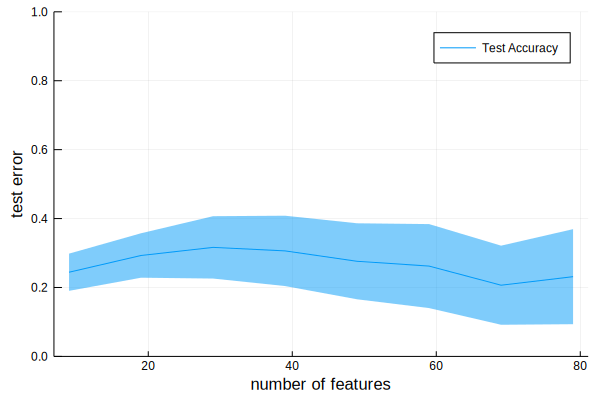

In [16]:
plot(ds,mean_acc_reg,ribbon=std_acc_reg,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

In [15]:
#V7, training until convergence, with regularizer, more data

ntrain=500
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=99:100:799
nreps = 20

accs_reg = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true, 0.1)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_reg[:,rep] = acc
end
mean_acc_reg = mean(accs_reg,dims=2)
std_acc_reg = std(accs_reg,dims=2);

99


Iteration
1
Loss
10778.334273495822
Train Accuracy
0.068
Magic constant
0.010000000000000002


Iteration
2
Loss
9590.764875072837
Train Accuracy
0.072
Magic constant
0.010000000000000002


Iteration
3
Loss
8542.779015786276
Train Accuracy
0.074
Magic constant
0.010000000000000002


Iteration
4
Loss
7615.896673457801
Train Accuracy
0.074
Magic constant
0.010000000000000002


Iteration
5
Loss
6791.551782431405
Train Accuracy
0.076
Magic constant
0.010000000000000002


Iteration
6
Loss
6068.5106292433975
Train Accuracy
0.074
Magic constant
0.010000000000000002


Iteration
7
Loss
5425.565270896671
Train Accuracy
0.082
Magic constant
0.010000000000000002


Iteration
8
Loss
4863.22461800533
Train Accuracy
0.086
Magic constant
0.010000000000000002


Iteration
9
Loss
4367.592146976163
Train Accuracy
0.086
Magic constant
0.010000000000000002


Iteration
10
Loss
3936.1029427758226
Train Accuracy
0.098
Magic constant
0.010000000000000002


Iteration
11
Loss
3568.36996680231
Train Accuracy
0.

Magic constant
0.010000000000000002


Iteration
90
Loss
470.12850011208184
Train Accuracy
0.868
Magic constant
0.010000000000000002


Iteration
91
Loss
540.3848377990262
Train Accuracy
0.856
Magic constant
0.010000000000000002


Iteration
92
Loss
504.2779037475054
Train Accuracy
0.866
Magic constant
0.010000000000000002


Iteration
93
Loss
476.3455598789689
Train Accuracy
0.87
Magic constant
0.010000000000000002


Iteration
94
Loss
486.5319298474
Train Accuracy
0.86
Magic constant
0.010000000000000002


Iteration
95
Loss
482.0853445841519
Train Accuracy
0.868
Magic constant
0.010000000000000002


Iteration
96
Loss
487.82501278720895
Train Accuracy
0.864
Magic constant
0.010000000000000002


Iteration
97
Loss
491.315737962349
Train Accuracy
0.868
Magic constant
0.010000000000000002


Iteration
98
Loss
482.4986971393946
Train Accuracy
0.87
Magic constant
0.010000000000000002


Iteration
99
Loss
540.2695584908486
Train Accuracy
0.858
Magic constant
0.010000000000000002


Iteration
100
Los

Magic constant
0.006666666666666668


Iteration
177
Loss
436.779469698173
Train Accuracy
0.874
Magic constant
0.006666666666666668


Iteration
178
Loss
441.16488235144004
Train Accuracy
0.88
Magic constant
0.006666666666666668


Iteration
179
Loss
436.11226625020055
Train Accuracy
0.874
Magic constant
0.006666666666666668


Iteration
180
Loss
463.37584992222037
Train Accuracy
0.88
Magic constant
0.006666666666666668


Iteration
181
Loss
449.06464422933095
Train Accuracy
0.876
Magic constant
0.006666666666666668


Iteration
182
Loss
438.35240406012065
Train Accuracy
0.878
Magic constant
0.006666666666666668


Iteration
183
Loss
446.427317060209
Train Accuracy
0.868
Magic constant
0.006666666666666668


Iteration
184
Loss
437.84333297638864
Train Accuracy
0.872
Magic constant
0.006666666666666668


Iteration
185
Loss
449.42215664188745
Train Accuracy
0.866
Magic constant
0.006666666666666668


Iteration
186
Loss
437.79050875745895
Train Accuracy
0.872
Magic constant
0.006666666666666668


Iteration
263
Loss
418.1238632262915
Train Accuracy
0.878
Magic constant
0.005000000000000001


Iteration
264
Loss
427.8230037059566
Train Accuracy
0.872
Magic constant
0.005000000000000001


Iteration
265
Loss
419.6934214317306
Train Accuracy
0.876
Magic constant
0.005000000000000001


Iteration
266
Loss
419.4970035411487
Train Accuracy
0.876
Magic constant
0.005000000000000001


Iteration
267
Loss
425.3075998785122
Train Accuracy
0.872
Magic constant
0.005000000000000001


Iteration
268
Loss
418.9840455158502
Train Accuracy
0.876
Magic constant
0.005000000000000001


Iteration
269
Loss
426.0194811362308
Train Accuracy
0.878
Magic constant
0.005000000000000001


Iteration
270
Loss
418.65812245817165
Train Accuracy
0.876
Magic constant
0.005000000000000001


Iteration
271
Loss
426.33266527541764
Train Accuracy
0.872
Magic constant
0.005000000000000001


Iteration
272
Loss
419.31267770059117
Train Accuracy
0.878
Magic constant
0.005000000000000001


Iteration
273
Loss
422.2506405744848


Magic constant
0.004000000000000001


Iteration
352
Loss
405.59361186104
Train Accuracy
0.878
Magic constant
0.004000000000000001


Iteration
353
Loss
410.0737582133129
Train Accuracy
0.876
Magic constant
0.004000000000000001


Iteration
354
Loss
405.2876109932138
Train Accuracy
0.876
Magic constant
0.004000000000000001


Iteration
355
Loss
408.49880566903903
Train Accuracy
0.876
Magic constant
0.004000000000000001


Iteration
356
Loss
405.07714830158557
Train Accuracy
0.878
Magic constant
0.004000000000000001


Iteration
357
Loss
408.622530308372
Train Accuracy
0.878
Magic constant
0.004000000000000001


Iteration
358
Loss
404.38752340158214
Train Accuracy
0.876
Magic constant
0.004000000000000001


Iteration
359
Loss
411.5719960454616
Train Accuracy
0.876
Magic constant
0.004000000000000001


Iteration
360
Loss
405.4568814849813
Train Accuracy
0.878
Magic constant
0.004000000000000001


Iteration
361
Loss
403.2748923374073
Train Accuracy
0.876
Magic constant
0.004000000000000001


It

Magic constant
0.003333333333333334


Iteration
438
Loss
398.84550499248667
Train Accuracy
0.876
Magic constant
0.003333333333333334


Iteration
439
Loss
398.4525367878374
Train Accuracy
0.878
Magic constant
0.003333333333333334


Iteration
440
Loss
399.3845098889019
Train Accuracy
0.876
Magic constant
0.003333333333333334


Iteration
441
Loss
398.2391834335798
Train Accuracy
0.878
Magic constant
0.003333333333333334


Iteration
442
Loss
400.1825684563945
Train Accuracy
0.878
Magic constant
0.003333333333333334


Iteration
443
Loss
397.68986752423933
Train Accuracy
0.88
Magic constant
0.003333333333333334


Iteration
444
Loss
400.80278230120496
Train Accuracy
0.876
Magic constant
0.003333333333333334


Iteration
445
Loss
396.7496284298428
Train Accuracy
0.876
Magic constant
0.003333333333333334


Iteration
446
Loss
399.12209304198797
Train Accuracy
0.882
Magic constant
0.003333333333333334


Iteration
447
Loss
395.2484658036734
Train Accuracy
0.882
Magic constant
0.003333333333333334



Magic constant
0.0028571428571428576


Iteration
524
Loss
393.55876423934325
Train Accuracy
0.878
Magic constant
0.0028571428571428576


Iteration
525
Loss
390.3726288850782
Train Accuracy
0.876
Magic constant
0.0028571428571428576


Iteration
526
Loss
391.90640870059667
Train Accuracy
0.878
Magic constant
0.0028571428571428576


Iteration
527
Loss
390.28812024008147
Train Accuracy
0.88
Magic constant
0.0028571428571428576


Iteration
528
Loss
391.38812196940955
Train Accuracy
0.874
Magic constant
0.0028571428571428576


Iteration
529
Loss
389.69456229423656
Train Accuracy
0.878
Magic constant
0.0028571428571428576


Iteration
530
Loss
393.2150950309748
Train Accuracy
0.878
Magic constant
0.0028571428571428576


Iteration
531
Loss
389.67253869395495
Train Accuracy
0.874
Magic constant
0.0028571428571428576


Iteration
532
Loss
390.05338096295395
Train Accuracy
0.88
Magic constant
0.0028571428571428576


Iteration
533
Loss
390.13491713861686
Train Accuracy
0.88
Magic constant
0.00285714

Iteration
610
Loss
382.9448698129876
Train Accuracy
0.878
Magic constant
0.0025000000000000005


Iteration
611
Loss
382.17477484446096
Train Accuracy
0.878
Magic constant
0.0025000000000000005


Iteration
612
Loss
385.1785106788452
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
613
Loss
382.3938055143011
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
614
Loss
384.37429430444206
Train Accuracy
0.878
Magic constant
0.0025000000000000005


Iteration
615
Loss
382.0924406321326
Train Accuracy
0.876
Magic constant
0.0025000000000000005


Iteration
616
Loss
385.7839148085835
Train Accuracy
0.882
Magic constant
0.0025000000000000005


Iteration
617
Loss
382.52875109670475
Train Accuracy
0.882
Magic constant
0.0025000000000000005


Iteration
618
Loss
382.87161039409364
Train Accuracy
0.876
Magic constant
0.0025000000000000005


Iteration
619
Loss
383.220131899381
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
620
Loss
382.3173272

Magic constant
0.0025000000000000005


Iteration
696
Loss
380.1225450156766
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
697
Loss
378.00364332390166
Train Accuracy
0.882
Magic constant
0.0025000000000000005


Iteration
698
Loss
381.1773658339124
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
699
Loss
378.0813103233744
Train Accuracy
0.88
Magic constant
0.0025000000000000005


Iteration
700
Loss
380.21238466308716
Train Accuracy
0.88
Magic constant
0.0022222222222222227


Iteration
701
Loss
377.89701598263485
Train Accuracy
0.88
Magic constant
0.0022222222222222227


Iteration
702
Loss
379.67413422414216
Train Accuracy
0.88
Magic constant
0.0022222222222222227


Iteration
703
Loss
377.57815956976515
Train Accuracy
0.882
Magic constant
0.0022222222222222227


Iteration
704
Loss
379.82647975353603
Train Accuracy
0.88
Magic constant
0.0022222222222222227


Iteration
705
Loss
377.4659845121074
Train Accuracy
0.88
Magic constant
0.002222222222222

Magic constant
0.0022222222222222227


Iteration
782
Loss
374.38744033483795
Train Accuracy
0.882
Magic constant
0.0022222222222222227


Iteration
783
Loss
374.58533079185827
Train Accuracy
0.882
Magic constant
0.0022222222222222227


Iteration
784
Loss
374.7161064733639
Train Accuracy
0.884
Magic constant
0.0022222222222222227


Iteration
785
Loss
374.57811918567086
Train Accuracy
0.88
Magic constant
0.0022222222222222227


Iteration
786
Loss
376.0984961810451
Train Accuracy
0.884
Magic constant
0.0022222222222222227


Iteration
787
Loss
374.3152237358696
Train Accuracy
0.884
Magic constant
0.0022222222222222227


Iteration
788
Loss
376.9453072636418
Train Accuracy
0.88
Magic constant
0.0022222222222222227


Iteration
789
Loss
374.2111480891292
Train Accuracy
0.878
Magic constant
0.0022222222222222227


Iteration
790
Loss
374.6519605120375
Train Accuracy
0.884
Magic constant
0.0022222222222222227


Iteration
791
Loss
374.1820833184778
Train Accuracy
0.882
Magic constant
0.002222222222

Magic constant
0.0020000000000000005


Iteration
867
Loss
373.1520691066133
Train Accuracy
0.884
Magic constant
0.0020000000000000005


Iteration
868
Loss
371.2549392526787
Train Accuracy
0.884
Magic constant
0.0020000000000000005


Iteration
869
Loss
374.0705622784866
Train Accuracy
0.88
Magic constant
0.0020000000000000005


Iteration
870
Loss
371.5029877774554
Train Accuracy
0.882
Magic constant
0.0020000000000000005


Iteration
871
Loss
371.3942492340482
Train Accuracy
0.884
Magic constant
0.0020000000000000005


Iteration
872
Loss
371.9798769103748
Train Accuracy
0.882
Magic constant
0.0020000000000000005


Iteration
873
Loss
371.2363769721276
Train Accuracy
0.882
Magic constant
0.0020000000000000005


Iteration
874
Loss
373.7518370111974
Train Accuracy
0.884
Magic constant
0.0020000000000000005


Iteration
875
Loss
371.382028477506
Train Accuracy
0.884
Magic constant
0.0020000000000000005


Iteration
876
Loss
372.7832191151219
Train Accuracy
0.88
Magic constant
0.0020000000000000

Magic constant
0.0018181818181818186


Iteration
953
Loss
368.5757162303304
Train Accuracy
0.884
Magic constant
0.0018181818181818186


Iteration
954
Loss
370.80206292986463
Train Accuracy
0.882
Magic constant
0.0018181818181818186


Iteration
955
Loss
368.68711738766825
Train Accuracy
0.884
Magic constant
0.0018181818181818186


Iteration
956
Loss
369.14424215420024
Train Accuracy
0.884
Magic constant
0.0018181818181818186


Iteration
957
Loss
368.4411351920511
Train Accuracy
0.884
Magic constant
0.0018181818181818186


Iteration
958
Loss
370.0743845908537
Train Accuracy
0.88
Magic constant
0.0018181818181818186


Iteration
959
Loss
368.4018979791248
Train Accuracy
0.884
Magic constant
0.0018181818181818186


Iteration
960
Loss
370.67554302180986
Train Accuracy
0.882
Magic constant
0.0018181818181818186


Iteration
961
Loss
368.49624741417483
Train Accuracy
0.884
Magic constant
0.0018181818181818186


Iteration
962
Loss
369.15618874683446
Train Accuracy
0.882
Magic constant
0.00181818

Magic constant
0.010000000000000002


Iteration
41
Loss
653.3751656934921
Train Accuracy
0.77
Magic constant
0.010000000000000002


Iteration
42
Loss
618.400388548492
Train Accuracy
0.774
Magic constant
0.010000000000000002


Iteration
43
Loss
647.1010047994989
Train Accuracy
0.78
Magic constant
0.010000000000000002


Iteration
44
Loss
599.4295375855183
Train Accuracy
0.796
Magic constant
0.010000000000000002


Iteration
45
Loss
577.0052624976781
Train Accuracy
0.788
Magic constant
0.010000000000000002


Iteration
46
Loss
598.5168083261525
Train Accuracy
0.812
Magic constant
0.010000000000000002


Iteration
47
Loss
557.1201301922999
Train Accuracy
0.816
Magic constant
0.010000000000000002


Iteration
48
Loss
546.0747975467356
Train Accuracy
0.804
Magic constant
0.010000000000000002


Iteration
49
Loss
546.8667842906423
Train Accuracy
0.826
Magic constant
0.010000000000000002


Iteration
50
Loss
521.6601355415271
Train Accuracy
0.822
Magic constant
0.010000000000000002


Iteration
51
Lo

Magic constant
0.006666666666666668


Iteration
129
Loss
404.3239304956729
Train Accuracy
0.902
Magic constant
0.006666666666666668


Iteration
130
Loss
402.69870615119305
Train Accuracy
0.892
Magic constant
0.006666666666666668


Iteration
131
Loss
411.1603370013605
Train Accuracy
0.912
Magic constant
0.006666666666666668


Iteration
132
Loss
402.2052931257136
Train Accuracy
0.902
Magic constant
0.006666666666666668


Iteration
133
Loss
410.8854797810933
Train Accuracy
0.892
Magic constant
0.006666666666666668


Iteration
134
Loss
400.18592266477464
Train Accuracy
0.896
Magic constant
0.006666666666666668


Iteration
135
Loss
408.55324187870747
Train Accuracy
0.9
Magic constant
0.006666666666666668


Iteration
136
Loss
399.60744371948977
Train Accuracy
0.906
Magic constant
0.006666666666666668


Iteration
137
Loss
407.89465454555784
Train Accuracy
0.902
Magic constant
0.006666666666666668


Iteration
138
Loss
398.88437834777204
Train Accuracy
0.898
Magic constant
0.006666666666666668


Magic constant
0.005000000000000001


Iteration
216
Loss
396.9601692458829
Train Accuracy
0.898
Magic constant
0.005000000000000001


Iteration
217
Loss
403.8327687026285
Train Accuracy
0.902
Magic constant
0.005000000000000001


Iteration
218
Loss
397.06411031286376
Train Accuracy
0.9
Magic constant
0.005000000000000001


Iteration
219
Loss
400.111664802675
Train Accuracy
0.894
Magic constant
0.005000000000000001


Iteration
220
Loss
396.568177067083
Train Accuracy
0.902
Magic constant
0.005000000000000001


Iteration
221
Loss
403.7839647002843
Train Accuracy
0.896
Magic constant
0.005000000000000001


Iteration
222
Loss
396.5995884275238
Train Accuracy
0.9
Magic constant
0.005000000000000001


Iteration
223
Loss
397.8754588399932
Train Accuracy
0.896
Magic constant
0.005000000000000001


Iteration
224
Loss
397.96265252009675
Train Accuracy
0.896
Magic constant
0.005000000000000001


Iteration
225
Loss
397.8907570348866
Train Accuracy
0.904
Magic constant
0.005000000000000001


Iterat

Magic constant
0.004000000000000001


Iteration
305
Loss
391.14874693936974
Train Accuracy
0.9
Magic constant
0.004000000000000001


Iteration
306
Loss
386.8392122426683
Train Accuracy
0.898
Magic constant
0.004000000000000001


Iteration
307
Loss
389.4549453843779
Train Accuracy
0.9
Magic constant
0.004000000000000001


Iteration
308
Loss
385.9558242621465
Train Accuracy
0.896
Magic constant
0.004000000000000001


Iteration
309
Loss
389.4376958166528
Train Accuracy
0.9
Magic constant
0.004000000000000001


Iteration
310
Loss
384.493954737677
Train Accuracy
0.902
Magic constant
0.004000000000000001


Iteration
311
Loss
387.28062912004367
Train Accuracy
0.896
Magic constant
0.004000000000000001


Iteration
312
Loss
383.969605383896
Train Accuracy
0.896
Magic constant
0.004000000000000001


Iteration
313
Loss
389.2603716950516
Train Accuracy
0.9
Magic constant
0.004000000000000001


Iteration
314
Loss
384.50861302110445
Train Accuracy
0.9
Magic constant
0.004000000000000001


Iteration
3

Magic constant
0.004000000000000001


Iteration
392
Loss
378.4867521403749
Train Accuracy
0.9
Magic constant
0.004000000000000001


Iteration
393
Loss
382.3617618847691
Train Accuracy
0.896
Magic constant
0.004000000000000001


Iteration
394
Loss
378.2520287659578
Train Accuracy
0.9
Magic constant
0.004000000000000001


Iteration
395
Loss
381.9622239021141
Train Accuracy
0.902
Magic constant
0.004000000000000001


Iteration
396
Loss
378.07869180576586
Train Accuracy
0.898
Magic constant
0.004000000000000001


Iteration
397
Loss
384.0837689811302
Train Accuracy
0.898
Magic constant
0.004000000000000001


Iteration
398
Loss
379.1788219158364
Train Accuracy
0.898
Magic constant
0.004000000000000001


Iteration
399
Loss
379.0916222659115
Train Accuracy
0.896
Magic constant
0.004000000000000001


Iteration
400
Loss
381.31556641737166
Train Accuracy
0.9
Magic constant
0.003333333333333334


Iteration
401
Loss
378.35154826717314
Train Accuracy
0.898
Magic constant
0.003333333333333334


Itera



Iteration
479
Loss
376.81556537819756
Train Accuracy
0.894
Magic constant
0.003333333333333334


Iteration
480
Loss
373.11711739310465
Train Accuracy
0.896
Magic constant
0.003333333333333334


Iteration
481
Loss
376.486989752485
Train Accuracy
0.906
Magic constant
0.003333333333333334


Iteration
482
Loss
373.00800711122093
Train Accuracy
0.904
Magic constant
0.003333333333333334


Iteration
483
Loss
375.47171758617117
Train Accuracy
0.898
Magic constant
0.003333333333333334


Iteration
484
Loss
372.82597918775355
Train Accuracy
0.894
Magic constant
0.003333333333333334


Iteration
485
Loss
376.40692602542805
Train Accuracy
0.902
Magic constant
0.003333333333333334


Iteration
486
Loss
372.5893373086494
Train Accuracy
0.9
Magic constant
0.003333333333333334


Iteration
487
Loss
374.4642073592315
Train Accuracy
0.894
Magic constant
0.003333333333333334


Iteration
488
Loss
372.38664225299254
Train Accuracy
0.898
Magic constant
0.003333333333333334


Iteration
489
Loss
375.95809547028

Magic constant
0.0028571428571428576


Iteration
565
Loss
369.84806675024856
Train Accuracy
0.902
Magic constant
0.0028571428571428576


Iteration
566
Loss
366.91404542790815
Train Accuracy
0.9
Magic constant
0.0028571428571428576


Iteration
567
Loss
369.41655180055335
Train Accuracy
0.898
Magic constant
0.0028571428571428576


Iteration
568
Loss
367.044030191175
Train Accuracy
0.9
Magic constant
0.0028571428571428576


Iteration
569
Loss
369.80098370451947
Train Accuracy
0.902
Magic constant
0.0028571428571428576


Iteration
570
Loss
366.960063661792
Train Accuracy
0.898
Magic constant
0.0028571428571428576


Iteration
571
Loss
369.6418973668742
Train Accuracy
0.9
Magic constant
0.0028571428571428576


Iteration
572
Loss
367.0637863562779
Train Accuracy
0.902
Magic constant
0.0028571428571428576


Iteration
573
Loss
370.0228057411395
Train Accuracy
0.896
Magic constant
0.0028571428571428576


Iteration
574
Loss
367.1830641513362
Train Accuracy
0.902
Magic constant
0.00285714285714285

Magic constant
0.0025000000000000005


Iteration
651
Loss
367.33685822035727
Train Accuracy
0.9
Magic constant
0.0025000000000000005


Iteration
652
Loss
365.2096707231917
Train Accuracy
0.898
Magic constant
0.0025000000000000005


Iteration
653
Loss
367.27776403429067
Train Accuracy
0.904
Magic constant
0.0025000000000000005


Iteration
654
Loss
364.77994745282786
Train Accuracy
0.9
Magic constant
0.0025000000000000005


Iteration
655
Loss
366.04535124086345
Train Accuracy
0.902
Magic constant
0.0025000000000000005


Iteration
656
Loss
364.7289275009826
Train Accuracy
0.896
Magic constant
0.0025000000000000005


Iteration
657
Loss
366.4937794293845
Train Accuracy
0.906
Magic constant
0.0025000000000000005


Iteration
658
Loss
364.9328637860929
Train Accuracy
0.898
Magic constant
0.0025000000000000005


Iteration
659
Loss
367.95755785404924
Train Accuracy
0.906
Magic constant
0.0025000000000000005


Iteration
660
Loss
365.2093824357237
Train Accuracy
0.902
Magic constant
0.002500000000

Magic constant
0.0022222222222222227


Iteration
739
Loss
362.4959340709863
Train Accuracy
0.902
Magic constant
0.0022222222222222227


Iteration
740
Loss
363.72868512690354
Train Accuracy
0.898
Magic constant
0.0022222222222222227


Iteration
741
Loss
361.9775710886207
Train Accuracy
0.9
Magic constant
0.0022222222222222227


Iteration
742
Loss
364.28667444657
Train Accuracy
0.908
Magic constant
0.0022222222222222227


Iteration
743
Loss
362.0601535365837
Train Accuracy
0.902
Magic constant
0.0022222222222222227


Iteration
744
Loss
364.1120589425092
Train Accuracy
0.9
Magic constant
0.0022222222222222227


Iteration
745
Loss
362.0738473741535
Train Accuracy
0.9
Magic constant
0.0022222222222222227


Iteration
746
Loss
363.8376291213779
Train Accuracy
0.904
Magic constant
0.0022222222222222227


Iteration
747
Loss
362.0110736770159
Train Accuracy
0.9
Magic constant
0.0022222222222222227


Iteration
748
Loss
364.617637175419
Train Accuracy
0.902
Magic constant
0.0022222222222222227


I

Magic constant
0.0020000000000000005


Iteration
826
Loss
360.1265663449063
Train Accuracy
0.9
Magic constant
0.0020000000000000005


Iteration
827
Loss
362.63346198974943
Train Accuracy
0.906
Magic constant
0.0020000000000000005


Iteration
828
Loss
360.39750268972693
Train Accuracy
0.9
Magic constant
0.0020000000000000005


Iteration
829
Loss
361.1602453641069
Train Accuracy
0.898
Magic constant
0.0020000000000000005


Iteration
830
Loss
360.93411446901933
Train Accuracy
0.904
Magic constant
0.0020000000000000005


Iteration
831
Loss
361.12288899107364
Train Accuracy
0.898
Magic constant
0.0020000000000000005


Iteration
832
Loss
362.0541820099783
Train Accuracy
0.904
Magic constant
0.0020000000000000005


Iteration
833
Loss
360.91846585251386
Train Accuracy
0.902
Magic constant
0.0020000000000000005


Iteration
834
Loss
361.677534316332
Train Accuracy
0.904
Magic constant
0.0020000000000000005


Iteration
835
Loss
359.65163222279756
Train Accuracy
0.902
Magic constant
0.002000000000

Magic constant
0.0018181818181818186


Iteration
912
Loss
360.92505987553386
Train Accuracy
0.908
Magic constant
0.0018181818181818186


Iteration
913
Loss
359.33305832701103
Train Accuracy
0.902
Magic constant
0.0018181818181818186


Iteration
914
Loss
360.21843801517014
Train Accuracy
0.904
Magic constant
0.0018181818181818186


Iteration
915
Loss
359.30802957476664
Train Accuracy
0.898
Magic constant
0.0018181818181818186


Iteration
916
Loss
360.93471280380516
Train Accuracy
0.904
Magic constant
0.0018181818181818186


Iteration
917
Loss
359.2901107612122
Train Accuracy
0.902
Magic constant
0.0018181818181818186


Iteration
918
Loss
360.3352998282333
Train Accuracy
0.902
Magic constant
0.0018181818181818186


Iteration
919
Loss
359.25922844076695
Train Accuracy
0.904
Magic constant
0.0018181818181818186


Iteration
920
Loss
360.22994073874946
Train Accuracy
0.898
Magic constant
0.0018181818181818186


Iteration
921
Loss
359.3127967509377
Train Accuracy
0.902
Magic constant
0.001818



Iteration
999
Loss
358.4766028716456
Train Accuracy
0.904
Magic constant
0.0018181818181818186


Iteration
1000
Loss
359.29813457874934
Train Accuracy
0.904
Magic constant
0.001666666666666667
299


Iteration
1
Loss
21399.350271886324
Train Accuracy
0.102
Magic constant
0.010000000000000002


Iteration
2
Loss
18981.182908608265
Train Accuracy
0.102
Magic constant
0.010000000000000002


Iteration
3
Loss
16852.548533708745
Train Accuracy
0.102
Magic constant
0.010000000000000002


Iteration
4
Loss
14961.143732537148
Train Accuracy
0.104
Magic constant
0.010000000000000002


Iteration
5
Loss
13295.271616758162
Train Accuracy
0.104
Magic constant
0.010000000000000002


Iteration
6
Loss
11826.68055297514
Train Accuracy
0.11
Magic constant
0.010000000000000002


Iteration
7
Loss
10528.249389982673
Train Accuracy
0.114
Magic constant
0.010000000000000002


Iteration
8
Loss
9375.335268412673
Train Accuracy
0.116
Magic constant
0.010000000000000002


Iteration
9
Loss
8361.289542358594
Train A

Magic constant
0.010000000000000002


Iteration
86
Loss
396.89329405711055
Train Accuracy
0.882
Magic constant
0.010000000000000002


Iteration
87
Loss
376.57334396690965
Train Accuracy
0.894
Magic constant
0.010000000000000002


Iteration
88
Loss
385.43960379468933
Train Accuracy
0.902
Magic constant
0.010000000000000002


Iteration
89
Loss
376.28023700986955
Train Accuracy
0.9
Magic constant
0.010000000000000002


Iteration
90
Loss
411.08767503942045
Train Accuracy
0.892
Magic constant
0.010000000000000002


Iteration
91
Loss
387.99514424084
Train Accuracy
0.892
Magic constant
0.010000000000000002


Iteration
92
Loss
381.21617735941334
Train Accuracy
0.9
Magic constant
0.010000000000000002


Iteration
93
Loss
410.1298999620466
Train Accuracy
0.898
Magic constant
0.010000000000000002


Iteration
94
Loss
388.32875572696787
Train Accuracy
0.898
Magic constant
0.010000000000000002


Iteration
95
Loss
390.8181299877536
Train Accuracy
0.894
Magic constant
0.010000000000000002


Iteration
9

Magic constant
0.006666666666666668


Iteration
174
Loss
375.16559895262014
Train Accuracy
0.918
Magic constant
0.006666666666666668


Iteration
175
Loss
377.9428189227865
Train Accuracy
0.92
Magic constant
0.006666666666666668


Iteration
176
Loss
376.90645745024835
Train Accuracy
0.918
Magic constant
0.006666666666666668


Iteration
177
Loss
379.8886046627246
Train Accuracy
0.92
Magic constant
0.006666666666666668


Iteration
178
Loss
379.0605298836647
Train Accuracy
0.918
Magic constant
0.006666666666666668


Iteration
179
Loss
381.6072398255891
Train Accuracy
0.92
Magic constant
0.006666666666666668


Iteration
180
Loss
381.863255382597
Train Accuracy
0.918
Magic constant
0.006666666666666668


Iteration
181
Loss
382.259352922291
Train Accuracy
0.922
Magic constant
0.006666666666666668


Iteration
182
Loss
388.9415035158914
Train Accuracy
0.918
Magic constant
0.006666666666666668


Iteration
183
Loss
382.28531627119634
Train Accuracy
0.922
Magic constant
0.006666666666666668


Iter

Iteration
260
Loss
372.278385789914
Train Accuracy
0.916
Magic constant
0.005000000000000001


Iteration
261
Loss
370.0652129292482
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
262
Loss
377.60439714883404
Train Accuracy
0.916
Magic constant
0.005000000000000001


Iteration
263
Loss
371.0448627899377
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
264
Loss
370.8596068716415
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
265
Loss
376.341546893546
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
266
Loss
371.7354453634468
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
267
Loss
374.05225725298044
Train Accuracy
0.916
Magic constant
0.005000000000000001


Iteration
268
Loss
369.5642094892948
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
269
Loss
374.6045909418783
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
270
Loss
369.5849598345993
Trai

Magic constant
0.004000000000000001


Iteration
346
Loss
368.70569712835004
Train Accuracy
0.918
Magic constant
0.004000000000000001


Iteration
347
Loss
364.34620439622694
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
348
Loss
367.5593219447421
Train Accuracy
0.924
Magic constant
0.004000000000000001


Iteration
349
Loss
364.24887049357676
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
350
Loss
369.90965899241013
Train Accuracy
0.924
Magic constant
0.004000000000000001


Iteration
351
Loss
365.27163008492073
Train Accuracy
0.922
Magic constant
0.004000000000000001


Iteration
352
Loss
365.9887484048496
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
353
Loss
367.1605523552483
Train Accuracy
0.918
Magic constant
0.004000000000000001


Iteration
354
Loss
365.96466362014297
Train Accuracy
0.918
Magic constant
0.004000000000000001


Iteration
355
Loss
372.0173570751393
Train Accuracy
0.918
Magic constant
0.004000000000000001



Magic constant
0.003333333333333334


Iteration
432
Loss
363.08501807351365
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
433
Loss
360.02683782803877
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
434
Loss
361.72563633116044
Train Accuracy
0.926
Magic constant
0.003333333333333334


Iteration
435
Loss
359.33125896553554
Train Accuracy
0.922
Magic constant
0.003333333333333334


Iteration
436
Loss
362.44244848303856
Train Accuracy
0.922
Magic constant
0.003333333333333334


Iteration
437
Loss
359.56960331519315
Train Accuracy
0.922
Magic constant
0.003333333333333334


Iteration
438
Loss
362.87891583381094
Train Accuracy
0.928
Magic constant
0.003333333333333334


Iteration
439
Loss
359.413852870681
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
440
Loss
361.0270590871869
Train Accuracy
0.924
Magic constant
0.003333333333333334


Iteration
441
Loss
360.3167588231004
Train Accuracy
0.922
Magic constant
0.003333333333333334



Magic constant
0.0028571428571428576


Iteration
519
Loss
354.75507273916264
Train Accuracy
0.926
Magic constant
0.0028571428571428576


Iteration
520
Loss
358.4776848424128
Train Accuracy
0.928
Magic constant
0.0028571428571428576


Iteration
521
Loss
355.390366139432
Train Accuracy
0.926
Magic constant
0.0028571428571428576


Iteration
522
Loss
355.98651422675914
Train Accuracy
0.926
Magic constant
0.0028571428571428576


Iteration
523
Loss
356.70047947481896
Train Accuracy
0.926
Magic constant
0.0028571428571428576


Iteration
524
Loss
355.9328724547412
Train Accuracy
0.924
Magic constant
0.0028571428571428576


Iteration
525
Loss
358.9999022481228
Train Accuracy
0.926
Magic constant
0.0028571428571428576


Iteration
526
Loss
356.36023550972857
Train Accuracy
0.926
Magic constant
0.0028571428571428576


Iteration
527
Loss
358.25671428507684
Train Accuracy
0.924
Magic constant
0.0028571428571428576


Iteration
528
Loss
355.9707110597946
Train Accuracy
0.922
Magic constant
0.002857142

Iteration
604
Loss
357.25593846593324
Train Accuracy
0.924
Magic constant
0.0025000000000000005


Iteration
605
Loss
355.50634637093816
Train Accuracy
0.924
Magic constant
0.0025000000000000005


Iteration
606
Loss
357.44629059720387
Train Accuracy
0.928
Magic constant
0.0025000000000000005


Iteration
607
Loss
355.4422170190277
Train Accuracy
0.928
Magic constant
0.0025000000000000005


Iteration
608
Loss
356.74327139606504
Train Accuracy
0.924
Magic constant
0.0025000000000000005


Iteration
609
Loss
354.69188831786124
Train Accuracy
0.926
Magic constant
0.0025000000000000005


Iteration
610
Loss
355.38854975191487
Train Accuracy
0.924
Magic constant
0.0025000000000000005


Iteration
611
Loss
354.3847664442318
Train Accuracy
0.924
Magic constant
0.0025000000000000005


Iteration
612
Loss
355.8001479100031
Train Accuracy
0.928
Magic constant
0.0025000000000000005


Iteration
613
Loss
354.3282486234787
Train Accuracy
0.926
Magic constant
0.0025000000000000005


Iteration
614
Loss
357.2

Iteration
689
Loss
355.2941913064177
Train Accuracy
0.928
Magic constant
0.0025000000000000005


Iteration
690
Loss
354.92296491755786
Train Accuracy
0.924
Magic constant
0.0025000000000000005


Iteration
691
Loss
355.3957521610005
Train Accuracy
0.93
Magic constant
0.0025000000000000005


Iteration
692
Loss
355.9062859540501
Train Accuracy
0.924
Magic constant
0.0025000000000000005


Iteration
693
Loss
355.3659797895464
Train Accuracy
0.928
Magic constant
0.0025000000000000005


Iteration
694
Loss
357.81963530083544
Train Accuracy
0.926
Magic constant
0.0025000000000000005


Iteration
695
Loss
355.51081886668885
Train Accuracy
0.928
Magic constant
0.0025000000000000005


Iteration
696
Loss
356.258923464903
Train Accuracy
0.928
Magic constant
0.0025000000000000005


Iteration
697
Loss
355.9498446960249
Train Accuracy
0.926
Magic constant
0.0025000000000000005


Iteration
698
Loss
356.18409299770053
Train Accuracy
0.928
Magic constant
0.0025000000000000005


Iteration
699
Loss
356.82442

Iteration
774
Loss
350.7168186107436
Train Accuracy
0.928
Magic constant
0.0022222222222222227


Iteration
775
Loss
352.70888286241785
Train Accuracy
0.928
Magic constant
0.0022222222222222227


Iteration
776
Loss
350.8016134054864
Train Accuracy
0.93
Magic constant
0.0022222222222222227


Iteration
777
Loss
351.89071070152096
Train Accuracy
0.926
Magic constant
0.0022222222222222227


Iteration
778
Loss
351.1004021823926
Train Accuracy
0.928
Magic constant
0.0022222222222222227


Iteration
779
Loss
351.7463662473066
Train Accuracy
0.93
Magic constant
0.0022222222222222227


Iteration
780
Loss
351.80344136365466
Train Accuracy
0.924
Magic constant
0.0022222222222222227


Iteration
781
Loss
352.05422132163926
Train Accuracy
0.93
Magic constant
0.0022222222222222227


Iteration
782
Loss
352.62570431301447
Train Accuracy
0.924
Magic constant
0.0022222222222222227


Iteration
783
Loss
352.18525152939367
Train Accuracy
0.93
Magic constant
0.0022222222222222227


Iteration
784
Loss
353.99367

Magic constant
0.0020000000000000005


Iteration
861
Loss
350.3228198073484
Train Accuracy
0.928
Magic constant
0.0020000000000000005


Iteration
862
Loss
350.3144328206304
Train Accuracy
0.93
Magic constant
0.0020000000000000005


Iteration
863
Loss
350.39480860397515
Train Accuracy
0.928
Magic constant
0.0020000000000000005


Iteration
864
Loss
350.8562575013557
Train Accuracy
0.928
Magic constant
0.0020000000000000005


Iteration
865
Loss
350.7932614028378
Train Accuracy
0.928
Magic constant
0.0020000000000000005


Iteration
866
Loss
351.27407182446905
Train Accuracy
0.928
Magic constant
0.0020000000000000005


Iteration
867
Loss
351.130320002693
Train Accuracy
0.928
Magic constant
0.0020000000000000005


Iteration
868
Loss
351.60514629057786
Train Accuracy
0.928
Magic constant
0.0020000000000000005


Iteration
869
Loss
351.5094068238588
Train Accuracy
0.926
Magic constant
0.0020000000000000005


Iteration
870
Loss
351.65215970538657
Train Accuracy
0.928
Magic constant
0.00200000000

Iteration
945
Loss
347.5286880577815
Train Accuracy
0.928
Magic constant
0.0018181818181818186


Iteration
946
Loss
346.34016332405014
Train Accuracy
0.928
Magic constant
0.0018181818181818186


Iteration
947
Loss
348.28716214279245
Train Accuracy
0.928
Magic constant
0.0018181818181818186


Iteration
948
Loss
346.5112009198193
Train Accuracy
0.926
Magic constant
0.0018181818181818186


Iteration
949
Loss
347.5361852967635
Train Accuracy
0.928
Magic constant
0.0018181818181818186


Iteration
950
Loss
346.667041479562
Train Accuracy
0.928
Magic constant
0.0018181818181818186


Iteration
951
Loss
347.89925315233705
Train Accuracy
0.93
Magic constant
0.0018181818181818186


Iteration
952
Loss
346.7189054944862
Train Accuracy
0.928
Magic constant
0.0018181818181818186


Iteration
953
Loss
348.12364254475006
Train Accuracy
0.928
Magic constant
0.0018181818181818186


Iteration
954
Loss
346.3647735956882
Train Accuracy
0.93
Magic constant
0.0018181818181818186


Iteration
955
Loss
347.617307

Magic constant
0.010000000000000002


Iteration
31
Loss
1020.6203587275052
Train Accuracy
0.676
Magic constant
0.010000000000000002


Iteration
32
Loss
964.4641810643305
Train Accuracy
0.698
Magic constant
0.010000000000000002


Iteration
33
Loss
915.5171214724173
Train Accuracy
0.704
Magic constant
0.010000000000000002


Iteration
34
Loss
870.7923632959828
Train Accuracy
0.728
Magic constant
0.010000000000000002


Iteration
35
Loss
829.8985782864563
Train Accuracy
0.72
Magic constant
0.010000000000000002


Iteration
36
Loss
792.6967973042717
Train Accuracy
0.748
Magic constant
0.010000000000000002


Iteration
37
Loss
761.0564426021234
Train Accuracy
0.738
Magic constant
0.010000000000000002


Iteration
38
Loss
726.4184585998065
Train Accuracy
0.762
Magic constant
0.010000000000000002


Iteration
39
Loss
703.6768745935249
Train Accuracy
0.754
Magic constant
0.010000000000000002


Iteration
40
Loss
665.8396043107324
Train Accuracy
0.774
Magic constant
0.010000000000000002


Iteration
41

Magic constant
0.006666666666666668


Iteration
117
Loss
337.9063840462338
Train Accuracy
0.906
Magic constant
0.006666666666666668


Iteration
118
Loss
330.58621057170495
Train Accuracy
0.916
Magic constant
0.006666666666666668


Iteration
119
Loss
335.4585981807653
Train Accuracy
0.924
Magic constant
0.006666666666666668


Iteration
120
Loss
329.8123372286019
Train Accuracy
0.92
Magic constant
0.006666666666666668


Iteration
121
Loss
334.9227708977971
Train Accuracy
0.91
Magic constant
0.006666666666666668


Iteration
122
Loss
329.38357184573016
Train Accuracy
0.918
Magic constant
0.006666666666666668


Iteration
123
Loss
336.9273456003989
Train Accuracy
0.914
Magic constant
0.006666666666666668


Iteration
124
Loss
328.72556295507457
Train Accuracy
0.92
Magic constant
0.006666666666666668


Iteration
125
Loss
339.5659495973664
Train Accuracy
0.922
Magic constant
0.006666666666666668


Iteration
126
Loss
331.17498674299765
Train Accuracy
0.92
Magic constant
0.006666666666666668


It

Magic constant
0.005000000000000001


Iteration
203
Loss
350.0328487268158
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
204
Loss
346.36854474785673
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
205
Loss
347.04138680653705
Train Accuracy
0.916
Magic constant
0.005000000000000001


Iteration
206
Loss
343.2666958560229
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
207
Loss
348.03563984419975
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
208
Loss
342.94052606298067
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
209
Loss
345.42151544955453
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
210
Loss
342.8296566094486
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
211
Loss
347.5772170051587
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
212
Loss
342.3681464345318
Train Accuracy
0.916
Magic constant
0.005000000000000001


I

Magic constant
0.005000000000000001


Iteration
289
Loss
351.0154564480737
Train Accuracy
0.916
Magic constant
0.005000000000000001


Iteration
290
Loss
346.5829064581256
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
291
Loss
351.61044759615635
Train Accuracy
0.926
Magic constant
0.005000000000000001


Iteration
292
Loss
347.2500582813433
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
293
Loss
350.79909082559243
Train Accuracy
0.916
Magic constant
0.005000000000000001


Iteration
294
Loss
347.0729457156112
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
295
Loss
352.8243462390916
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
296
Loss
347.7098130896137
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
297
Loss
351.57035270370716
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
298
Loss
348.3669459592747
Train Accuracy
0.918
Magic constant
0.005000000000000001



Magic constant
0.004000000000000001


Iteration
375
Loss
344.47267496510966
Train Accuracy
0.922
Magic constant
0.004000000000000001


Iteration
376
Loss
347.80206756054633
Train Accuracy
0.918
Magic constant
0.004000000000000001


Iteration
377
Loss
344.3871607156477
Train Accuracy
0.922
Magic constant
0.004000000000000001


Iteration
378
Loss
347.7534516334698
Train Accuracy
0.922
Magic constant
0.004000000000000001


Iteration
379
Loss
344.0117034298695
Train Accuracy
0.922
Magic constant
0.004000000000000001


Iteration
380
Loss
345.2395616051879
Train Accuracy
0.918
Magic constant
0.004000000000000001


Iteration
381
Loss
345.3135466838781
Train Accuracy
0.924
Magic constant
0.004000000000000001


Iteration
382
Loss
345.4096465593053
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
383
Loss
347.9241448822253
Train Accuracy
0.926
Magic constant
0.004000000000000001


Iteration
384
Loss
345.5580378956948
Train Accuracy
0.922
Magic constant
0.004000000000000001


I



Iteration
460
Loss
339.64895471036505
Train Accuracy
0.922
Magic constant
0.003333333333333334


Iteration
461
Loss
338.5591605124681
Train Accuracy
0.924
Magic constant
0.003333333333333334


Iteration
462
Loss
340.70684285406594
Train Accuracy
0.922
Magic constant
0.003333333333333334


Iteration
463
Loss
338.94129560232324
Train Accuracy
0.924
Magic constant
0.003333333333333334


Iteration
464
Loss
341.7186797477292
Train Accuracy
0.922
Magic constant
0.003333333333333334


Iteration
465
Loss
338.6559966388245
Train Accuracy
0.922
Magic constant
0.003333333333333334


Iteration
466
Loss
340.05792991743897
Train Accuracy
0.924
Magic constant
0.003333333333333334


Iteration
467
Loss
338.8504390031891
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
468
Loss
340.64803371517223
Train Accuracy
0.924
Magic constant
0.003333333333333334


Iteration
469
Loss
338.9413977827244
Train Accuracy
0.922
Magic constant
0.003333333333333334


Iteration
470
Loss
341.52346388667

Magic constant
0.0028571428571428576


Iteration
545
Loss
338.1956842163272
Train Accuracy
0.922
Magic constant
0.0028571428571428576


Iteration
546
Loss
335.6197607847133
Train Accuracy
0.924
Magic constant
0.0028571428571428576


Iteration
547
Loss
337.61200478993237
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
548
Loss
335.24483229248494
Train Accuracy
0.924
Magic constant
0.0028571428571428576


Iteration
549
Loss
337.5835266613801
Train Accuracy
0.922
Magic constant
0.0028571428571428576


Iteration
550
Loss
335.25146364063266
Train Accuracy
0.922
Magic constant
0.0028571428571428576


Iteration
551
Loss
337.48840703874316
Train Accuracy
0.924
Magic constant
0.0028571428571428576


Iteration
552
Loss
335.25933270626393
Train Accuracy
0.924
Magic constant
0.0028571428571428576


Iteration
553
Loss
336.81339305917817
Train Accuracy
0.916
Magic constant
0.0028571428571428576


Iteration
554
Loss
334.7931348793321
Train Accuracy
0.924
Magic constant
0.00285714



Iteration
629
Loss
336.3705099634344
Train Accuracy
0.924
Magic constant
0.0025000000000000005


Iteration
630
Loss
337.96145530314834
Train Accuracy
0.918
Magic constant
0.0025000000000000005


Iteration
631
Loss
335.8615956440903
Train Accuracy
0.922
Magic constant
0.0025000000000000005


Iteration
632
Loss
336.78355250005086
Train Accuracy
0.924
Magic constant
0.0025000000000000005


Iteration
633
Loss
335.7574558477288
Train Accuracy
0.922
Magic constant
0.0025000000000000005


Iteration
634
Loss
336.5854930180421
Train Accuracy
0.922
Magic constant
0.0025000000000000005


Iteration
635
Loss
335.90455003631394
Train Accuracy
0.922
Magic constant
0.0025000000000000005


Iteration
636
Loss
337.21714872127825
Train Accuracy
0.922
Magic constant
0.0025000000000000005


Iteration
637
Loss
335.63754693463704
Train Accuracy
0.922
Magic constant
0.0025000000000000005


Iteration
638
Loss
336.20861583444884
Train Accuracy
0.924
Magic constant
0.0025000000000000005


Iteration
639
Loss
334

Magic constant
0.0022222222222222227


Iteration
714
Loss
335.04915499784806
Train Accuracy
0.922
Magic constant
0.0022222222222222227


Iteration
715
Loss
333.34806056917796
Train Accuracy
0.922
Magic constant
0.0022222222222222227


Iteration
716
Loss
335.48540100706117
Train Accuracy
0.918
Magic constant
0.0022222222222222227


Iteration
717
Loss
333.36656471938795
Train Accuracy
0.922
Magic constant
0.0022222222222222227


Iteration
718
Loss
333.81618901780934
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
719
Loss
334.101708336354
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
720
Loss
333.7184584692875
Train Accuracy
0.922
Magic constant
0.0022222222222222227


Iteration
721
Loss
335.68867390968126
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
722
Loss
333.8396035768228
Train Accuracy
0.918
Magic constant
0.0022222222222222227


Iteration
723
Loss
334.41134217601166
Train Accuracy
0.922
Magic constant
0.0022222222

Magic constant
0.0022222222222222227


Iteration
800
Loss
332.83524749082517
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
801
Loss
333.10479905417753
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
802
Loss
333.5434196308143
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
803
Loss
333.0929881107909
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
804
Loss
334.3951164208304
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
805
Loss
332.8554356660512
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
806
Loss
333.1469646770409
Train Accuracy
0.922
Magic constant
0.0020000000000000005


Iteration
807
Loss
332.1885833668533
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
808
Loss
333.08620364566696
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
809
Loss
332.21131812181955
Train Accuracy
0.92
Magic constant
0.002000000000000000

Magic constant
0.0020000000000000005


Iteration
886
Loss
331.37336465922056
Train Accuracy
0.922
Magic constant
0.0020000000000000005


Iteration
887
Loss
331.3984551601245
Train Accuracy
0.922
Magic constant
0.0020000000000000005


Iteration
888
Loss
331.313751057393
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
889
Loss
332.99839248028354
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
890
Loss
331.5157112700558
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
891
Loss
332.3858457846898
Train Accuracy
0.924
Magic constant
0.0020000000000000005


Iteration
892
Loss
331.48805082826465
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
893
Loss
332.1116473912507
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
894
Loss
332.09696414441555
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
895
Loss
332.10389393555397
Train Accuracy
0.92
Magic constant
0.0020000000000000

972
Loss
329.5425456651784
Train Accuracy
0.918
Magic constant
0.0018181818181818186


Iteration
973
Loss
330.677106209892
Train Accuracy
0.922
Magic constant
0.0018181818181818186


Iteration
974
Loss
329.5786864959515
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
975
Loss
331.0746569964587
Train Accuracy
0.922
Magic constant
0.0018181818181818186


Iteration
976
Loss
329.5731689899682
Train Accuracy
0.922
Magic constant
0.0018181818181818186


Iteration
977
Loss
330.1783169796135
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
978
Loss
329.9428372701757
Train Accuracy
0.922
Magic constant
0.0018181818181818186


Iteration
979
Loss
330.5613564187827
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
980
Loss
330.1094221000553
Train Accuracy
0.922
Magic constant
0.0018181818181818186


Iteration
981
Loss
331.1143744394972
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
982
Loss
329.7548430371799
Train Ac

Magic constant
0.010000000000000002


Iteration
59
Loss
435.8064174043989
Train Accuracy
0.868
Magic constant
0.010000000000000002


Iteration
60
Loss
407.3410466281931
Train Accuracy
0.878
Magic constant
0.010000000000000002


Iteration
61
Loss
397.66249772538265
Train Accuracy
0.868
Magic constant
0.010000000000000002


Iteration
62
Loss
417.5092462741136
Train Accuracy
0.884
Magic constant
0.010000000000000002


Iteration
63
Loss
392.7283861102422
Train Accuracy
0.882
Magic constant
0.010000000000000002


Iteration
64
Loss
396.39357786123935
Train Accuracy
0.872
Magic constant
0.010000000000000002


Iteration
65
Loss
386.5818872323725
Train Accuracy
0.886
Magic constant
0.010000000000000002


Iteration
66
Loss
390.5180255673908
Train Accuracy
0.87
Magic constant
0.010000000000000002


Iteration
67
Loss
380.8808838353167
Train Accuracy
0.886
Magic constant
0.010000000000000002


Iteration
68
Loss
385.15953198689795
Train Accuracy
0.878
Magic constant
0.010000000000000002


Iteration


Magic constant
0.006666666666666668


Iteration
146
Loss
343.4865782664279
Train Accuracy
0.914
Magic constant
0.006666666666666668


Iteration
147
Loss
335.7700936310746
Train Accuracy
0.918
Magic constant
0.006666666666666668


Iteration
148
Loss
341.80979213920557
Train Accuracy
0.922
Magic constant
0.006666666666666668


Iteration
149
Loss
335.518629236538
Train Accuracy
0.92
Magic constant
0.006666666666666668


Iteration
150
Loss
342.881119800437
Train Accuracy
0.92
Magic constant
0.006666666666666668


Iteration
151
Loss
335.4048322415767
Train Accuracy
0.924
Magic constant
0.006666666666666668


Iteration
152
Loss
341.64581223692346
Train Accuracy
0.924
Magic constant
0.006666666666666668


Iteration
153
Loss
335.0233185246651
Train Accuracy
0.922
Magic constant
0.006666666666666668


Iteration
154
Loss
342.77881111980054
Train Accuracy
0.916
Magic constant
0.006666666666666668


Iteration
155
Loss
334.69016063416234
Train Accuracy
0.924
Magic constant
0.006666666666666668


It

Magic constant
0.005000000000000001


Iteration
233
Loss
345.972426180597
Train Accuracy
0.914
Magic constant
0.005000000000000001


Iteration
234
Loss
343.33936130472006
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
235
Loss
346.6176517417281
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
236
Loss
343.941079644251
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iteration
237
Loss
349.87695916922473
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
238
Loss
345.03954308202157
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
239
Loss
348.29451493660184
Train Accuracy
0.916
Magic constant
0.005000000000000001


Iteration
240
Loss
345.3042839934159
Train Accuracy
0.918
Magic constant
0.005000000000000001


Iteration
241
Loss
350.3470411853629
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
242
Loss
345.5992314128524
Train Accuracy
0.92
Magic constant
0.005000000000000001


Iter

Magic constant
0.004000000000000001


Iteration
319
Loss
345.8533646385498
Train Accuracy
0.918
Magic constant
0.004000000000000001


Iteration
320
Loss
348.8535203910066
Train Accuracy
0.918
Magic constant
0.004000000000000001


Iteration
321
Loss
345.1427135274248
Train Accuracy
0.918
Magic constant
0.004000000000000001


Iteration
322
Loss
350.1942600278593
Train Accuracy
0.922
Magic constant
0.004000000000000001


Iteration
323
Loss
346.19344955838335
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
324
Loss
347.9869889947148
Train Accuracy
0.916
Magic constant
0.004000000000000001


Iteration
325
Loss
347.09781646795386
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
326
Loss
348.5201544029663
Train Accuracy
0.916
Magic constant
0.004000000000000001


Iteration
327
Loss
348.93092249621134
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
328
Loss
348.3284958913322
Train Accuracy
0.916
Magic constant
0.004000000000000001


It

Magic constant
0.003333333333333334


Iteration
405
Loss
350.65233221800065
Train Accuracy
0.916
Magic constant
0.003333333333333334


Iteration
406
Loss
348.76652963536606
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
407
Loss
350.1383102764513
Train Accuracy
0.914
Magic constant
0.003333333333333334


Iteration
408
Loss
348.38361871523625
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
409
Loss
350.566064963793
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
410
Loss
347.6845195495929
Train Accuracy
0.918
Magic constant
0.003333333333333334


Iteration
411
Loss
349.7693098296952
Train Accuracy
0.922
Magic constant
0.003333333333333334


Iteration
412
Loss
346.7337978092463
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
413
Loss
348.2652566017117
Train Accuracy
0.918
Magic constant
0.003333333333333334


Iteration
414
Loss
347.0346868148113
Train Accuracy
0.918
Magic constant
0.003333333333333334


Iter

Magic constant
0.003333333333333334


Iteration
491
Loss
348.26279901522526
Train Accuracy
0.918
Magic constant
0.003333333333333334


Iteration
492
Loss
351.68850758230474
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
493
Loss
348.70244487014946
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
494
Loss
350.3706287440178
Train Accuracy
0.92
Magic constant
0.003333333333333334


Iteration
495
Loss
348.0603439874227
Train Accuracy
0.918
Magic constant
0.003333333333333334


Iteration
496
Loss
349.99993317745725
Train Accuracy
0.918
Magic constant
0.003333333333333334


Iteration
497
Loss
347.402398329624
Train Accuracy
0.918
Magic constant
0.003333333333333334


Iteration
498
Loss
349.51026109902773
Train Accuracy
0.918
Magic constant
0.003333333333333334


Iteration
499
Loss
347.8988568678472
Train Accuracy
0.918
Magic constant
0.003333333333333334


Iteration
500
Loss
350.60712299012783
Train Accuracy
0.916
Magic constant
0.0028571428571428576



Magic constant
0.0028571428571428576


Iteration
576
Loss
348.8439686064653
Train Accuracy
0.918
Magic constant
0.0028571428571428576


Iteration
577
Loss
346.7581341744475
Train Accuracy
0.918
Magic constant
0.0028571428571428576


Iteration
578
Loss
347.049075227109
Train Accuracy
0.92
Magic constant
0.0028571428571428576


Iteration
579
Loss
345.6152091501896
Train Accuracy
0.918
Magic constant
0.0028571428571428576


Iteration
580
Loss
347.3343561753155
Train Accuracy
0.924
Magic constant
0.0028571428571428576


Iteration
581
Loss
345.7893810567887
Train Accuracy
0.918
Magic constant
0.0028571428571428576


Iteration
582
Loss
348.4718793685416
Train Accuracy
0.922
Magic constant
0.0028571428571428576


Iteration
583
Loss
345.8405972320191
Train Accuracy
0.918
Magic constant
0.0028571428571428576


Iteration
584
Loss
347.9094193789593
Train Accuracy
0.916
Magic constant
0.0028571428571428576


Iteration
585
Loss
346.0881892571863
Train Accuracy
0.92
Magic constant
0.0028571428571428

Magic constant
0.0025000000000000005


Iteration
662
Loss
345.13668315030924
Train Accuracy
0.918
Magic constant
0.0025000000000000005


Iteration
663
Loss
344.7936804630974
Train Accuracy
0.918
Magic constant
0.0025000000000000005


Iteration
664
Loss
346.7702916791309
Train Accuracy
0.918
Magic constant
0.0025000000000000005


Iteration
665
Loss
344.60530541991585
Train Accuracy
0.918
Magic constant
0.0025000000000000005


Iteration
666
Loss
345.38779016572994
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
667
Loss
344.1565150003916
Train Accuracy
0.918
Magic constant
0.0025000000000000005


Iteration
668
Loss
345.46564771603596
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
669
Loss
344.36595603705825
Train Accuracy
0.918
Magic constant
0.0025000000000000005


Iteration
670
Loss
346.1488842311418
Train Accuracy
0.92
Magic constant
0.0025000000000000005


Iteration
671
Loss
344.0881150695581
Train Accuracy
0.92
Magic constant
0.002500000000

Magic constant
0.0022222222222222227


Iteration
748
Loss
342.2519228998024
Train Accuracy
0.918
Magic constant
0.0022222222222222227


Iteration
749
Loss
343.7508169761916
Train Accuracy
0.922
Magic constant
0.0022222222222222227


Iteration
750
Loss
342.17919615475904
Train Accuracy
0.918
Magic constant
0.0022222222222222227


Iteration
751
Loss
343.6458881005027
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
752
Loss
342.1846906065565
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
753
Loss
343.9259023107119
Train Accuracy
0.918
Magic constant
0.0022222222222222227


Iteration
754
Loss
342.077506798621
Train Accuracy
0.918
Magic constant
0.0022222222222222227


Iteration
755
Loss
343.0139420609031
Train Accuracy
0.922
Magic constant
0.0022222222222222227


Iteration
756
Loss
341.8109460788371
Train Accuracy
0.92
Magic constant
0.0022222222222222227


Iteration
757
Loss
342.6294044525597
Train Accuracy
0.92
Magic constant
0.00222222222222222

Magic constant
0.0020000000000000005


Iteration
834
Loss
341.3388541707968
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
835
Loss
339.60510138143286
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
836
Loss
340.63545938400574
Train Accuracy
0.922
Magic constant
0.0020000000000000005


Iteration
837
Loss
339.8254695148265
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
838
Loss
340.672400597508
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
839
Loss
340.055385692109
Train Accuracy
0.922
Magic constant
0.0020000000000000005


Iteration
840
Loss
341.39449132037475
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
841
Loss
340.13793660016324
Train Accuracy
0.92
Magic constant
0.0020000000000000005


Iteration
842
Loss
341.39541456662386
Train Accuracy
0.918
Magic constant
0.0020000000000000005


Iteration
843
Loss
339.92433176911976
Train Accuracy
0.918
Magic constant
0.002000000000000

Magic constant
0.0018181818181818186


Iteration
919
Loss
340.2580049074735
Train Accuracy
0.922
Magic constant
0.0018181818181818186


Iteration
920
Loss
338.8386808533478
Train Accuracy
0.918
Magic constant
0.0018181818181818186


Iteration
921
Loss
340.1523912019388
Train Accuracy
0.924
Magic constant
0.0018181818181818186


Iteration
922
Loss
338.81188028184573
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
923
Loss
340.42704057269873
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
924
Loss
338.72465194023107
Train Accuracy
0.922
Magic constant
0.0018181818181818186


Iteration
925
Loss
339.72439848342935
Train Accuracy
0.92
Magic constant
0.0018181818181818186


Iteration
926
Loss
339.11730190685
Train Accuracy
0.922
Magic constant
0.0018181818181818186


Iteration
927
Loss
339.77289228410086
Train Accuracy
0.918
Magic constant
0.0018181818181818186


Iteration
928
Loss
339.08097734967487
Train Accuracy
0.922
Magic constant
0.001818181818

Magic constant
0.010000000000000002


Iteration
5
Loss
6913.311231233283
Train Accuracy
0.142
Magic constant
0.010000000000000002


Iteration
6
Loss
6171.078194884997
Train Accuracy
0.146
Magic constant
0.010000000000000002


Iteration
7
Loss
5517.809678720763
Train Accuracy
0.162
Magic constant
0.010000000000000002


Iteration
8
Loss
4949.374523145629
Train Accuracy
0.162
Magic constant
0.010000000000000002


Iteration
9
Loss
4449.261603695886
Train Accuracy
0.16
Magic constant
0.010000000000000002


Iteration
10
Loss
4019.6483802227176
Train Accuracy
0.168
Magic constant
0.010000000000000002


Iteration
11
Loss
3640.235675897404
Train Accuracy
0.176
Magic constant
0.010000000000000002


Iteration
12
Loss
3293.2987113254126
Train Accuracy
0.198
Magic constant
0.010000000000000002


Iteration
13
Loss
2952.629903381355
Train Accuracy
0.222
Magic constant
0.010000000000000002


Iteration
14
Loss
2634.9798783727792
Train Accuracy
0.268
Magic constant
0.010000000000000002


Iteration
15
Lo

Magic constant
0.010000000000000002


Iteration
92
Loss
335.8490416588606
Train Accuracy
0.93
Magic constant
0.010000000000000002


Iteration
93
Loss
354.1279373087018
Train Accuracy
0.92
Magic constant
0.010000000000000002


Iteration
94
Loss
337.89305975933286
Train Accuracy
0.922
Magic constant
0.010000000000000002


Iteration
95
Loss
359.60132555064774
Train Accuracy
0.928
Magic constant
0.010000000000000002


Iteration
96
Loss
343.5572353094137
Train Accuracy
0.93
Magic constant
0.010000000000000002


Iteration
97
Loss
354.50982416102113
Train Accuracy
0.928
Magic constant
0.010000000000000002


Iteration
98
Loss
342.9083361820267
Train Accuracy
0.928
Magic constant
0.010000000000000002


Iteration
99
Loss
358.45610471775655
Train Accuracy
0.916
Magic constant
0.010000000000000002


Iteration
100
Loss
340.01705665893576
Train Accuracy
0.93
Magic constant
0.006666666666666668


Iteration
101
Loss
335.1143879565099
Train Accuracy
0.93
Magic constant
0.006666666666666668


Iteration


Magic constant
0.006666666666666668


Iteration
178
Loss
343.3649200824866
Train Accuracy
0.938
Magic constant
0.006666666666666668


Iteration
179
Loss
335.18051506519674
Train Accuracy
0.932
Magic constant
0.006666666666666668


Iteration
180
Loss
338.7081686541185
Train Accuracy
0.932
Magic constant
0.006666666666666668


Iteration
181
Loss
338.2793524345768
Train Accuracy
0.932
Magic constant
0.006666666666666668


Iteration
182
Loss
341.0780106715416
Train Accuracy
0.93
Magic constant
0.006666666666666668


Iteration
183
Loss
341.23578983338643
Train Accuracy
0.93
Magic constant
0.006666666666666668


Iteration
184
Loss
343.3174489039302
Train Accuracy
0.93
Magic constant
0.006666666666666668


Iteration
185
Loss
345.6345037067737
Train Accuracy
0.93
Magic constant
0.006666666666666668


Iteration
186
Loss
344.40236820861287
Train Accuracy
0.928
Magic constant
0.006666666666666668


Iteration
187
Loss
352.4064097599812
Train Accuracy
0.934
Magic constant
0.006666666666666668


Ite

Magic constant
0.005000000000000001


Iteration
265
Loss
344.17328887845775
Train Accuracy
0.928
Magic constant
0.005000000000000001


Iteration
266
Loss
339.3734581444352
Train Accuracy
0.926
Magic constant
0.005000000000000001


Iteration
267
Loss
342.1563675514701
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
268
Loss
339.39081423577744
Train Accuracy
0.924
Magic constant
0.005000000000000001


Iteration
269
Loss
342.7661691999068
Train Accuracy
0.924
Magic constant
0.005000000000000001


Iteration
270
Loss
340.2061600912982
Train Accuracy
0.924
Magic constant
0.005000000000000001


Iteration
271
Loss
344.92922127834356
Train Accuracy
0.926
Magic constant
0.005000000000000001


Iteration
272
Loss
339.82123076907
Train Accuracy
0.926
Magic constant
0.005000000000000001


Iteration
273
Loss
344.16506285878177
Train Accuracy
0.922
Magic constant
0.005000000000000001


Iteration
274
Loss
340.20275647513154
Train Accuracy
0.924
Magic constant
0.005000000000000001





Iteration
351
Loss
343.12167649966045
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
352
Loss
339.577413538726
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
353
Loss
343.0993733382817
Train Accuracy
0.922
Magic constant
0.004000000000000001


Iteration
354
Loss
339.0445825381997
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
355
Loss
340.75910823388585
Train Accuracy
0.918
Magic constant
0.004000000000000001


Iteration
356
Loss
340.3308836385404
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
357
Loss
340.90472689805904
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
358
Loss
342.96179410220475
Train Accuracy
0.922
Magic constant
0.004000000000000001


Iteration
359
Loss
341.05347291685587
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
360
Loss
344.87314086650764
Train Accuracy
0.92
Magic constant
0.004000000000000001


Iteration
361
Loss
340.88574644802713
Tr

Magic constant
0.003333333333333334


Iteration
437
Loss
345.02663976586587
Train Accuracy
0.924
Magic constant
0.003333333333333334


Iteration
438
Loss
342.6628762713027
Train Accuracy
0.92
Magic constant

Excessive output truncated after 524292 bytes.


0.003333333333333334


Iteration
439
Loss
342.

In [ ]:
acc

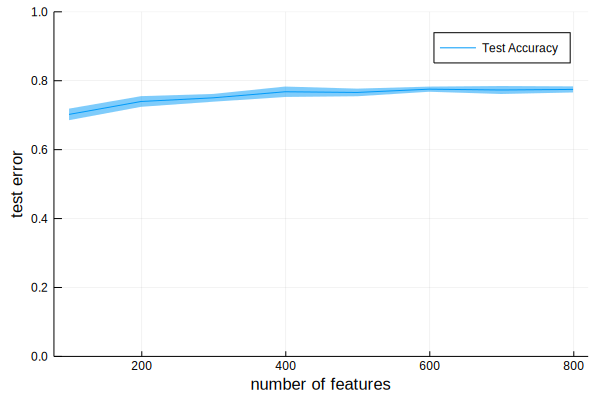

In [16]:
plot(ds,mean_acc_reg,ribbon=std_acc_reg,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")

In [17]:
#V7, training until convergence, more data, with very large regularizer

ntrain=500
ntest=500
Xtrain_samp = Xtrain[1:ntrain,:]
psiTrain_samp = psiTrain[1:ntrain,:]
ytrain_samp = ytrain[1:ntrain]
Xtest_samp = Xtest[1:ntest,:]
psiTest_samp = psiTest[1:ntest,:]
ytest_samp = ytest[1:ntest]
din = size(Xtrain_samp,2)
ds=99:100:799
nreps = 20

accs_reg = zeros(length(ds),nreps)
@time for rep in 1:nreps
    acc = []
    for dout in ds
        println(dout)
        # select random features
        M = RandomFeatureMap(din,dout)
        
        # train
        phiXtrain = featurize(Xtrain_samp,M)
        W, b = gradDescent(phiXtrain, psiTrain_samp, ytrain_samp, 1000, 0.1, true, 0.8)
        #w = phiXtrain\ytrain_samp
        
        # test
        phiXtest = featurize(Xtest_samp,M)
        acc_new = accuracy(ytest_samp, predictedClass(phiXtest*W.+transpose(b)))
        push!(acc, acc_new)
    end
    accs_reg[:,rep] = acc
end
mean_acc_reg = mean(accs_reg,dims=2)
std_acc_reg = std(accs_reg,dims=2);

99


Iteration
1
Loss
15813.83904900774
Train Accuracy
0.11
Magic constant
0.08000000000000002


Iteration
2
Loss
12396.951747388151
Train Accuracy
0.106
Magic constant
0.08000000000000002


Iteration
3
Loss
9805.994731103445
Train Accuracy
0.108
Magic constant
0.08000000000000002


Iteration
4
Loss
7832.160196363674
Train Accuracy
0.108
Magic constant
0.08000000000000002


Iteration
5
Loss
6338.714048589001
Train Accuracy
0.1
Magic constant
0.08000000000000002


Iteration
6
Loss
5202.784647083166
Train Accuracy
0.098
Magic constant
0.08000000000000002


Iteration
7
Loss
4348.411268772339
Train Accuracy
0.096
Magic constant
0.08000000000000002


Iteration
8
Loss
3707.0312491305076
Train Accuracy
0.08
Magic constant
0.08000000000000002


Iteration
9
Loss
3226.848534510498
Train Accuracy
0.076
Magic constant
0.08000000000000002


Iteration
10
Loss
2875.972952703818
Train Accuracy
0.078
Magic constant
0.08000000000000002


Iteration
11
Loss
2625.681670235257
Train Accuracy
0.084
Magic con

Magic constant
0.08000000000000002


Iteration
92
Loss
3278.688524150249
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
93
Loss
3278.6885243434913
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
94
Loss
3278.688524489583
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
95
Loss
3278.688524600028
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
96
Loss
3278.6885246835245
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
97
Loss
3278.688524746648
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
98
Loss
3278.6885247943687
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
99
Loss
3278.688524830446
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
100
Loss
3278.688524857721
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
101
Loss
3265.5737707726903
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
102
L

Magic constant
0.053333333333333344


Iteration
178
Loss
3174.6060278305376
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
179
Loss
3174.6056683694387
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
180
Loss
3174.6053542004393
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
181
Loss
3174.605079616732
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
182
Loss
3174.6048396305728
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
183
Loss
3174.6046298826695
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
184
Loss
3174.6044465630025
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
185
Loss
3174.604286341613
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
186
Loss
3174.6041463081183
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
187
Loss
3174.604023918844
Train Accuracy
0.548
Magic constant
0.0533333333333333

Magic constant
0.04000000000000001


Iteration
268
Loss
3141.4410395370232
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
269
Loss
3141.4342668783556
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
270
Loss
3141.428069143157
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
271
Loss
3141.422397526813
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
272
Loss
3141.417207367679
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
273
Loss
3141.4124577953867
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
274
Loss
3141.4081114090086
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
275
Loss
3141.4041339825408
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
276
Loss
3141.400494195387
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
277
Loss
3141.39716338572
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration

Magic constant
0.03200000000000001


Iteration
354
Loss
3125.460083548767
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
355
Loss
3125.430638225043
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
356
Loss
3125.4030774020366
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
357
Loss
3125.3772804717037
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
358
Loss
3125.35313454491
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
359
Loss
3125.3305339574317
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
360
Loss
3125.3093798075524
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
361
Loss
3125.2895795232644
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
362
Loss
3125.271046457171
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
363
Loss
3125.2536995073074
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteratio

Magic constant
0.026666666666666672


Iteration
440
Loss
3116.448876705738
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
441
Loss
3116.3880624169506
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
442
Loss
3116.330371550034
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
443
Loss
3116.2756436860427
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
444
Loss
3116.2237266451457
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
445
Loss
3116.1744760634683
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
446
Loss
3116.1277549916667
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
447
Loss
3116.083433514111
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
448
Loss
3116.041388387643
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
449
Loss
3116.00150269887
Train Accuracy
0.548
Magic constant
0.026666666666666672




Iteration
525
Loss
3110.9830472992144
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
526
Loss
3110.8897743974558
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
527
Loss
3110.800501866817
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
528
Loss
3110.7150581358246
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
529
Loss
3110.633278991517
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
530
Loss
3110.555007263842
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
531
Loss
3110.480092523599
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
532
Loss
3110.4083907933255
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
533
Loss
3110.339764270595
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
534
Loss
3110.2740810631717
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
535
Loss
3110.211214935533
Train 

Iteration
614
Loss
3106.978917631101
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
615
Loss
3106.8770815751086
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
616
Loss
3106.778994748606
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
617
Loss
3106.684519118735
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
618
Loss
3106.593521734503
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
619
Loss
3106.505874539681
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
620
Loss
3106.4214541926026
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
621
Loss
3106.340141892588
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
622
Loss
3106.2618232127616
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
623
Loss
3106.186387939025
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
624
Loss
3106.1137299149573

Magic constant
0.01777777777777778


Iteration
702
Loss
3104.097596096988
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
703
Loss
3103.9904486347214
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
704
Loss
3103.886756678112
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
705
Loss
3103.786408787102
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
706
Loss
3103.6892971155776
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
707
Loss
3103.5953172954587
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
708
Loss
3103.5043683245385
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
709
Loss
3103.4163524579308
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
710
Loss
3103.3311751030205
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
711
Loss
3103.2487447178055
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iterat

Magic constant
0.01777777777777778


Iteration
790
Loss
3100.960808712871
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
791
Loss
3100.954822643729
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
792
Loss
3100.9490296253175
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
793
Loss
3100.9434234317496
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
794
Loss
3100.9379980379235
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
795
Loss
3100.9327476130493
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
796
Loss
3100.927666514377
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
797
Loss
3100.9227492811365
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
798
Loss
3100.9179906286686
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
799
Loss
3100.913385442742
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iterati

Magic constant
0.016000000000000004


Iteration
879
Loss
3098.3877247300816
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
880
Loss
3098.379662119978
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
881
Loss
3098.3718308371076
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
882
Loss
3098.3642242443775
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
883
Loss
3098.356835895123
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
884
Loss
3098.3496595276424
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
885
Loss
3098.3426890598903
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
886
Loss
3098.3359185843233
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
887
Loss
3098.3293423628957
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
888
Loss
3098.3229548221907
Train Accuracy
0.548
Magic constant
0.016000000000000

Magic constant
0.014545454545454549


Iteration
968
Loss
3096.360311199909
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
969
Loss
3096.350360768007
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
970
Loss
3096.3406674552652
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
971
Loss
3096.3312246177247
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
972
Loss
3096.3220257831053
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
973
Loss
3096.3130646463733
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
974
Loss
3096.3043350654143
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
975
Loss
3096.295831056827
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
976
Loss
3096.287546791822
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
977
Loss
3096.2794765922245
Train Accuracy
0.548
Magic constant
0.01454545454545454

Magic constant
0.08000000000000002


Iteration
55
Loss
3278.6743058035195
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
56
Loss
3278.67777523063
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
57
Loss
3278.680398117526
Train Accuracy
0.548
Magic constant
0.08000000000000002


Iteration
58
Loss
3278.6823810200176
Train Accuracy
0.55
Magic constant
0.08000000000000002


Iteration
59
Loss
3278.6838800943033
Train Accuracy
0.55
Magic constant
0.08000000000000002


Iteration
60
Loss
3278.6850133944627
Train Accuracy
0.55
Magic constant
0.08000000000000002


Iteration
61
Loss
3278.685870169383
Train Accuracy
0.55
Magic constant
0.08000000000000002


Iteration
62
Loss
3278.686517891223
Train Accuracy
0.55
Magic constant
0.08000000000000002


Iteration
63
Loss
3278.687007568934
Train Accuracy
0.55
Magic constant
0.08000000000000002


Iteration
64
Loss
3278.687377765283
Train Accuracy
0.55
Magic constant
0.08000000000000002


Iteration
65
Loss
3278.6876

Iteration
141
Loss
3175.0194287128634
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
142
Loss
3174.9669807179357
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
143
Loss
3174.921141170368
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
144
Loss
3174.8810774057943
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
145
Loss
3174.846061675556
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
146
Loss
3174.8154579273273
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
147
Loss
3174.7887102513755
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
148
Loss
3174.7653327825938
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
149
Loss
3174.744900874878
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
150
Loss
3174.727043387534
Train Accuracy
0.548
Magic constant
0.053333333333333344


Iteration
151
Loss
3174.7114359435

Magic constant
0.04000000000000001


Iteration
227
Loss
3144.3915270341977
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
228
Loss
3144.134290754847
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
229
Loss
3143.898890977432
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
230
Loss
3143.683474025565
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
231
Loss
3143.486343579388
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
232
Loss
3143.3059473177527
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
233
Loss
3143.1408646943264
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
234
Loss
3142.9897957513776
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
235
Loss
3142.8515508831388
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iteration
236
Loss
3142.7250414681607
Train Accuracy
0.548
Magic constant
0.04000000000000001


Iterati

Magic constant
0.03200000000000001


Iteration
313
Loss
3131.9267030952124
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
314
Loss
3131.4833941089005
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
315
Loss
3131.0684568977103
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
316
Loss
3130.680075668037
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
317
Loss
3130.3165508370594
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
318
Loss
3129.9762915952633
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
319
Loss
3129.6578089449413
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
320
Loss
3129.3597091842385
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
321
Loss
3129.08068780822
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
322
Loss
3128.8195238002645
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iterat

Magic constant
0.03200000000000001


Iteration
399
Loss
3125.023455946028
Train Accuracy
0.548
Magic constant
0.03200000000000001


Iteration
400
Loss
3125.021954777239
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
401
Loss
3124.520827189363
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
402
Loss
3124.045437514399
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
403
Loss
3123.59446385314
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
404
Loss
3123.1666521991215
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
405
Loss
3122.760812951652
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
406
Loss
3122.375817607932
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
407
Loss
3122.010595625063
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
408
Loss
3121.664131443234
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iter

Magic constant
0.026666666666666672


Iteration
487
Loss
3115.364143138848
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
488
Loss
3115.3590407566903
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
489
Loss
3115.3542004328806
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
490
Loss
3115.349608708102
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
491
Loss
3115.345252814307
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
492
Loss
3115.3411206392184
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
493
Loss
3115.337200692642
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
494
Loss
3115.333482074522
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
495
Loss
3115.329954444628
Train Accuracy
0.548
Magic constant
0.026666666666666672


Iteration
496
Loss
3115.3266079938066
Train Accuracy
0.548
Magic constant
0.026666666666666672


Magic constant
0.02285714285714286


Iteration
574
Loss
3109.06213394911
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
575
Loss
3109.051246878754
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
576
Loss
3109.0408267427483
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
577
Loss
3109.030853514798
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
578
Loss
3109.0213080275134
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
579
Loss
3109.012171935572
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
580
Loss
3109.0034276804636
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
581
Loss
3108.99505845674
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
582
Loss
3108.9870481797234
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
583
Loss
3108.979381454587
Train Accuracy
0.548
Magic constant
0.02285714285714286


Iteration
5

Magic constant
0.020000000000000004


Iteration
659
Loss
3104.724272804743
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
660
Loss
3104.705444482154
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
661
Loss
3104.6873093492377
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
662
Loss
3104.6698418852948
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
663
Loss
3104.6530175092093
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
664
Loss
3104.636812544847
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
665
Loss
3104.6212041877443
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
666
Loss
3104.6061704730128
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
667
Loss
3104.591690244432
Train Accuracy
0.548
Magic constant
0.020000000000000004


Iteration
668
Loss
3104.5777431246747
Train Accuracy
0.548
Magic constant
0.02000000000000000

Magic constant
0.01777777777777778


Iteration
745
Loss
3101.5866573342673
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
746
Loss
3101.5604876411926
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
747
Loss
3101.5351619207195
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
748
Loss
3101.510652954732
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
749
Loss
3101.486934402897
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
750
Loss
3101.4639807743592
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
751
Loss
3101.4417674003407
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
752
Loss
3101.420270407635
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
753
Loss
3101.3994666929448
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iteration
754
Loss
3101.379333898052
Train Accuracy
0.548
Magic constant
0.01777777777777778


Iterati

Magic constant
0.016000000000000004


Iteration
831
Loss
3099.2432310155523
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
832
Loss
3099.2106227630748
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
833
Loss
3099.178950085643
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
834
Loss
3099.1481861403395
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
835
Loss
3099.1183048544044
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
836
Loss
3099.089280903143
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
837
Loss
3099.0610896884573
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
838
Loss
3099.0337073180062
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
839
Loss
3099.0071105849493
Train Accuracy
0.548
Magic constant
0.016000000000000004


Iteration
840
Loss
3098.9812769482824
Train Accuracy
0.548
Magic constant
0.016000000000000

Magic constant
0.014545454545454549


Iteration
917
Loss
3097.438771983355
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
918
Loss
3097.400954120082
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
919
Loss
3097.3641134703967
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
920
Loss
3097.3282247830984
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
921
Loss
3097.2932634594818
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
922
Loss
3097.2592055364653
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
923
Loss
3097.22602767018
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
924
Loss
3097.19370711996
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
925
Loss
3097.1622217327567
Train Accuracy
0.548
Magic constant
0.014545454545454549


Iteration
926
Loss
3097.131549927959
Train Accuracy
0.548
Magic constant
0.014545454545454549



Magic constant
0.08000000000000002


Iteration
4
Loss
5595.131169548857
Train Accuracy
0.15
Magic constant
0.08000000000000002


Iteration
5
Loss
4604.435760028318
Train Accuracy
0.148
Magic constant
0.08000000000000002


Iteration
6
Loss
3852.138988454764
Train Accuracy
0.156
Magic constant
0.08000000000000002


Iteration
7
Loss
3280.3674245056945
Train Accuracy
0.16
Magic constant
0.08000000000000002


Iteration
8
Loss
2846.4591413720445
Train Accuracy
0.16
Magic constant
0.08000000000000002


Iteration
9
Loss
2520.0818396100576
Train Accuracy
0.164
Magic constant
0.08000000000000002


Iteration
10
Loss
2280.2905204531744
Train Accuracy
0.164
Magic constant
0.08000000000000002


Iteration
11
Loss
2108.6888613824203
Train Accuracy
0.172
Magic constant
0.08000000000000002


Iteration
12
Loss
1996.1347501263174
Train Accuracy
0.178
Magic constant
0.08000000000000002


Iteration
13
Loss
1936.8411758602592
Train Accuracy
0.18
Magic constant
0.08000000000000002


Iteration
14
Loss
1929.019

Magic constant
0.08000000000000002


Iteration
92
Loss
3278.688523615429
Train Accuracy
0.65
Magic constant
0.08000000000000002


Iteration
93
Loss
3278.688523881553
Train Accuracy
0.65
Magic constant
0.08000000000000002


Iteration
94
Loss
3278.6885240827432
Train Accuracy
0.65
Magic constant
0.08000000000000002


Iteration
95
Loss
3278.6885242348426
Train Accuracy
0.65
Magic constant
0.08000000000000002


Iteration
96
Loss
3278.6885243498295
Train Accuracy
0.65
Magic constant
0.08000000000000002


Iteration
97
Loss
3278.68852443676
Train Accuracy
0.65
Magic constant
0.08000000000000002


Iteration
98
Loss
3278.68852450248
Train Accuracy
0.65
Magic constant
0.08000000000000002


Iteration
99
Loss
3278.6885245521635
Train Accuracy
0.65
Magic constant
0.08000000000000002


Iteration
100
Loss
3278.688524589725
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
101
Loss
3265.5737705069114
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
102
Loss
3254.11

Magic constant
0.053333333333333344


Iteration
178
Loss
3174.606027588081
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
179
Loss
3174.605668126983
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
180
Loss
3174.6053539579825
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
181
Loss
3174.605079374277
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
182
Loss
3174.604839388117
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
183
Loss
3174.6046296402146
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
184
Loss
3174.604446320547
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
185
Loss
3174.6042860991583
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
186
Loss
3174.6041460656634
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iteration
187
Loss
3174.6040236763897
Train Accuracy
0.65
Magic constant
0.053333333333333344


Iterati

Magic constant
0.04000000000000001


Iteration
266
Loss
3141.4565276552953
Train Accuracy
0.65
Magic constant
0.04000000000000001


Iteration
267
Loss
3141.448440206739
Train Accuracy
0.65
Magic constant
0.04000000000000001


Iteration
268
Loss
3141.4410392927048
Train Accuracy
0.65
Magic constant
0.04000000000000001


Iteration
269
Loss
3141.434266634039
Train Accuracy
0.65
Magic constant
0.04000000000000001


Iteration
270
Loss
3141.4280688988433
Train Accuracy
0.65
Magic constant
0.04000000000000001


Iteration
271
Loss
3141.422397282501
Train Accuracy
0.65
Magic constant
0.04000000000000001


Iteration
272
Loss
3141.4172071233697
Train Accuracy
0.65
Magic constant
0.04000000000000001


Iteration
273
Loss
3141.4124575510787
Train Accuracy
0.65
Magic constant
0.04000000000000001


Iteration
274
Loss
3141.408111164703
Train Accuracy
0.65
Magic constant
0.04000000000000001


Iteration
275
Loss
3141.4041337382364
Train Accuracy
0.65
Magic constant
0.04000000000000001


Iteration
276
Los

Magic constant
0.03200000000000001


Iteration
355
Loss
3125.430637979788
Train Accuracy
0.65
Magic constant
0.03200000000000001


Iteration
356
Loss
3125.403077156787
Train Accuracy
0.65
Magic constant
0.03200000000000001


Iteration
357
Loss
3125.3772802264575
Train Accuracy
0.65
Magic constant
0.03200000000000001


Iteration
358
Loss
3125.3531342996685
Train Accuracy
0.65
Magic constant
0.03200000000000001


Iteration
359
Loss
3125.3305337121947
Train Accuracy
0.65
Magic constant
0.03200000000000001


Iteration
360
Loss
3125.309379562318
Train Accuracy
0.65
Magic constant
0.03200000000000001


Iteration
361
Loss
3125.2895792780346
Train Accuracy
0.65
Magic constant
0.03200000000000001


Iteration
362
Loss
3125.271046211945
Train Accuracy
0.65
Magic constant
0.03200000000000001


Iteration
363
Loss
3125.2536992620844
Train Accuracy
0.65
Magic constant
0.03200000000000001


Iteration
364
Loss
3125.237462517015
Train Accuracy
0.65
Magic constant
0.03200000000000001


Iteration
365
Loss

Magic constant
0.026666666666666672


Iteration
444
Loss
3116.2237263993584
Train Accuracy
0.65
Magic constant
0.026666666666666672


Iteration
445
Loss
3116.1744758176847
Train Accuracy
0.65
Magic constant
0.026666666666666672


Iteration
446
Loss
3116.127754745885
Train Accuracy
0.65
Magic constant
0.026666666666666672


Iteration
447
Loss
3116.0834332683326
Train Accuracy
0.65
Magic constant
0.026666666666666672


Iteration
448
Loss
3116.0413881418676
Train Accuracy
0.65
Magic constant
0.026666666666666672


Iteration
449
Loss
3116.0015024530976
Train Accuracy
0.65
Magic constant
0.026666666666666672


Iteration
450
Loss
3115.963665293303
Train Accuracy
0.65
Magic constant
0.026666666666666672


Iteration
451
Loss
3115.9277714500354
Train Accuracy
0.65
Magic constant
0.026666666666666672


Iteration
452
Loss
3115.893721114558
Train Accuracy
0.65
Magic constant
0.026666666666666672


Iteration
453
Loss
3115.8614196043104
Train Accuracy
0.65
Magic constant
0.026666666666666672


Itera

Magic constant
0.02285714285714286


Iteration
531
Loss
3110.4800922775094
Train Accuracy
0.65
Magic constant
0.02285714285714286


Iteration
532
Loss
3110.4083905472344
Train Accuracy
0.65
Magic constant
0.02285714285714286


Iteration
533
Loss
3110.3397640245025
Train Accuracy
0.65
Magic constant
0.02285714285714286


Iteration
534
Loss
3110.274080817079
Train Accuracy
0.65
Magic constant
0.02285714285714286


Iteration
535
Loss
3110.2112146894397
Train Accuracy
0.65
Magic constant
0.02285714285714286


Iteration
536
Loss
3110.1510448201643
Train Accuracy
0.65
Magic constant
0.02285714285714286


Iteration
537
Loss
3110.0934555697263
Train Accuracy
0.65
Magic constant
0.02285714285714286


Iteration
538
Loss
3110.038336258252
Train Accuracy
0.65
Magic constant
0.02285714285714286


Iteration
539
Loss
3109.985580952802
Train Accuracy
0.65
Magic constant
0.02285714285714286


Iteration
540
Loss
3109.935088263786
Train Accuracy
0.65
Magic constant
0.02285714285714286


Iteration
541
Los



Iteration
618
Loss
3106.5935214882584
Train Accuracy
0.65
Magic constant
0.020000000000000004


Iteration
619
Loss
3106.5058742934307
Train Accuracy
0.65
Magic constant
0.020000000000000004


Iteration
620
Loss
3106.4214539463474
Train Accuracy
0.65
Magic constant
0.020000000000000004


Iteration
621
Loss
3106.340141646328
Train Accuracy
0.65
Magic constant
0.020000000000000004


Iteration
622
Loss
3106.2618229664968
Train Accuracy
0.65
Magic constant
0.020000000000000004


Iteration
623
Loss
3106.1863876927555
Train Accuracy
0.65
Magic constant
0.020000000000000004


Iteration
624
Loss
3106.113729668684
Train Accuracy
0.65
Magic constant
0.020000000000000004


Iteration
625
Loss
3106.0437466461517
Train Accuracy
0.65
Magic constant
0.020000000000000004


Iteration
626
Loss
3105.9763401414284
Train Accuracy
0.65
Magic constant
0.020000000000000004


Iteration
627
Loss
3105.9114152965935
Train Accuracy
0.65
Magic constant
0.020000000000000004


Iteration
628
Loss
3105.8488807460462
Tr

Magic constant
0.01777777777777778


Iteration
706
Loss
3103.6892968692573
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
707
Loss
3103.5953170491293
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
708
Loss
3103.5043680781996
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
709
Loss
3103.4163522115828
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
710
Loss
3103.3311748566643
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
711
Loss
3103.2487444714416
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
712
Loss
3103.1689724661423
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
713
Loss
3103.0917731080144
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
714
Loss
3103.0170634291844
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
715
Loss
3102.9447631374983
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
716

Magic constant
0.01777777777777778


Iteration
793
Loss
3100.943423185322
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
794
Loss
3100.9379977914973
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
795
Loss
3100.9327473666235
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
796
Loss
3100.9276662679513
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
797
Loss
3100.9227490347116
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
798
Loss
3100.917990382244
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
799
Loss
3100.913385196319
Train Accuracy
0.65
Magic constant
0.01777777777777778


Iteration
800
Loss
3100.908928527639
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
801
Loss
3100.828529149656
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
802
Loss
3100.7504365390105
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
803
L

Magic constant
0.016000000000000004


Iteration
879
Loss
3098.3877244835135
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
880
Loss
3098.3796618734104
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
881
Loss
3098.37183059054
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
882
Loss
3098.3642239978108
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
883
Loss
3098.3568356485566
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
884
Loss
3098.349659281077
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
885
Loss
3098.342688813325
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
886
Loss
3098.335918337759
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
887
Loss
3098.329342116331
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteration
888
Loss
3098.3229545756276
Train Accuracy
0.65
Magic constant
0.016000000000000004


Iteratio

Magic constant
0.014545454545454549


Iteration
965
Loss
3096.3917740751713
Train Accuracy
0.65
Magic constant
0.014545454545454549


Iteration
966
Loss
3096.381010636199
Train Accuracy
0.65
Magic constant
0.014545454545454549


Iteration
967
Loss
3096.370525324489
Train Accuracy
0.65
Magic constant
0.014545454545454549


Iteration
968
Loss
3096.3603109532332
Train Accuracy
0.65
Magic constant
0.014545454545454549


Iteration
969
Loss
3096.350360521332
Train Accuracy
0.65
Magic constant
0.014545454545454549


Iteration
970
Loss
3096.3406672085903
Train Accuracy
0.65
Magic constant
0.014545454545454549


Iteration
971
Loss
3096.3312243710493
Train Accuracy
0.65
Magic constant
0.014545454545454549


Iteration
972
Loss
3096.3220255364313
Train Accuracy
0.65
Magic constant
0.014545454545454549


Iteration
973
Loss
3096.313064399699
Train Accuracy
0.65
Magic constant
0.014545454545454549


Iteration
974
Loss
3096.3043348187402
Train Accuracy
0.65
Magic constant
0.014545454545454549


Iterat

Magic constant
0.08000000000000002


Iteration
52
Loss
3278.640792610545
Train Accuracy
0.584
Magic constant
0.08000000000000002


Iteration
53
Loss
3278.652439232843
Train Accuracy
0.584
Magic constant
0.08000000000000002


Iteration
54
Loss
3278.6612440793
Train Accuracy
0.586
Magic constant
0.08000000000000002


Iteration
55
Loss
3278.667900543222
Train Accuracy
0.584
Magic constant
0.08000000000000002


Iteration
56
Loss
3278.672932829947
Train Accuracy
0.584
Magic constant
0.08000000000000002


Iteration
57
Loss
3278.676737238711
Train Accuracy
0.584
Magic constant
0.08000000000000002


Iteration
58
Loss
3278.6796133717367
Train Accuracy
0.584
Magic constant
0.08000000000000002


Iteration
59
Loss
3278.681787728304
Train Accuracy
0.584
Magic constant
0.08000000000000002


Iteration
60
Loss
3278.683431541869
Train Accuracy
0.584
Magic constant
0.08000000000000002


Iteration
61
Loss
3278.684674264924
Train Accuracy
0.586
Magic constant
0.08000000000000002


Iteration
62
Loss
3278.6

Magic constant
0.053333333333333344


Iteration
139
Loss
3175.1480981114582
Train Accuracy
0.58
Magic constant
0.053333333333333344


Iteration
140
Loss
3175.079437759635
Train Accuracy
0.58
Magic constant
0.053333333333333344


Iteration
141
Loss
3175.0194286121405
Train Accuracy
0.58
Magic constant
0.053333333333333344


Iteration
142
Loss
3174.96698061723
Train Accuracy
0.58
Magic constant
0.053333333333333344


Iteration
143
Loss
3174.9211410696794
Train Accuracy
0.58
Magic constant
0.053333333333333344


Iteration
144
Loss
3174.8810773051187
Train Accuracy
0.58
Magic constant
0.053333333333333344


Iteration
145
Loss
3174.8460615748927
Train Accuracy
0.58
Magic constant
0.053333333333333344


Iteration
146
Loss
3174.815457826675
Train Accuracy
0.58
Magic constant
0.053333333333333344


Iteration
147
Loss
3174.788710150733
Train Accuracy
0.58
Magic constant
0.053333333333333344


Iteration
148
Loss
3174.76533268196
Train Accuracy
0.58
Magic constant
0.053333333333333344


Iteration

Magic constant
0.04000000000000001


Iteration
225
Loss
3144.979799421071
Train Accuracy
0.58
Magic constant
0.04000000000000001


Iteration
226
Loss
3144.6726253438273
Train Accuracy
0.58
Magic constant
0.04000000000000001


Iteration
227
Loss
3144.3915269326944
Train Accuracy
0.58
Magic constant
0.04000000000000001


Iteration
228
Loss
3144.134290653351
Train Accuracy
0.58
Magic constant
0.04000000000000001


Iteration
229
Loss
3143.8988908759425
Train Accuracy
0.58
Magic constant
0.04000000000000001


Iteration
230
Loss
3143.6834739240817
Train Accuracy
0.58
Magic constant
0.04000000000000001


Iteration
231
Loss
3143.486343477912
Train Accuracy
0.58
Magic constant
0.04000000000000001


Iteration
232
Loss
3143.305947216284
Train Accuracy
0.58
Magic constant
0.04000000000000001


Iteration
233
Loss
3143.140864592864
Train Accuracy
0.58
Magic constant
0.04000000000000001


Iteration
234
Loss
3142.989795649921
Train Accuracy
0.58
Magic constant
0.04000000000000001


Iteration
235
Loss


Magic constant
0.03200000000000001


Iteration
313
Loss
3131.9267029934763
Train Accuracy
0.58
Magic constant
0.03200000000000001


Iteration
314
Loss
3131.4833940071535
Train Accuracy
0.58
Magic constant
0.03200000000000001


Iteration
315
Loss
3131.0684567959547
Train Accuracy
0.58
Magic constant
0.03200000000000001


Iteration
316
Loss
3130.6800755662716
Train Accuracy
0.58
Magic constant
0.03200000000000001


Iteration
317
Loss
3130.316550735288
Train Accuracy
0.58
Magic constant
0.03200000000000001


Iteration
318
Loss
3129.9762914934863
Train Accuracy
0.58
Magic constant
0.03200000000000001


Iteration
319
Loss
3129.6578088431597
Train Accuracy
0.58
Magic constant
0.03200000000000001


Iteration
320
Loss
3129.3597090824533
Train Accuracy
0.58
Magic constant
0.03200000000000001


Iteration
321
Loss
3129.0806877064315
Train Accuracy
0.58
Magic constant
0.03200000000000001


Iteration
322
Loss
3128.8195236984748
Train Accuracy
0.58
Magic constant
0.03200000000000001


Iteration
323


Magic constant
0.03200000000000001


Iteration
400
Loss
3125.021954675548
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
401
Loss
3124.5208270876446
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
402
Loss
3124.045437412656
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
403
Loss
3123.5944637513744
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
404
Loss
3123.166652097336
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
405
Loss
3122.7608128498473
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
406
Loss
3122.375817506109
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
407
Loss
3122.010595523225
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
408
Loss
3121.6641313413816
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
409
Loss
3121.3354615599173
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteratio

Magic constant
0.026666666666666672


Iteration
486
Loss
3115.369521665456
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
487
Loss
3115.364143036938
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
488
Loss
3115.359040654782
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
489
Loss
3115.354200330972
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
490
Loss
3115.3496086061937
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
491
Loss
3115.3452527124
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
492
Loss
3115.3411205373113
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
493
Loss
3115.3372005907354
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
494
Loss
3115.3334819726156
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration
495
Loss
3115.329954342722
Train Accuracy
0.58
Magic constant
0.026666666666666672


Iteration


Magic constant
0.02285714285714286


Iteration
574
Loss
3109.0621338470537
Train Accuracy
0.58
Magic constant
0.02285714285714286


Iteration
575
Loss
3109.0512467766976
Train Accuracy
0.58
Magic constant
0.02285714285714286


Iteration
576
Loss
3109.040826640693
Train Accuracy
0.58
Magic constant
0.02285714285714286


Iteration
577
Loss
3109.0308534127444
Train Accuracy
0.58
Magic constant
0.02285714285714286


Iteration
578
Loss
3109.0213079254595
Train Accuracy
0.58
Magic constant
0.02285714285714286


Iteration
579
Loss
3109.012171833519
Train Accuracy
0.58
Magic constant
0.02285714285714286


Iteration
580
Loss
3109.0034275784105
Train Accuracy
0.58
Magic constant
0.02285714285714286


Iteration
581
Loss
3108.9950583546884
Train Accuracy
0.58
Magic constant
0.02285714285714286


Iteration
582
Loss
3108.9870480776717
Train Accuracy
0.58
Magic constant
0.02285714285714286


Iteration
583
Loss
3108.9793813525357
Train Accuracy
0.58
Magic constant
0.02285714285714286


Iteration
584
L

Magic constant
0.020000000000000004


Iteration
661
Loss
3104.6873092470787
Train Accuracy
0.58
Magic constant
0.020000000000000004


Iteration
662
Loss
3104.669841783137
Train Accuracy
0.58
Magic constant
0.020000000000000004


Iteration
663
Loss
3104.6530174070513
Train Accuracy
0.58
Magic constant
0.020000000000000004


Iteration
664
Loss
3104.63681244269
Train Accuracy
0.58
Magic constant
0.020000000000000004


Iteration
665
Loss
3104.6212040855876
Train Accuracy
0.58
Magic constant
0.020000000000000004


Iteration
666
Loss
3104.6061703708565
Train Accuracy
0.58
Magic constant
0.020000000000000004


Iteration
667
Loss
3104.591690142276
Train Accuracy
0.58
Magic constant
0.020000000000000004


Iteration
668
Loss
3104.5777430225194
Train Accuracy
0.58
Magic constant
0.020000000000000004


Iteration
669
Loss
3104.5643093844787
Train Accuracy
0.58
Magic constant
0.020000000000000004


Iteration
670
Loss
3104.551370323642
Train Accuracy
0.58
Magic constant
0.020000000000000004


Iterati

Magic constant
0.01777777777777778


Iteration
748
Loss
3101.510652852504
Train Accuracy
0.58
Magic constant
0.01777777777777778


Iteration
749
Loss
3101.486934300669
Train Accuracy
0.58
Magic constant
0.01777777777777778


Iteration
750
Loss
3101.4639806721307
Train Accuracy
0.58
Magic constant
0.01777777777777778


Iteration
751
Loss
3101.441767298113
Train Accuracy
0.58
Magic constant
0.01777777777777778


Iteration
752
Loss
3101.4202703054075
Train Accuracy
0.58
Magic constant
0.01777777777777778


Iteration
753
Loss
3101.3994665907157
Train Accuracy
0.58
Magic constant
0.01777777777777778


Iteration
754
Loss
3101.379333795824
Train Accuracy
0.58
Magic constant
0.01777777777777778


Iteration
755
Loss
3101.3598502835666
Train Accuracy
0.58
Magic constant
0.01777777777777778


Iteration
756
Loss
3101.3409951145804
Train Accuracy
0.58
Magic constant
0.01777777777777778


Iteration
757
Loss
3101.3227480247942
Train Accuracy
0.58
Magic constant
0.01777777777777778


Iteration
758
Los

Magic constant
0.016000000000000004


Iteration
835
Loss
3099.1183047521276
Train Accuracy
0.58
Magic constant
0.016000000000000004


Iteration
836
Loss
3099.0892808008653
Train Accuracy
0.58
Magic constant
0.016000000000000004


Iteration
837
Loss
3099.06108958618
Train Accuracy
0.58
Magic constant
0.016000000000000004


Iteration
838
Loss
3099.033707215728
Train Accuracy
0.58
Magic constant
0.016000000000000004


Iteration
839
Loss
3099.007110482671
Train Accuracy
0.58
Magic constant
0.016000000000000004


Iteration
840
Loss
3098.981276846004
Train Accuracy
0.58
Magic constant
0.016000000000000004


Iteration
841
Loss
3098.956184411455
Train Accuracy
0.58
Magic constant
0.016000000000000004


Iteration
842
Loss
3098.9318119129302
Train Accuracy
0.58
Magic constant
0.016000000000000004


Iteration
843
Loss
3098.9081386944863
Train Accuracy
0.58
Magic constant
0.016000000000000004


Iteration
844
Loss
3098.8851446928284
Train Accuracy
0.58
Magic constant
0.016000000000000004


Iteratio

Magic constant
0.014545454545454549


Iteration
922
Loss
3097.2592054341567
Train Accuracy
0.58
Magic constant
0.014545454545454549


Iteration
923
Loss
3097.2260275678705
Train Accuracy
0.58
Magic constant
0.014545454545454549


Iteration
924
Loss
3097.193707017649
Train Accuracy
0.58
Magic constant
0.014545454545454549


Iteration
925
Loss
3097.162221630446
Train Accuracy
0.58
Magic constant
0.014545454545454549


Iteration
926
Loss
3097.131549825647
Train Accuracy
0.58
Magic constant
0.014545454545454549


Iteration
927
Loss
3097.1016705802854
Train Accuracy
0.58
Magic constant
0.014545454545454549


Iteration
928
Loss
3097.072563414623
Train Accuracy
0.58
Magic constant
0.014545454545454549


Iteration
929
Loss
3097.0442083781218
Train Accuracy
0.58
Magic constant
0.014545454545454549


Iteration
930
Loss
3097.0165860357633
Train Accuracy
0.58
Magic constant
0.014545454545454549


Iteration
931
Loss
3096.989677454732
Train Accuracy
0.58
Magic constant
0.014545454545454549


Iterati

Iteration
8
Loss
3458.914385508592
Train Accuracy
0.084
Magic constant
0.08000000000000002


Iteration
9
Loss
3051.7536474938997
Train Accuracy
0.096
Magic constant
0.08000000000000002


Iteration
10
Loss
2754.342624695434
Train Accuracy
0.098
Magic constant
0.08000000000000002


Iteration
11
Loss
2543.0242276769422
Train Accuracy
0.102
Magic constant
0.08000000000000002


Iteration
12
Loss
2407.6847296792844
Train Accuracy
0.1
Magic constant
0.08000000000000002


Iteration
13
Loss
2336.132569361331
Train Accuracy
0.1
Magic constant
0.08000000000000002


Iteration
14
Loss
2319.903915498845
Train Accuracy
0.104
Magic constant
0.08000000000000002


Iteration
15
Loss
2351.282764023127
Train Accuracy
0.108
Magic constant
0.08000000000000002


Iteration
16
Loss
2422.5923045042778
Train Accuracy
0.112
Magic constant
0.08000000000000002


Iteration
17
Loss
2529.1282478009107
Train Accuracy
0.118
Magic constant
0.08000000000000002


Iteration
18
Loss
2648.908073277212
Train Accuracy
0.116
Magi

Magic constant
0.08000000000000002


Iteration
96
Loss
3278.688524405605
Train Accuracy
0.604
Magic constant
0.08000000000000002


Iteration
97
Loss
3278.688524466462
Train Accuracy
0.604
Magic constant
0.08000000000000002


Iteration
98
Loss
3278.6885245124704
Train Accuracy
0.604
Magic constant
0.08000000000000002


Iteration
99
Loss
3278.6885245472513
Train Accuracy
0.604
Magic constant
0.08000000000000002


Iteration
100
Loss
3278.6885245735466
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
101
Loss
3265.5737704859457
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
102
Loss
3254.111475413347
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
103
Loss
3244.093429519866
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
104
Loss
3235.337657408937
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
105
Loss
3227.685112583962
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iterati

Magic constant
0.053333333333333344


Iteration
181
Loss
3174.6050793218233
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
182
Loss
3174.604839335664
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
183
Loss
3174.6046295877613
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
184
Loss
3174.604446268094
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
185
Loss
3174.6042860467046
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
186
Loss
3174.6041460132105
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
187
Loss
3174.604023623937
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
188
Loss
3174.603916655711
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
189
Loss
3174.603823165482
Train Accuracy
0.604
Magic constant
0.053333333333333344


Iteration
190
Loss
3174.603741455022
Train Accuracy
0.604
Magic constant
0.053333333333333344


Magic constant
0.04000000000000001


Iteration
267
Loss
3141.448440153881
Train Accuracy
0.604
Magic constant
0.04000000000000001


Iteration
268
Loss
3141.4410392398477
Train Accuracy
0.604
Magic constant
0.04000000000000001


Iteration
269
Loss
3141.4342665811832
Train Accuracy
0.604
Magic constant
0.04000000000000001


Iteration
270
Loss
3141.4280688459876
Train Accuracy
0.604
Magic constant
0.04000000000000001


Iteration
271
Loss
3141.4223972296463
Train Accuracy
0.604
Magic constant
0.04000000000000001


Iteration
272
Loss
3141.4172070705135
Train Accuracy
0.604
Magic constant
0.04000000000000001


Iteration
273
Loss
3141.4124574982234
Train Accuracy
0.604
Magic constant
0.04000000000000001


Iteration
274
Loss
3141.4081111118485
Train Accuracy
0.604
Magic constant
0.04000000000000001


Iteration
275
Loss
3141.4041336853825
Train Accuracy
0.604
Magic constant
0.04000000000000001


Iteration
276
Loss
3141.4004938982303
Train Accuracy
0.604
Magic constant
0.04000000000000001


Iter

Magic constant
0.03200000000000001


Iteration
354
Loss
3125.4600832504475
Train Accuracy
0.604
Magic constant
0.03200000000000001


Iteration
355
Loss
3125.430637926728
Train Accuracy
0.604
Magic constant
0.03200000000000001


Iteration
356
Loss
3125.403077103728
Train Accuracy
0.604
Magic constant
0.03200000000000001


Iteration
357
Loss
3125.3772801733994
Train Accuracy
0.604
Magic constant
0.03200000000000001


Iteration
358
Loss
3125.3531342466113
Train Accuracy
0.604
Magic constant
0.03200000000000001


Iteration
359
Loss
3125.3305336591384
Train Accuracy
0.604
Magic constant
0.03200000000000001


Iteration
360
Loss
3125.309379509263
Train Accuracy
0.604
Magic constant
0.03200000000000001


Iteration
361
Loss
3125.2895792249806
Train Accuracy
0.604
Magic constant
0.03200000000000001


Iteration
362
Loss
3125.2710461588913
Train Accuracy
0.604
Magic constant
0.03200000000000001


Iteration
363
Loss
3125.2536992090318
Train Accuracy
0.604
Magic constant
0.03200000000000001


Iterat

Magic constant
0.026666666666666672


Iteration
441
Loss
3116.3880621179787
Train Accuracy
0.604
Magic constant
0.026666666666666672


Iteration
442
Loss
3116.330371251065
Train Accuracy
0.604
Magic constant
0.026666666666666672


Iteration
443
Loss
3116.2756433870773
Train Accuracy
0.604
Magic constant
0.026666666666666672


Iteration
444
Loss
3116.223726346184
Train Accuracy
0.604
Magic constant
0.026666666666666672


Iteration
445
Loss
3116.17447576451
Train Accuracy
0.604
Magic constant
0.026666666666666672


Iteration
446
Loss
3116.1277546927113
Train Accuracy
0.604
Magic constant
0.026666666666666672


Iteration
447
Loss
3116.08343321516
Train Accuracy
0.604
Magic constant
0.026666666666666672


Iteration
448
Loss
3116.0413880886954
Train Accuracy
0.604
Magic constant
0.026666666666666672


Iteration
449
Loss
3116.0015023999267
Train Accuracy
0.604
Magic constant
0.026666666666666672


Iteration
450
Loss
3115.9636652401323
Train Accuracy
0.604
Magic constant
0.026666666666666672


0.604
Magic constant
0.02285714285714286


Iteration
528
Loss
3110.7150578365013
Train Accuracy
0.604
Magic constant
0.02285714285714286


Iteration
529
Loss
3110.633278692191
Train Accuracy
0.604
Magic constant
0.02285714285714286


Iteration
530
Loss
3110.555006964514
Train Accuracy
0.604
Magic constant
0.02285714285714286


Iteration
531
Loss
3110.4800922242684
Train Accuracy
0.604
Magic constant
0.02285714285714286


Iteration
532
Loss
3110.4083904939944
Train Accuracy
0.604
Magic constant
0.02285714285714286


Iteration
533
Loss
3110.3397639712616
Train Accuracy
0.604
Magic constant
0.02285714285714286


Iteration
534
Loss
3110.274080763838
Train Accuracy
0.604
Magic constant
0.02285714285714286


Iteration
535
Loss
3110.2112146361987
Train Accuracy
0.604
Magic constant
0.02285714285714286


Iteration
536
Loss
3110.1510447669225
Train Accuracy
0.604
Magic constant
0.02285714285714286


Iteration
537
Loss
3110.0934555164854
Train Accuracy
0.604
Magic constant
0.02285714285714286




Magic constant
0.020000000000000004


Iteration
614
Loss
3106.9789173316203
Train Accuracy
0.604
Magic constant
0.020000000000000004


Iteration
615
Loss
3106.8770812756175
Train Accuracy
0.604
Magic constant
0.020000000000000004


Iteration
616
Loss
3106.778994449105
Train Accuracy
0.604
Magic constant
0.020000000000000004


Iteration
617
Loss
3106.684518819226
Train Accuracy
0.604
Magic constant
0.020000000000000004


Iteration
618
Loss
3106.5935214349856
Train Accuracy
0.604
Magic constant
0.020000000000000004


Iteration
619
Loss
3106.5058742401566
Train Accuracy
0.604
Magic constant
0.020000000000000004


Iteration
620
Loss
3106.421453893072
Train Accuracy
0.604
Magic constant
0.020000000000000004


Iteration
621
Loss
3106.340141593051
Train Accuracy
0.604
Magic constant
0.020000000000000004


Iteration
622
Loss
3106.2618229132186
Train Accuracy
0.604
Magic constant
0.020000000000000004


Iteration
623
Loss
3106.1863876394764
Train Accuracy
0.604
Magic constant
0.02000000000000000

Magic constant
0.020000000000000004


Iteration
699
Loss
3104.326920984021
Train Accuracy
0.604
Magic constant
0.020000000000000004


Iteration
700
Loss
3104.322721691507
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
701
Loss
3104.2083139191413
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
702
Loss
3104.0975957974338
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
703
Loss
3103.9904483351515
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
704
Loss
3103.886756378527
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
705
Loss
3103.7864084875046
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
706
Loss
3103.6892968159673
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
707
Loss
3103.595316995837
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
708
Loss
3103.5043680249055
Train Accuracy
0.604
Magic constant
0.01777777777777778


Itera

Magic constant
0.01777777777777778


Iteration
786
Loss
3100.9868151231826
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
787
Loss
3100.9799903376424
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
788
Loss
3100.9733856514363
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
789
Loss
3100.96699396636
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
790
Loss
3100.960808413128
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
791
Loss
3100.954822343987
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
792
Loss
3100.949029325576
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
793
Loss
3100.9434231320083
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
794
Loss
3100.937997738184
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
795
Loss
3100.93274731331
Train Accuracy
0.604
Magic constant
0.01777777777777778


Iteration
7

Magic constant
0.016000000000000004


Iteration
871
Loss
3098.461416995946
Train Accuracy
0.604
Magic constant
0.016000000000000004


Iteration
872
Loss
3098.4512400460544
Train Accuracy
0.604
Magic constant
0.016000000000000004


Iteration
873
Loss
3098.4413550866757
Train Accuracy
0.604
Magic constant
0.016000000000000004


Iteration
874
Loss
3098.4317537402057
Train Accuracy
0.604
Magic constant
0.016000000000000004


Iteration
875
Loss
3098.4224278694055
Train Accuracy
0.604
Magic constant
0.016000000000000004


Iteration
876
Loss
3098.4133695705027
Train Accuracy
0.604
Magic constant
0.016000000000000004


Iteration
877
Loss
3098.4045711664967
Train Accuracy
0.604
Magic constant
0.016000000000000004


Iteration
878
Loss
3098.39602520065
Train Accuracy
0.604
Magic constant
0.016000000000000004


Iteration
879
Loss
3098.3877244301693
Train Accuracy
0.604
Magic constant
0.016000000000000004


Iteration
880
Loss
3098.3796618200668
Train Accuracy
0.604
Magic constant
0.0160000000000000

Magic constant
0.014545454545454549


Iteration
956
Loss
3096.5024450178194
Train Accuracy
0.604
Magic constant
0.014545454545454549


Iteration
957
Loss
3096.4888218403103
Train Accuracy
0.604
Magic constant
0.014545454545454549


Iteration
958
Loss
3096.4755506857073
Train Accuracy
0.604
Magic constant
0.014545454545454549


Iteration
959
Loss
3096.4626224577387
Train Accuracy
0.604
Magic constant
0.014545454545454549


Iteration
960
Loss
3096.450028295182
Train Accuracy
0.604
Magic constant
0.014545454545454549


Iteration
961
Loss
3096.437759565785
Train Accuracy
0.604
Magic constant
0.014545454545454549


Iteration
962
Loss
3096.425807860356
Train Accuracy
0.604
Magic constant
0.014545454545454549


Iteration
963
Loss
3096.414164986995
Train Accuracy
0.604
Magic constant
0.014545454545454549


Iteration
964
Loss
3096.4028229654814
Train Accuracy
0.604
Magic constant
0.014545454545454549


Iteration
965
Loss
3096.3917740218044
Train Accuracy
0.604
Magic constant
0.01454545454545454

Magic constant
0.08000000000000002


Iteration
43
Loss
3278.151296152148
Train Accuracy
0.484
Magic constant
0.08000000000000002


Iteration
44
Loss
3278.2823799026455
Train Accuracy
0.484
Magic constant
0.08000000000000002


Iteration
45
Loss
3278.381479218022
Train Accuracy
0.496
Magic constant
0.08000000000000002


Iteration
46
Loss
3278.4563983004473
Train Accuracy
0.506
Magic constant
0.08000000000000002


Iteration
47
Loss
3278.5130371267605
Train Accuracy
0.512
Magic constant
0.08000000000000002


Iteration
48
Loss
3278.5558560794543
Train Accuracy
0.516
Magic constant
0.08000000000000002


Iteration
49
Loss
3278.5882272076897
Train Accuracy
0.516
Magic constant
0.08000000000000002


Iteration
50
Loss
3278.612699780637
Train Accuracy
0.518
Magic constant
0.08000000000000002


Iteration
51
Loss
3278.631201045785
Train Accuracy
0.524
Magic constant
0.08000000000000002


Iteration
52
Loss
3278.6451880022364
Train Accuracy
0.526
Magic constant
0.08000000000000002


Iteration
53
Loss

Magic constant
0.053333333333333344


Iteration
130
Loss
3176.434361184597
Train Accuracy
0.532
Magic constant
0.053333333333333344


Iteration
131
Loss
3176.2036316815047
Train Accuracy
0.532
Magic constant
0.053333333333333344


Iteration
132
Loss
3176.0019740958014
Train Accuracy
0.532
Magic constant
0.053333333333333344


Iteration
133
Loss
3175.8257253658967
Train Accuracy
0.532
Magic constant
0.053333333333333344


Iteration
134
Loss
3175.6716839759592
Train Accuracy
0.532
Magic constant
0.053333333333333344


Iteration
135
Loss
3175.5370518011537
Train Accuracy
0.532
Magic constant
0.053333333333333344


Iteration
136
Loss
3175.419383280373
Train Accuracy
0.532
Magic constant
0.053333333333333344


Iteration
137
Loss
3175.3165409932108
Train Accuracy
0.532
Magic constant
0.053333333333333344


Iteration
138
Loss
3175.2266568342307
Train Accuracy
0.532
Magic constant
0.053333333333333344


Iteration
139
Loss
3175.148098079282
Train Accuracy
0.532
Magic constant
0.0533333333333333

Magic constant
0.04000000000000001


Iteration
215
Loss
3150.147342152806
Train Accuracy
0.532
Magic constant
0.04000000000000001


Iteration
216
Loss
3149.401501112029
Train Accuracy
0.532
Magic constant
0.04000000000000001


Iteration
217
Loss
3148.718973688491
Train Accuracy
0.532
Magic constant
0.04000000000000001


Iteration
218
Loss
3148.094385259573
Train Accuracy
0.532
Magic constant
0.04000000000000001


Iteration
219
Loss
3147.5228174483973
Train Accuracy
0.532
Magic constant
0.04000000000000001


Iteration
220
Loss
3146.9997693936366
Train Accuracy
0.532
Magic constant
0.04000000000000001


Iteration
221
Loss
3146.5211223070783
Train Accuracy
0.532
Magic constant
0.04000000000000001


Iteration
222
Loss
3146.083107039868
Train Accuracy
0.532
Magic constant
0.04000000000000001


Iteration
223
Loss
3145.682274402007
Train Accuracy
0.532
Magic constant
0.04000000000000001


Iteration
224
Loss
3145.315468001404
Train Accuracy
0.532
Magic constant
0.04000000000000001


Iteration


Magic constant
0.03200000000000001


Iteration
301
Loss
3140.318504819412
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
302
Loss
3139.338120514151
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
303
Loss
3138.4204808044246
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
304
Loss
3137.5615700361204
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
305
Loss
3136.7576295569866
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
306
Loss
3136.0051412685166
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
307
Loss
3135.300812230508
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
308
Loss
3134.6415602509314
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
309
Loss
3134.024500398047
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
310
Loss
3133.446932375746
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteratio

Magic constant
0.03200000000000001


Iteration
388
Loss
3125.048552954104
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
389
Loss
3125.045445568206
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
390
Loss
3125.0425370550056
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
391
Loss
3125.039814686651
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
392
Loss
3125.0372665498708
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
393
Loss
3125.0348814938443
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
394
Loss
3125.0326490814036
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
395
Loss
3125.0305595433592
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
396
Loss
3125.0286037357496
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iteration
397
Loss
3125.0267730998266
Train Accuracy
0.532
Magic constant
0.03200000000000001


Iterat

Magic constant
0.026666666666666672


Iteration
473
Loss
3115.472636969832
Train Accuracy
0.532
Magic constant
0.026666666666666672


Iteration
474
Loss
3115.461962337607
Train Accuracy
0.532
Magic constant
0.026666666666666672


Iteration
475
Loss
3115.4518359544927
Train Accuracy
0.532
Magic constant
0.026666666666666672


Iteration
476
Loss
3115.442229662416
Train Accuracy
0.532
Magic constant
0.026666666666666672


Iteration
477
Loss
3115.4331167494997
Train Accuracy
0.532
Magic constant
0.026666666666666672


Iteration
478
Loss
3115.424471875791
Train Accuracy
0.532
Magic constant
0.026666666666666672


Iteration
479
Loss
3115.416271002796
Train Accuracy
0.532
Magic constant
0.026666666666666672


Iteration
480
Loss
3115.408491326638
Train Accuracy
0.532
Magic constant
0.026666666666666672


Iteration
481
Loss
3115.4011112146472
Train Accuracy
0.532
Magic constant
0.026666666666666672


Iteration
482
Loss
3115.3941101452083
Train Accuracy
0.532
Magic constant
0.026666666666666672


Excessive output truncated after 524288 bytes.

Magic constant


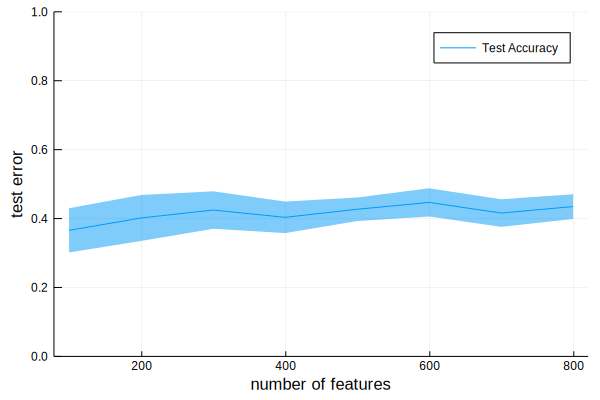

In [18]:
plot(ds,mean_acc_reg,ribbon=std_acc_reg,label="Test Accuracy")
ylims!((0.0, 1.0))
ylabel!("test error")
xlabel!("number of features")